# Genetic diversity and population structure

## Setup

In [36]:
### Load packages
library(MASS)
library(tidyverse)
library(emmeans)
library(gridExtra)
library(fs)
library(ggridges)
library(data.table)
library(RcppCNPy)
library(R.utils)
library(car)
library(ggrepel)
library(patchwork)
library(Cairo)
library(dplyr)
library(ggpubr)
library(IRdisplay)
library(lme4)
library(lmerTest)
library(MuMIn)
library(glmmTMB)
library(multcomp)
library(DHARMa)

## Load summary dataset

In [37]:
# Load in summary datasets rather than re-summarizing from raw data
obs_div_df <- suppressMessages(read_delim('../analyses/tables/div_popStruct/observed_urban-rural_pi.txt.bz2', delim = '\t'))  # Observed urban-rural thetas
obs_div_df<-subset(obs_div_df, city !='Bogota' & city !='Canberra' & city !='Hiroshima' & city!='Kyoto' & city!='Medellin' & city!='Melbourne' & city!='Paris')

ci_div_df <- suppressMessages(read_delim('../analyses/tables/div_popStruct/bootstrapped_CI_urban-rural_pi.txt.bz2', delim = '\t'))  # CI from bootstrapped urban-rural thetas
ci_div_df<-subset(ci_div_df, city !='Bogota' & city !='Canberra' & city !='Hiroshima' & city!='Kyoto' & city!='Medellin' & city!='Melbourne' & city!='Paris')

obs_fst_df <- suppressMessages(read_delim('../analyses/tables/div_popStruct/observed_fst.txt.bz2', delim = '\t'))  # Observed urban-rural fst
obs_fst_df<-subset(obs_fst_df, city !='Bogota' & city !='Canberra' & city !='Hiroshima' & city!='Kyoto' & city!='Medellin' & city!='Melbourne' & city!='Paris')

pop_fst_df <- suppressMessages(read_delim('../analyses/tables/observed_fst_per_pop.csv', delim = ','))  # Observed between pop fst

table_inbreeding <- suppressMessages(read_delim('../analyses/tables/div_popStruct/relatedness_table.txt.bz2', delim = '\t'))  # Observed relatedness


In [42]:
# Theme used for plotting
ng2 <- theme(panel.background = element_blank(),
             #aspect.ratio=0.5,
             panel.grid.major = element_blank(),
             panel.grid.minor = element_blank(),
             panel.border=element_blank(),
             axis.line.x = element_line(color="black",size=1),
             axis.line.y = element_line(color="black",size=1),
             axis.ticks=element_line(size = 1, color="black"),
             axis.ticks.length=unit(0.25, 'cm'),
             axis.text=element_text(color="black",size=15),
             axis.title=element_text(color="black",size=1),
             axis.title.y=element_text(vjust=2,size=17),
             #axis.title.x=element_text(vjust=0.1,size=17),
             axis.text.x=element_text(size=15,angle = 45,hjust = 1),
             axis.text.y=element_text(size=15),
             strip.text.x = element_text(size = 10, colour = "black",face = "bold"),
             strip.background = element_rect(colour="black"),
             axis.title.x=element_blank(),
             legend.position = "top", 
             legend.direction="horizontal",
             legend.text=element_text(size=15), legend.key = element_rect(fill = "white"),
             legend.title = element_text(size=15),legend.key.size = unit(0.7, "cm"))


ng3 <- theme(panel.background = element_blank(),
             #aspect.ratio=0.5,
             panel.grid.major = element_blank(),
             panel.grid.minor = element_blank(),
             panel.border=element_blank(),
             axis.line.x = element_line(color="black",size=1),
             axis.line.y = element_line(color="black",size=1),
             axis.ticks=element_line(size = 1, color="black"),
             axis.ticks.length=unit(0.25, 'cm'),
             axis.text=element_text(color="black",size=15),
             axis.title=element_text(color="black",size=1),
             axis.title.y=element_text(vjust=2,size=17),
             #axis.title.x=element_text(vjust=0.1,size=17),
             axis.text.x=element_text(size=12),
             axis.text.y=element_text(size=15),
             strip.text.x = element_text(size = 10, colour = "black",face = "bold"),
             strip.background = element_rect(colour="black"),
             axis.title.x=element_blank(),
             legend.position = "top", 
             legend.direction="horizontal",
             legend.text=element_text(size=15), legend.key = element_rect(fill = "white"),
             legend.title = element_text(size=15),legend.key.size = unit(0.7, "cm"))

urban_col <- "#7b3294"
rural_col <- "#a6dba0"
cols <- c(urban_col, rural_col)

## Editing diversity file to have proper labels in figures

In [3]:
# generating file with details
## loading sample sheet
sample_sheet<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t")
city_detail<-distinct(sample_sheet, city, .keep_all= TRUE)

# DIVERSITY
obs_div_df2<-merge(obs_div_df,ci_div_df, by.x=c("city","habitat"), by.y=c("city","habitat"), all.x=TRUE, all.y=FALSE)
## merging details per city to the diversity values
div_table<-merge(obs_div_df2,city_detail, by.x="city", by.y="city", all.x=TRUE, all.y=FALSE)
div_table$city<-sub("Cape_Town", "Cape Town", div_table$city)
div_table$city<-sub("Buenos_Aires", "Buenos Aires", div_table$city)
div_table$city<-sub("Mexico_City", "Mexico City", div_table$city)
div_table$city<-sub("Palmerston_North", "Palmerston N", div_table$city)
div_table$city<-sub("Punta_Arenas", "Punta Arenas", div_table$city)
div_table$continent<-sub("EU", "EUROPE", div_table$continent)
div_table$continent<-sub("ASI", "ASIA", div_table$continent)
div_table$continent<-sub("AFR", "AFR", div_table$continent)
div_table$continent<-sub("NAM", "NORTH AM.", div_table$continent)
div_table$continent<-sub("SAM", "SOUTH AM.", div_table$continent)
div_table$continent<-sub("OCE", "OCEANIA", div_table$continent)
level_order <- c('Antwerp', 'Landshut', 'Linkoping','Munich','Thessaloniki','Warsaw',
                 'Tehran','Kunming','Sapporo','Cape Town',
                 'Albuquerque','Athens','Calgary','Memphis','Mexico City', 'Toronto', 'Vancouver',
                 'Buenos Aires','Loja','Punta Arenas','Quito',
                 'Armidale','Christchurch','Palmerston N') 
div_table$continent_order<-factor(div_table$continent, levels=c('EUROPE','ASIA','AFR','NORTH AM.','SOUTH AM.','OCEANIA'))


# RELATEDNESS
## merging details per city to the diversity values
inbr_table<-merge(table_inbreeding,city_detail, by.x="city", by.y="city", all.x=TRUE, all.y=FALSE)
inbr_table$city<-sub("Cape_Town", "Cape Town", inbr_table$city)
inbr_table$city<-sub("Buenos_Aires", "Buenos Aires", inbr_table$city)
inbr_table$city<-sub("Mexico_City", "Mexico City", inbr_table$city)
inbr_table$city<-sub("Palmerston_North", "Palmerston N", inbr_table$city)
inbr_table$city<-sub("Punta_Arenas", "Punta Arenas", inbr_table$city)
inbr_table$continent<-sub("EU", "EUROPE", inbr_table$continent)
inbr_table$continent<-sub("ASI", "ASIA", inbr_table$continent)
inbr_table$continent<-sub("AFR", "AFR", inbr_table$continent)
inbr_table$continent<-sub("NAM", "NORTH AM.", inbr_table$continent)
inbr_table$continent<-sub("SAM", "SOUTH AM.", inbr_table$continent)
inbr_table$continent<-sub("OCE", "OCEANIA", inbr_table$continent)
level_order <- c('Antwerp', 'Landshut', 'Linkoping','Munich','Thessaloniki','Warsaw',
                 'Tehran','Kunming','Sapporo','Cape Town',
                 'Albuquerque','Athens','Calgary','Memphis','Mexico City', 'Toronto', 'Vancouver',
                 'Buenos Aires','Loja','Punta Arenas','Quito',
                 'Armidale','Christchurch','Palmerston N') 
inbr_table$continent_order<-factor(inbr_table$continent, levels=c('EUROPE','ASIA','AFR','NORTH AM.','SOUTH AM.','OCEANIA'))
inbr_table$rab<-as.numeric(inbr_table$rab)
inbr_table$rab_lower<-as.numeric(inbr_table$rab_lower)
inbr_table$rab_upper<-as.numeric(inbr_table$rab_upper)


# FST
pop_fst_df$hab_combo <- paste(pop_fst_df$hab1, pop_fst_df$hab2)
global_fst<-obs_fst_df[,c(6,3,4)]
colnames(global_fst)<-c("city","fst_mean","fst_sd")
global_fst$hab_combo<-rep("global", nrow(global_fst))
pop_fst<-pop_fst_df[,c(1,6,7,11)]
pop_fst$hab_combo <- sub('u r','r u', pop_fst$hab_combo)
pop_fst1 <- pop_fst %>% 
  group_by(city,hab_combo) %>% 
      summarise(fst_mean = mean(fst),
            fst_sd = sd(fst,na.rm=TRUE))
fst<-rbind(global_fst,pop_fst1)
# generating file with details
## loading sample sheet
## merging details per city to the diversity values
fst_table<-merge(fst,city_detail, by.x="city", by.y="city", all.x=TRUE, all.y=FALSE)
fst_table$city<-sub("Cape_Town", "Cape Town", fst_table$city)
fst_table$city<-sub("Buenos_Aires", "Buenos Aires", fst_table$city)
fst_table$city<-sub("Mexico_City", "Mexico City", fst_table$city)
fst_table$city<-sub("Palmerston_North", "Palmerston N", fst_table$city)
fst_table$city<-sub("Punta_Arenas", "Punta Arenas", fst_table$city)
fst_table$continent<-sub("EU", "EUROPE", fst_table$continent)
fst_table$continent<-sub("ASI", "ASIA", fst_table$continent)
fst_table$continent<-sub("AFR", "AFR", fst_table$continent)
fst_table$continent<-sub("NAM", "NORTH AM.", fst_table$continent)
fst_table$continent<-sub("SAM", "SOUTH AM.", fst_table$continent)
fst_table$continent<-sub("OCE", "OCEANIA", fst_table$continent)
level_order <- c('Antwerp', 'Landshut', 'Linkoping','Munich','Thessaloniki','Warsaw',
                 'Tehran','Kunming','Sapporo','Cape Town',
                 'Albuquerque','Athens','Calgary','Memphis','Mexico City', 'Toronto', 'Vancouver',
                 'Buenos Aires','Loja','Punta Arenas','Quito',
                 'Armidale','Christchurch','Palmerston N') 
fst_table$continent_order<-factor(fst_table$continent, levels=c('EUROPE','ASIA','AFR','NORTH AM.','SOUTH AM.','OCEANIA'))
fst_table$fst_mean<-as.numeric(fst_table$fst_mean)
fst_table$fst_sd<-as.numeric(fst_table$fst_sd)


`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


In [6]:
tab<-div_table[,c("city","habitat",'taj','taj_lower.bound','taj_upper.bound')]

city        habitat tp_mean    tw_mean    tp_sd       tw_sd        taj       
1 Albuquerque r       0.02698932 0.03200117 0.001375431 0.0010143774 -0.5396303
2 Albuquerque u       0.02897677 0.03454662 0.001330479 0.0009070059 -0.5561956
3 Antwerp     r       0.03431930 0.04283631 0.001813351 0.0014501993 -0.6826126
4 Antwerp     u       0.02856077 0.03414765 0.001343769 0.0009041316 -0.5623712
5 Armidale    r       0.02896160 0.03372373 0.001361144 0.0009864637 -0.4863528
6 Armidale    u       0.03398263 0.04105213 0.003436243 0.0027046818 -0.5976881
  taj_sd     nSites  center_tp  ⋯ continent pop individual site
1 0.06615948 1014098 0.02698999 ⋯ NORTH AM. 29   5         r   
2 0.07066635  805367 0.02897702 ⋯ NORTH AM. 29   5         r   
3 0.08142041  274252 0.03431851 ⋯ EUROPE    36   4         r   
4 0.06983064  925024 0.02856037 ⋯ EUROPE    36   4         r   
5 0.06743949  966853 0.02896114 ⋯ OCEANIA   35  11         r   
6 0.13437001  162945 0.03398309 ⋯ OCEANIA   35  11         r   
  sample           range      library   lane city_pop        continent_order
1 Albuquerque_29_5 Introduced glue_low1 1    Albuquerque_.29 NORTH AM.      
2 Albuquerque_29_5 Introduced glue_low1 1    Albuquerque_.29 NORTH AM.      
3 Antwerp_36_4     Native     glue_low1 1    Antwerp_.36     EUROPE         
4 Antwerp_36_4     Native     glue_low1 1    Antwerp_.36     EUROPE         
5 Armidale_35_11   Introduced glue_low1 1    Armidale_.35    OCEANIA        
6 Armidale_35_11   Introduced glue_low1 1    Armidale_.35    OCEANIA

In [4]:
div_table %>% 
  group_by(habitat) %>% 
  summarise(mean = mean(tp_mean),
            sd = sd(tp_mean),
            se = sd / sqrt(n()))

mean(div_table$tp_mean)
sd(div_table$tp_mean)
mean(div_table$tw_mean)
sd(div_table$tw_mean)

div_table %>% 
  group_by(city) %>% 
  summarise(mean = mean(tp_mean),
            sd = sd(tp_mean),
            se = sd / sqrt(n()))

habitat mean       sd         se          
1 r       0.02572585 0.00400950 0.0008184359
2 u       0.02522593 0.00366142 0.0007473841

[1] 0.02547589

[1] 0.003806733

[1] 0.02802239

[1] 0.006061992

city         mean       sd           se          
1  Albuquerque  0.02798305 1.405341e-03 9.937259e-04
2  Antwerp      0.03144004 4.071902e-03 2.879269e-03
3  Armidale     0.03147212 3.550404e-03 2.510515e-03
4  Athens       0.02861268 1.309178e-03 9.257286e-04
5  Buenos Aires 0.02455923 2.722962e-04 1.925425e-04
6  Calgary      0.02448779 2.139428e-03 1.512804e-03
7  Cape Town    0.02578679 5.079067e-03 3.591443e-03
8  Christchurch 0.02748410 1.516193e-03 1.072110e-03
9  Kunming      0.02291674 9.900283e-04 7.000557e-04
10 Landshut     0.02625749 1.930923e-03 1.365369e-03
11 Linkoping    0.03430288 1.273158e-03 9.002588e-04
12 Loja         0.02237916 1.726669e-04 1.220939e-04
13 Memphis      0.02035361 1.144592e-03 8.093489e-04
14 Mexico City  0.02569131 6.321697e-03 4.470115e-03
15 Munich       0.02473993 1.182927e-05 8.364560e-06
16 Palmerston N 0.02460915 3.972613e-03 2.809062e-03
17 Punta Arenas 0.02162018 5.111332e-04 3.614257e-04
18 Quito        0.02353816 4.981480e-04 3.522438e-04
19 Sapporo      0.02461078 4.681870e-04 3.310582e-04
20 Tehran       0.02276405 1.580484e-03 1.117571e-03
21 Thessaloniki 0.02428964 8.720028e-04 6.165991e-04
22 Toronto      0.02031537 3.021470e-05 2.136502e-05
23 Vancouver    0.02577023 2.481364e-03 1.754589e-03
24 Warsaw       0.02543689 7.245608e-04 5.123419e-04

city        fst_mean   fst_sd      hab_combo continent pop individual site
2  Albuquerque 0.01869925 0.011208959 u u       NORTH AM. 29   5         r   
3  Albuquerque 0.02042523 0.005393600 r r       NORTH AM. 29   5         r   
7  Antwerp     0.01321592 0.004261735 r r       EUROPE    36   4         r   
8  Antwerp     0.01572029 0.003384035 u u       EUROPE    36   4         r   
9  Armidale    0.02053544 0.006171200 r r       OCEANIA   35  11         r   
11 Armidale    0.01280723 0.007200200 u u       OCEANIA   35  11         r   
   sample           range      library   lane city_pop        continent_order
2  Albuquerque_29_5 Introduced glue_low1 1    Albuquerque_.29 NORTH AM.      
3  Albuquerque_29_5 Introduced glue_low1 1    Albuquerque_.29 NORTH AM.      
7  Antwerp_36_4     Native     glue_low1 1    Antwerp_.36     EUROPE         
8  Antwerp_36_4     Native     glue_low1 1    Antwerp_.36     EUROPE         
9  Armidale_35_11   Introduced glue_low1 1    Armidale_.35    OCEANIA        
11 Armidale_35_11   Introduced glue_low1 1    Armidale_.35    OCEANIA        
   Nm       Nm_sd   
2  13.11952 22.05359
3  11.98977 46.10123
7  18.66657 58.41155
8  15.65302 73.62631
9  11.92408 40.26076
11 19.27022 34.47126

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


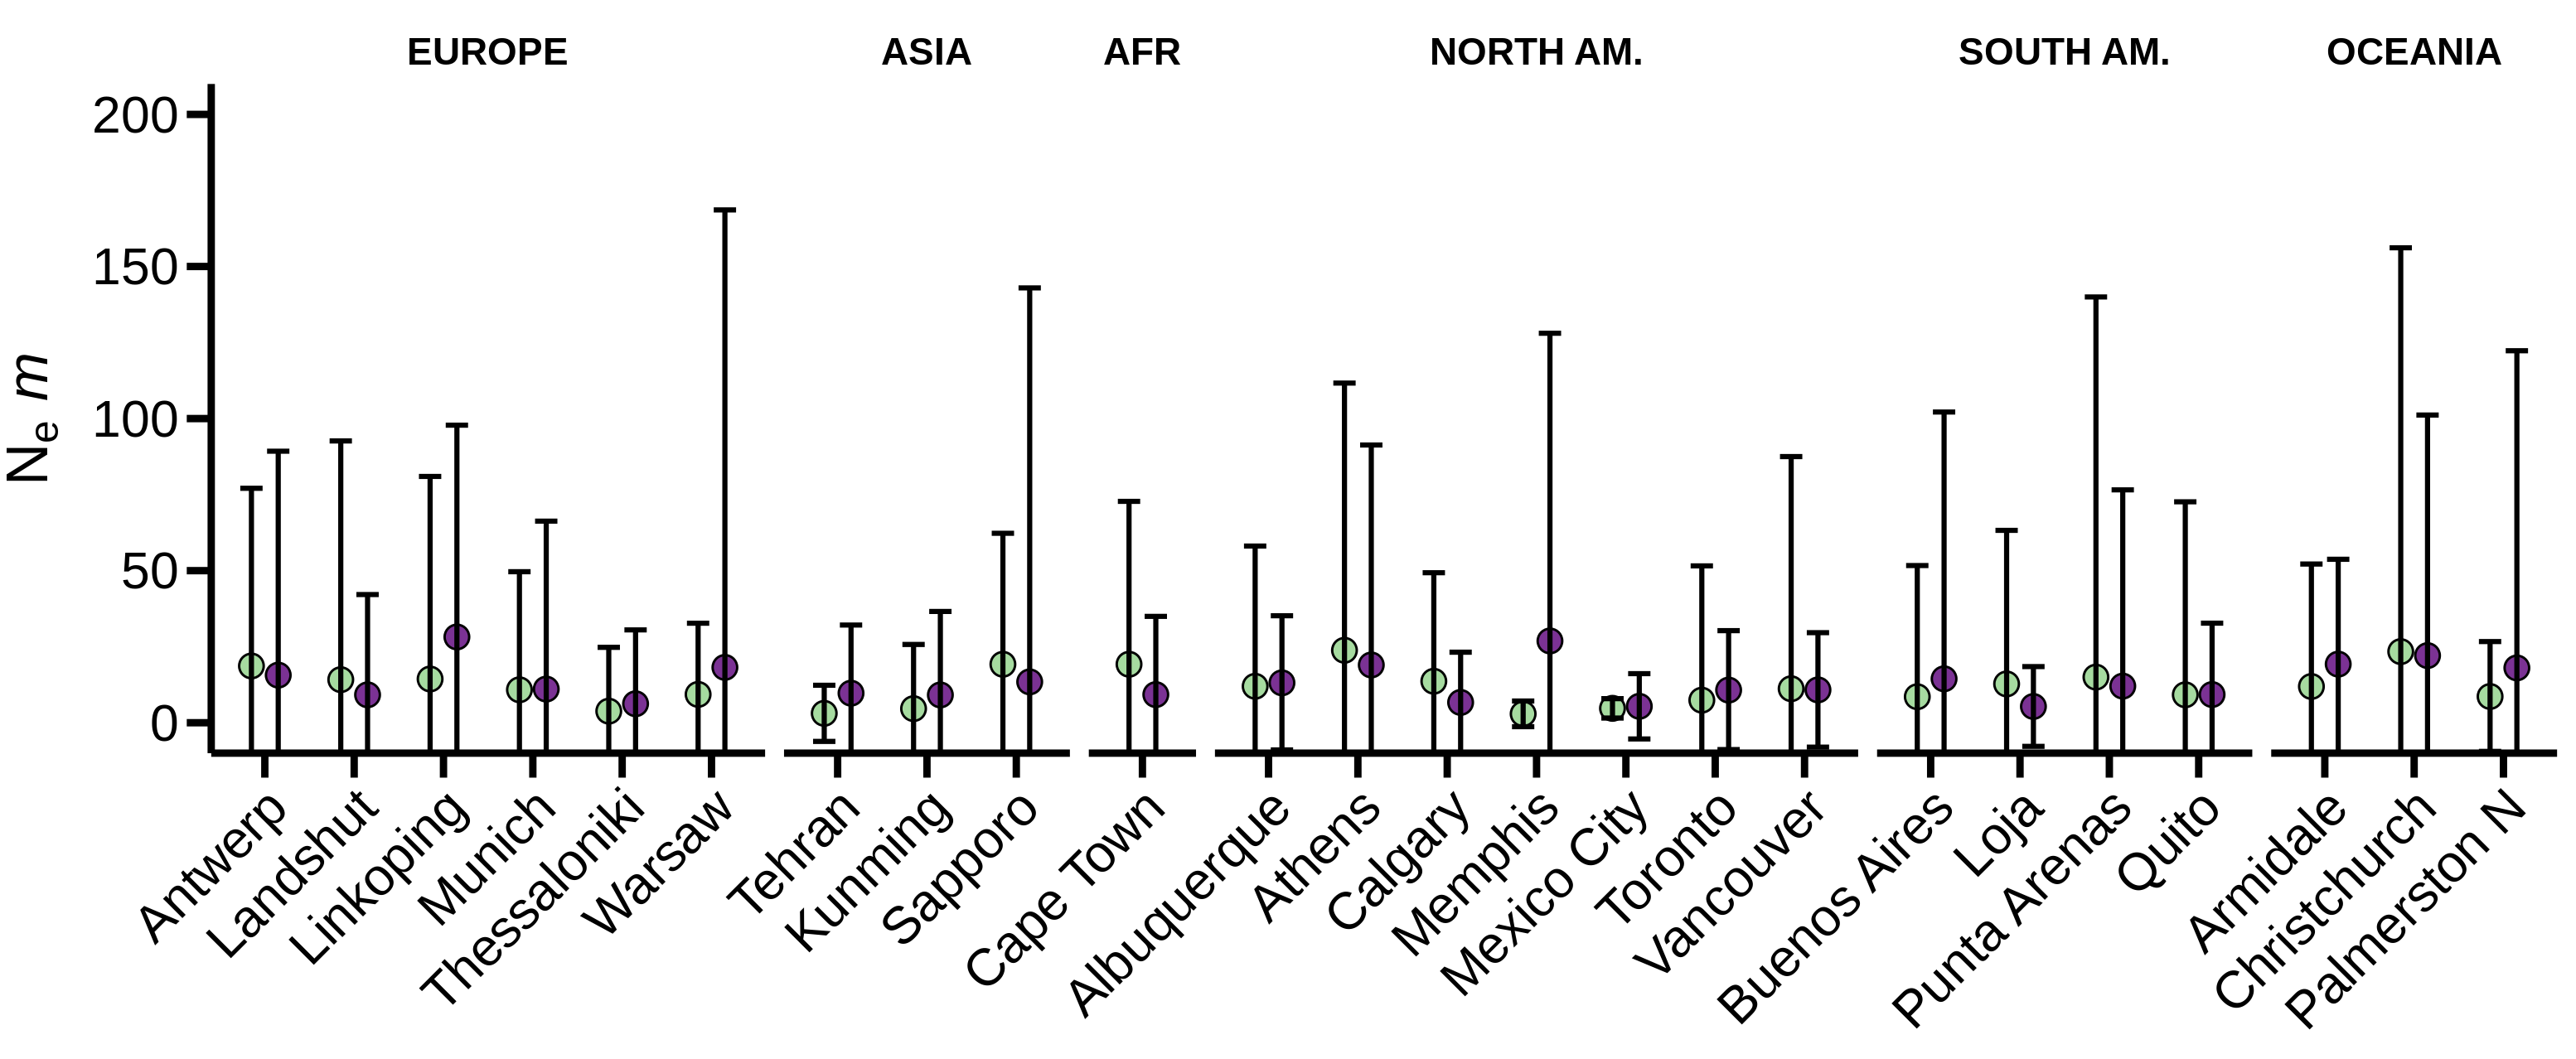

In [7]:
fst_within<-subset(fst_table, fst_table$hab_combo=="u u" | fst_table$hab_combo=="r r")
fst_within$Nm<-((1/fst_within$fst_mean)-1)/4
fst_within$Nm_sd<-((1/fst_within$fst_sd)-1)/4

head(fst_within)

NM <- fst_within %>%
  ggplot(., aes(x = factor(city, level = level_order), y = Nm, fill = hab_combo)) +
  #geom_errorbar(aes(ymax = fst_mean + fst_sd, ymin = fst_mean - fst_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 3, shape = 21, position=position_dodge(width = 0.6)) +
  geom_errorbar(aes(ymax = Nm+Nm_sd, ymin = Nm-Nm_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('R-R', 'U-U'), name="Habitat") +
  #scale_y_continuous(limits=c(0.018,0.04))+
  coord_cartesian(ylim = c(0,200)) +
  facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  #scale_y_continuous(breaks=c(-0.8,-0.6,-0.4,-0.2,0,0.2,0.4),
  #  limits = c(-0.8,0.4))+
  ng2 +
  ylab(expression('N'[e]~italic(m)))  +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12))+
  theme(legend.position = "none")  # remove if we want legent to show


ggsave(NM,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="Nm_plot.png", width = 10.36, height = 4.26, unit="in")

display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/Nm_plot.png")


## Per pop

In [2]:
#loading per por thetas
obs_div_df_per_pop <- suppressMessages(read_delim('../analyses/tables/div_popStruct/observed_urban-rural_pi_per_pop.txt.bz2', delim = '\t'))  # Observed urban-rural thetas
obs_div_df_per_pop$city<-sub("Cape", "Cape Town", obs_div_df_per_pop$city)
obs_div_df_per_pop$city<-sub("Buenos", "Buenos Aires", obs_div_df_per_pop$city)
obs_div_df_per_pop$city<-sub("Mexico", "Mexico City", obs_div_df_per_pop$city)
obs_div_df_per_pop$city<-sub("Palmerston", "Palmerston N", obs_div_df_per_pop$city)
obs_div_df_per_pop$city<-sub("Punta", "Punta Arenas", obs_div_df_per_pop$city)

## loading sample sheet
sample_sheet<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t")
sample_sheet$city<-sub("Cape_Town", "Cape Town", sample_sheet$city)
sample_sheet$city<-sub("Buenos_Aires", "Buenos Aires", sample_sheet$city)
sample_sheet$city<-sub("Mexico_City", "Mexico City", sample_sheet$city)
sample_sheet$city<-sub("Palmerston_North", "Palmerston N", sample_sheet$city)
sample_sheet$city<-sub("Punta_Arenas", "Punta Arenas", sample_sheet$city)
sample_sheet$continent<-sub("EU", "EUROPE", sample_sheet$continent)
sample_sheet$continent<-sub("ASI", "ASIA", sample_sheet$continent)
sample_sheet$continent<-sub("AFR", "AFR", sample_sheet$continent)
sample_sheet$continent<-sub("NAM", "NORTH AM.", sample_sheet$continent)
sample_sheet$continent<-sub("SAM", "SOUTH AM.", sample_sheet$continent)
sample_sheet$continent<-sub("OCE", "OCEANIA", sample_sheet$continent)
unique_sample_sheet<-unique(sample_sheet[,c('continent','city','pop','site')])

## merging the two to have habitat correspondance
pi_pop<-merge(obs_div_df_per_pop, unique_sample_sheet, by.x=c("city","population"),by.y=c("city","pop"))

## remove toronto sites that have a unique individual sampled (easy, their SD = NA)
pi_pop_clean<-na.omit(pi_pop)

write_delim(pi_pop_clean, '../analyses/tables/div_popStruct/observed_urban-rural_pi_per_pop_clean2.txt', delim = '\t')


### Split per contient (figure too wide otherwise)

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


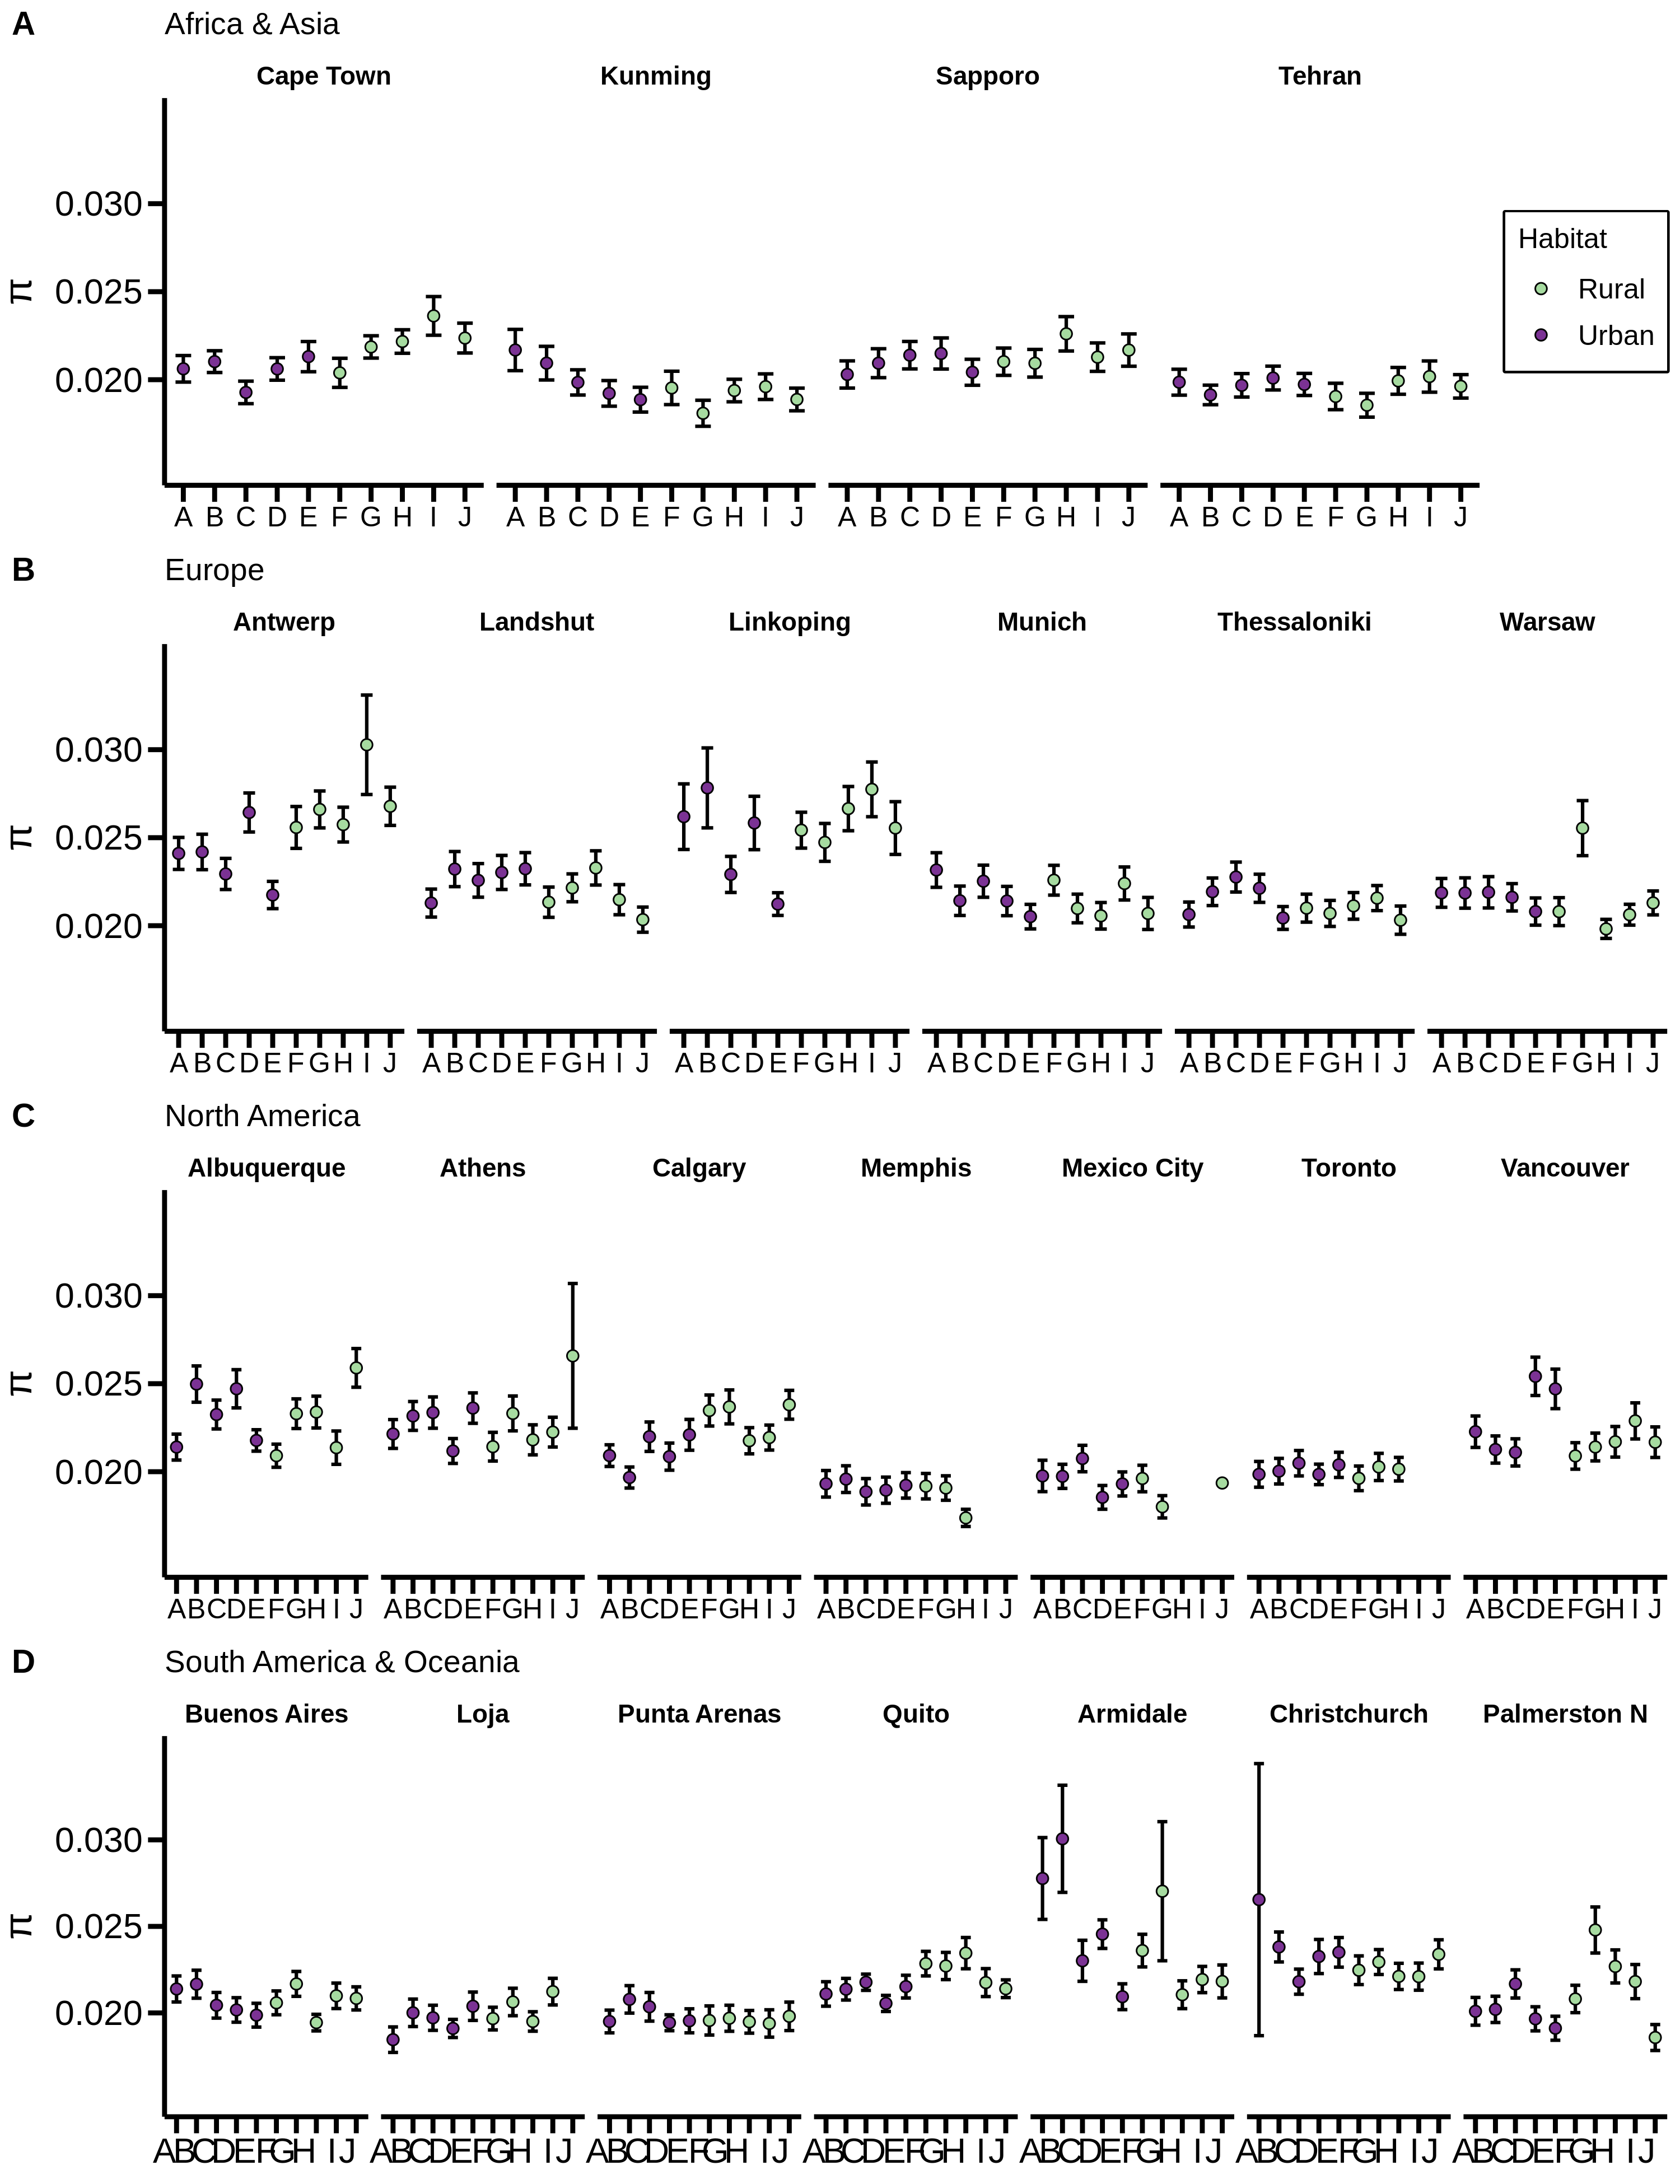

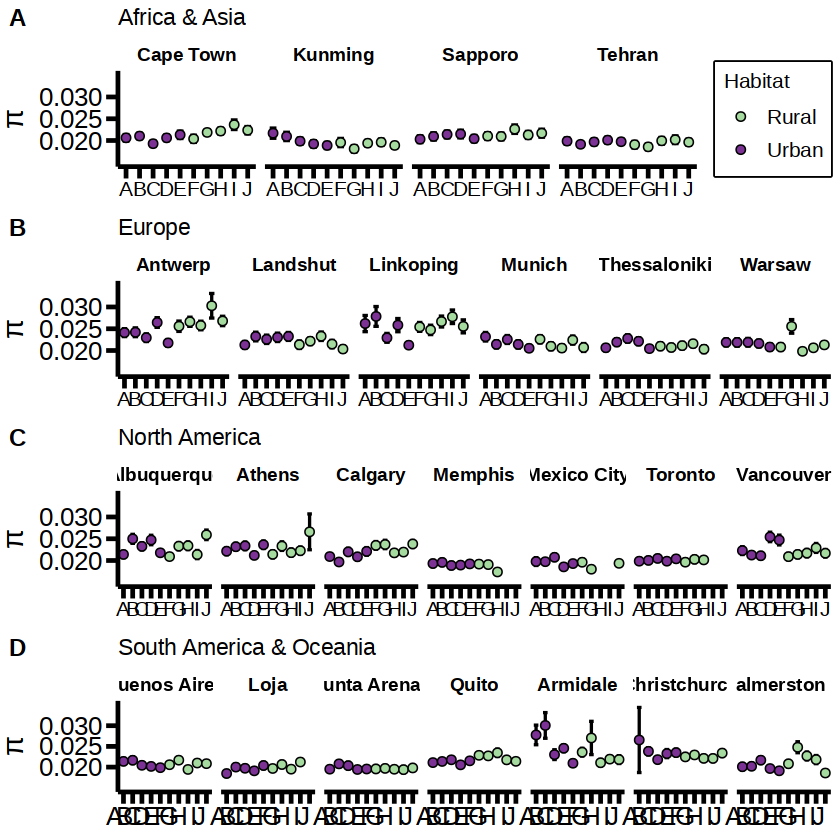

In [43]:
pi_pop_clean <- suppressMessages(read_delim('../analyses/tables/div_popStruct/observed_urban-rural_pi_per_pop_clean.txt', delim = '\t'))  # Observed urban-rural thetas
europe<-subset(pi_pop_clean, pi_pop_clean$city == "Antwerp" |  pi_pop_clean$city == "Landshut" |  pi_pop_clean$city == "Linkoping"|  pi_pop_clean$city == "Munich"|  pi_pop_clean$city == "Thessaloniki" |  pi_pop_clean$city == "Warsaw" )
level_order <- c('Antwerp', 'Landshut', 'Linkoping','Munich','Thessaloniki','Warsaw') 
#pi_pop_clean$continent_order<-factor(pi_pop_clean$continent, levels=c('EUROPE','ASIA','AFR','NORTH AM.','SOUTH AM.','OCEANIA'))
#pi_pop_clean$population<-as.character(pi_pop_clean$population)
pi_by_city_by_habitat_by_pop_europe <- europe %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = tp_mean, fill = site)) +
  geom_errorbar(aes(ymax = tp_mean+tp_sd , ymin = tp_mean-tp_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0.020,0.025,0.030),
                     limits = c(0.015,0.035))+
  ylab('\u03c0')  +
  ggtitle('Europe')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12))+
  theme(legend.position = "none")  # remove if we want legent to show
#pi_by_city_by_habitat_by_pop_europe

asiaafr<-subset(pi_pop_clean, pi_pop_clean$city == "Tehran" |  pi_pop_clean$city == "Kunming" |  pi_pop_clean$city == "Sapporo"|  pi_pop_clean$city == "Cape Town" )
level_order <- c('Tehran','Kunming','Sapporo','Cape Town') 
#pi_pop_clean$continent_order<-factor(pi_pop_clean$continent, levels=c('EUROPE','ASIA','AFR','NORTH AM.','SOUTH AM.','OCEANIA'))
#pi_pop_clean$population<-as.character(pi_pop_clean$population)

pi_by_city_by_habitat_by_pop_asiaafr <- asiaafr %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = tp_mean, fill = site)) +
  geom_errorbar(aes(ymax = tp_mean+tp_sd , ymin = tp_mean-tp_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0.020,0.025,0.030),
                     limits = c(0.015,0.035))+
  ylab('\u03c0')  +
  ggtitle('Africa & Asia')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12))+
  theme(legend.position = "right")  # remove if we want legent to show
#pi_by_city_by_habitat_by_pop_asiaafr


nam<-subset(pi_pop_clean, pi_pop_clean$city == "Albuquerque" |  pi_pop_clean$city == "Athens" |  pi_pop_clean$city == "Calgary"|  pi_pop_clean$city == "Memphis"|  pi_pop_clean$city == "Mexico City" |  pi_pop_clean$city == "Toronto"|  pi_pop_clean$city == "Vancouver" )
level_order <- c('Albuquerque','Athens','Calgary','Memphis','Mexico City', 'Toronto', 'Vancouver') 
#pi_pop_clean$continent_order<-factor(pi_pop_clean$continent, levels=c('EUROPE','ASIA','AFR','NORTH AM.','SOUTH AM.','OCEANIA'))
#pi_pop_clean$population<-as.character(pi_pop_clean$population)

pi_by_city_by_habitat_by_pop_nam <- nam %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = tp_mean, fill = site)) +
  geom_errorbar(aes(ymax = tp_mean+tp_sd , ymin = tp_mean-tp_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0.020,0.025,0.030),
                     limits = c(0.015,0.035))+
  ylab('\u03c0')  +
  ggtitle('North America')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12))+
  theme(legend.position = "none")  # remove if we want legent to show
#pi_by_city_by_habitat_by_pop_nam

sam<-subset(pi_pop_clean, pi_pop_clean$city == "Buenos Aires" |  pi_pop_clean$city == "Loja" |  pi_pop_clean$city == "Punta Arenas"|  pi_pop_clean$city == "Quito"|  pi_pop_clean$city == "Armidale" |  pi_pop_clean$city == "Christchurch"|  pi_pop_clean$city == "Palmerston N" )
sam$city <- factor(sam$city, levels = c('Buenos Aires','Loja','Punta Arenas','Quito','Armidale','Christchurch','Palmerston N'))
level_order <- c('Buenos Aires','Loja','Punta Arenas','Quito','Armidale','Christchurch','Palmerston N') 
#pi_pop_clean$continent_order<-factor(pi_pop_clean$continent, levels=c('EUROPE','ASIA','AFR','NORTH AM.','SOUTH AM.','OCEANIA'))
#pi_pop_clean$population<-as.character(pi_pop_clean$population)

pi_by_city_by_habitat_by_pop_sam <- sam %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = tp_mean, fill = site)) +
  geom_errorbar(aes(ymax = tp_mean+tp_sd , ymin = tp_mean-tp_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0.020,0.025,0.030),
                     limits = c(0.015,0.035))+
  ylab('\u03c0')  +
  ggtitle('South America & Oceania')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.text.x=element_text(size=15,hjust = 1))+
  theme(legend.position = "none")  # remove if we want legent to show
#pi_by_city_by_habitat_by_pop_sam


pipop_combined<-ggarrange(pi_by_city_by_habitat_by_pop_asiaafr,pi_by_city_by_habitat_by_pop_europe,pi_by_city_by_habitat_by_pop_nam,pi_by_city_by_habitat_by_pop_sam, ncol=1,nrow=4,labels=c("A","B","C","D"))
pipop_combined

ggsave(pipop_combined,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="pi_pop_combined.png", width = 10, height = 13, unit="in")
display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_pop_combined.png")

#ggsave(pi_by_city_by_habitat_by_pop_europe,
#    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_pop_europe.png", width = 9, height = 4.26, unit="in")
#ggsave(pi_by_city_by_habitat_by_pop_europe,
#    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_pop_europe.png", width = 9, height = 4.26, unit="in")
#ggsave(pi_by_city_by_habitat_by_pop_asiaafr,
#path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_pop_asiaafr.png", width = 6, height = 4.26, unit="in")
#ggsave(pi_by_city_by_habitat_by_pop_nam,
#    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_pop_nam.png", width = 10.5, height = 4.26, unit="in")
#ggsave(pi_by_city_by_habitat_by_pop_sam,
#    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_pop_sam.png", width = 10.5, height = 4.26, unit="in")


#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_pop_europe.png")
#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_pop_asiaafr.png")
#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_pop_nam.png")
#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_pop_sam.png")


#ggsave(pi_by_city_by_habitat_by_pop,
 #   path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
  #  filename="pi_per_pop.png", width = 20, height = 4.26, unit="in")

#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_per_pop.png")


## Plot pi

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


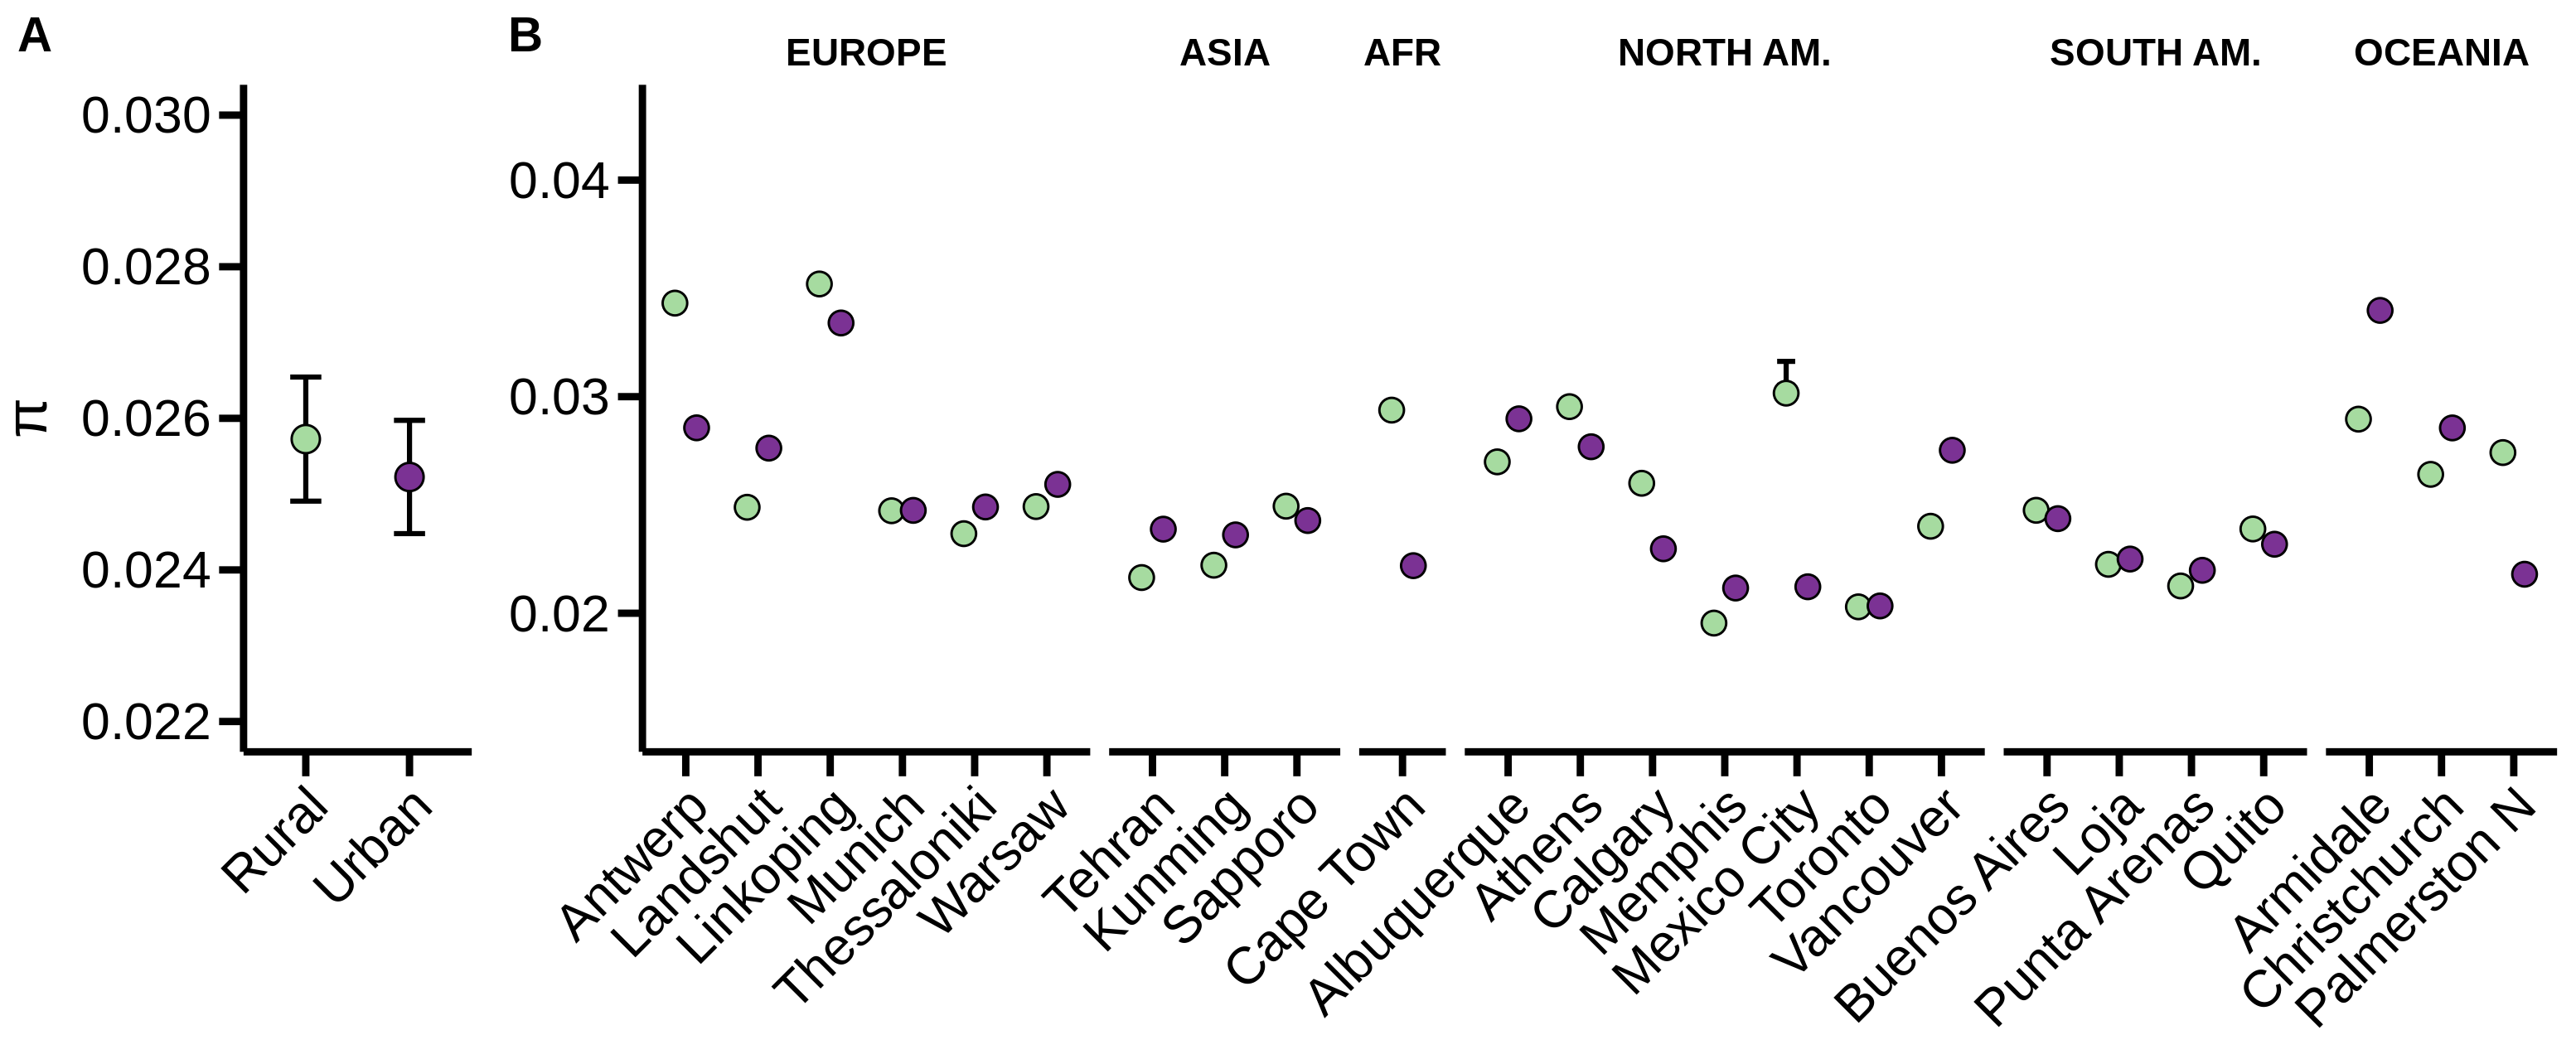

In [8]:
# Global pi
pi_by_habitat <- div_table %>% 
  group_by(habitat) %>% 
  summarise(mean = mean(tp_mean),
            sd = sd(tp_mean),
            se = sd / sqrt(n())) %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u'),
         global = rep("",2)) %>% 
  ggplot(., aes(x = habitat, y = mean, fill = habitat)) +
  geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.3, size = .7) +
  geom_point(size = 3.5, shape = 21) +
  facet_grid(~global,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0.024,0.026,0.028))+
  ylim(0.022,0.03)+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
  ylab('\u03c0')  +
  ng2 +
  theme(strip.placement ="outside", strip.background=element_rect(colour="white",fill="white"))+
  theme(legend.position = "none")

# Pi per city per habitat
pi_by_city_by_habitat <- div_table %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(city, level = level_order), y = tp_mean, fill = habitat)) +
  geom_errorbar(aes(ymax = tp_upper.bound, ymin = tp_lower.bound), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 3, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0.02,0.03,0.04),
                     limits = c(0.015,0.043))+
  #ylab('Pairwise nucleotide diversity') +
  ng2 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.title.y=element_blank())+
  theme(legend.position = "none")  # remove if we want legent to show


pi_combined<-ggarrange(pi_by_habitat,pi_by_city_by_habitat, ncol=2,nrow=1,widths=c(0.4,1.7),align="h",labels=c("A","B"))

ggsave(pi_combined,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="pi_mean_plot_CI.png", width = 10.36, height = 4.26, unit="in")

display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_mean_plot_CI.png")


## Pi per pop (splitted by continent)

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


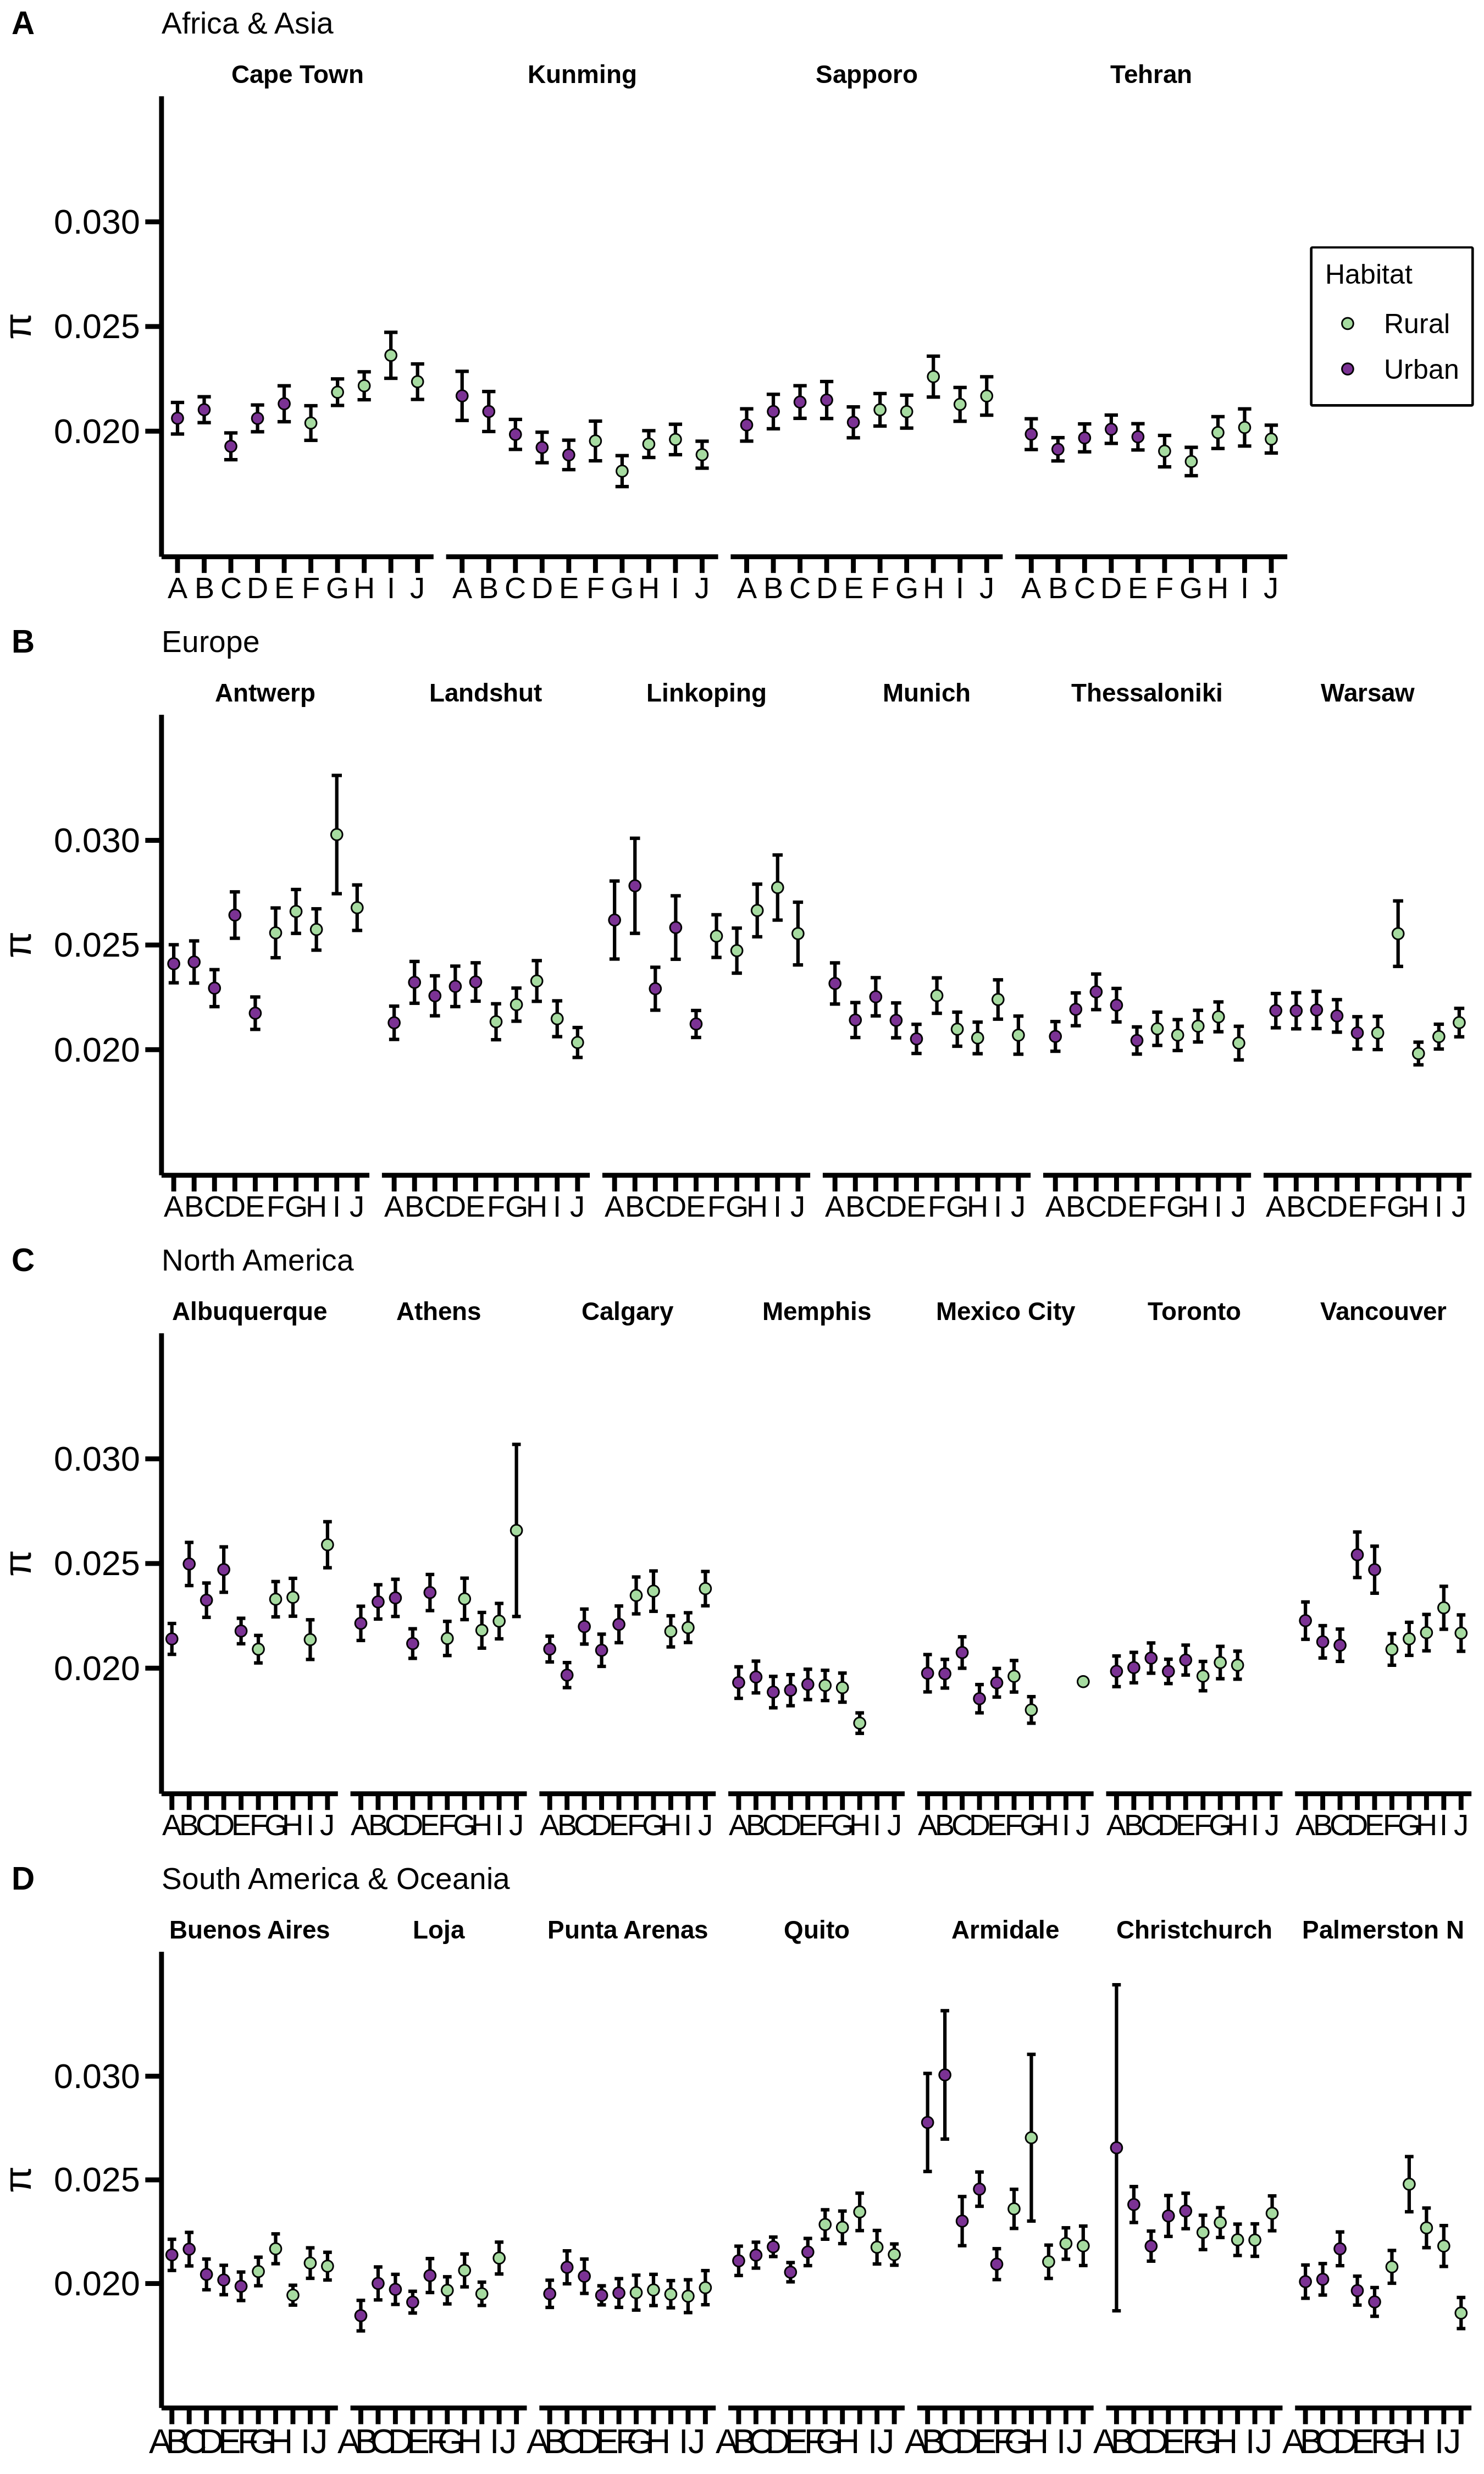

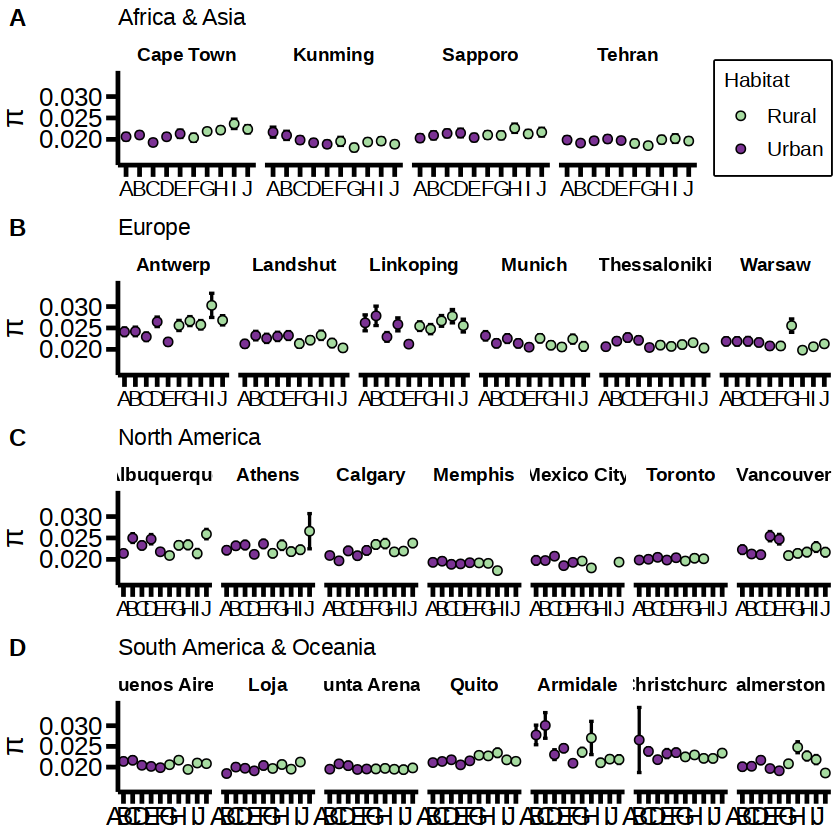

In [31]:
pi_pop_clean <- suppressMessages(read_delim('../analyses/tables/div_popStruct/observed_urban-rural_pi_per_pop_clean.txt', delim = '\t'))  # Observed urban-rural thetas
europe<-subset(pi_pop_clean, pi_pop_clean$city == "Antwerp" |  pi_pop_clean$city == "Landshut" |  pi_pop_clean$city == "Linkoping"|  pi_pop_clean$city == "Munich"|  pi_pop_clean$city == "Thessaloniki" |  pi_pop_clean$city == "Warsaw" )
level_order <- c('Antwerp', 'Landshut', 'Linkoping','Munich','Thessaloniki','Warsaw') 
#pi_pop_clean$continent_order<-factor(pi_pop_clean$continent, levels=c('EUROPE','ASIA','AFR','NORTH AM.','SOUTH AM.','OCEANIA'))
#pi_pop_clean$population<-as.character(pi_pop_clean$population)
pi_by_city_by_habitat_by_pop_europe <- europe %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = tp_mean, fill = site)) +
  geom_errorbar(aes(ymax = tp_mean+tp_sd , ymin = tp_mean-tp_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0.020,0.025,0.030),
                     limits = c(0.015,0.035))+
  ylab('\u03c0')  +
  ggtitle('Europe')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12))+
  theme(legend.position = "none")  # remove if we want legent to show
#pi_by_city_by_habitat_by_pop_europe

asiaafr<-subset(pi_pop_clean, pi_pop_clean$city == "Tehran" |  pi_pop_clean$city == "Kunming" |  pi_pop_clean$city == "Sapporo"|  pi_pop_clean$city == "Cape Town" )
level_order <- c('Tehran','Kunming','Sapporo','Cape Town') 
#pi_pop_clean$continent_order<-factor(pi_pop_clean$continent, levels=c('EUROPE','ASIA','AFR','NORTH AM.','SOUTH AM.','OCEANIA'))
#pi_pop_clean$population<-as.character(pi_pop_clean$population)

pi_by_city_by_habitat_by_pop_asiaafr <- asiaafr %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = tp_mean, fill = site)) +
  geom_errorbar(aes(ymax = tp_mean+tp_sd , ymin = tp_mean-tp_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0.020,0.025,0.030),
                     limits = c(0.015,0.035))+
  ylab('\u03c0')  +
  ggtitle('Africa & Asia')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12))+
  theme(legend.position = "right")  # remove if we want legent to show
#pi_by_city_by_habitat_by_pop_asiaafr


nam<-subset(pi_pop_clean, pi_pop_clean$city == "Albuquerque" |  pi_pop_clean$city == "Athens" |  pi_pop_clean$city == "Calgary"|  pi_pop_clean$city == "Memphis"|  pi_pop_clean$city == "Mexico City" |  pi_pop_clean$city == "Toronto"|  pi_pop_clean$city == "Vancouver" )
level_order <- c('Albuquerque','Athens','Calgary','Memphis','Mexico City', 'Toronto', 'Vancouver') 
#pi_pop_clean$continent_order<-factor(pi_pop_clean$continent, levels=c('EUROPE','ASIA','AFR','NORTH AM.','SOUTH AM.','OCEANIA'))
#pi_pop_clean$population<-as.character(pi_pop_clean$population)

pi_by_city_by_habitat_by_pop_nam <- nam %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = tp_mean, fill = site)) +
  geom_errorbar(aes(ymax = tp_mean+tp_sd , ymin = tp_mean-tp_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0.020,0.025,0.030),
                     limits = c(0.015,0.035))+
  ylab('\u03c0')  +
  ggtitle('North America')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12))+
  theme(legend.position = "none")  # remove if we want legent to show
#pi_by_city_by_habitat_by_pop_nam

sam<-subset(pi_pop_clean, pi_pop_clean$city == "Buenos Aires" |  pi_pop_clean$city == "Loja" |  pi_pop_clean$city == "Punta Arenas"|  pi_pop_clean$city == "Quito"|  pi_pop_clean$city == "Armidale" |  pi_pop_clean$city == "Christchurch"|  pi_pop_clean$city == "Palmerston N" )
sam$city <- factor(sam$city, levels = c('Buenos Aires','Loja','Punta Arenas','Quito','Armidale','Christchurch','Palmerston N'))
level_order <- c('Buenos Aires','Loja','Punta Arenas','Quito','Armidale','Christchurch','Palmerston N') 
#pi_pop_clean$continent_order<-factor(pi_pop_clean$continent, levels=c('EUROPE','ASIA','AFR','NORTH AM.','SOUTH AM.','OCEANIA'))
#pi_pop_clean$population<-as.character(pi_pop_clean$population)

pi_by_city_by_habitat_by_pop_sam <- sam %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = tp_mean, fill = site)) +
  geom_errorbar(aes(ymax = tp_mean+tp_sd , ymin = tp_mean-tp_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0.020,0.025,0.030),
                     limits = c(0.015,0.035))+
  ylab('\u03c0')  +
  ggtitle('South America & Oceania')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.text.x=element_text(size=15,hjust = 1))+
  theme(legend.position = "none")  # remove if we want legent to show
#pi_by_city_by_habitat_by_pop_sam


pipop_combined<-ggarrange(pi_by_city_by_habitat_by_pop_asiaafr,pi_by_city_by_habitat_by_pop_europe,pi_by_city_by_habitat_by_pop_nam,pi_by_city_by_habitat_by_pop_sam, ncol=1,nrow=4,labels=c("A","B","C","D"))
pipop_combined

ggsave(pipop_combined,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="pi_pop_combined.png", width = 10, height = 13, unit="in")
display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_pop_combined.png")

#ggsave(pi_by_city_by_habitat_by_pop_europe,
#    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_pop_europe.png", width = 9, height = 4.26, unit="in")
#ggsave(pi_by_city_by_habitat_by_pop_europe,
#    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_pop_europe.png", width = 9, height = 4.26, unit="in")
#ggsave(pi_by_city_by_habitat_by_pop_asiaafr,
#path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_pop_asiaafr.png", width = 6, height = 4.26, unit="in")
#ggsave(pi_by_city_by_habitat_by_pop_nam,
#    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_pop_nam.png", width = 10.5, height = 4.26, unit="in")
#ggsave(pi_by_city_by_habitat_by_pop_sam,
#    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_pop_sam.png", width = 10.5, height = 4.26, unit="in")


#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_pop_europe.png")
#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_pop_asiaafr.png")
#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_pop_nam.png")
#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_pop_sam.png")


#ggsave(pi_by_city_by_habitat_by_pop,
 #   path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
  #  filename="pi_per_pop.png", width = 20, height = 4.26, unit="in")

#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_per_pop.png")


## Plot Watterson's theta

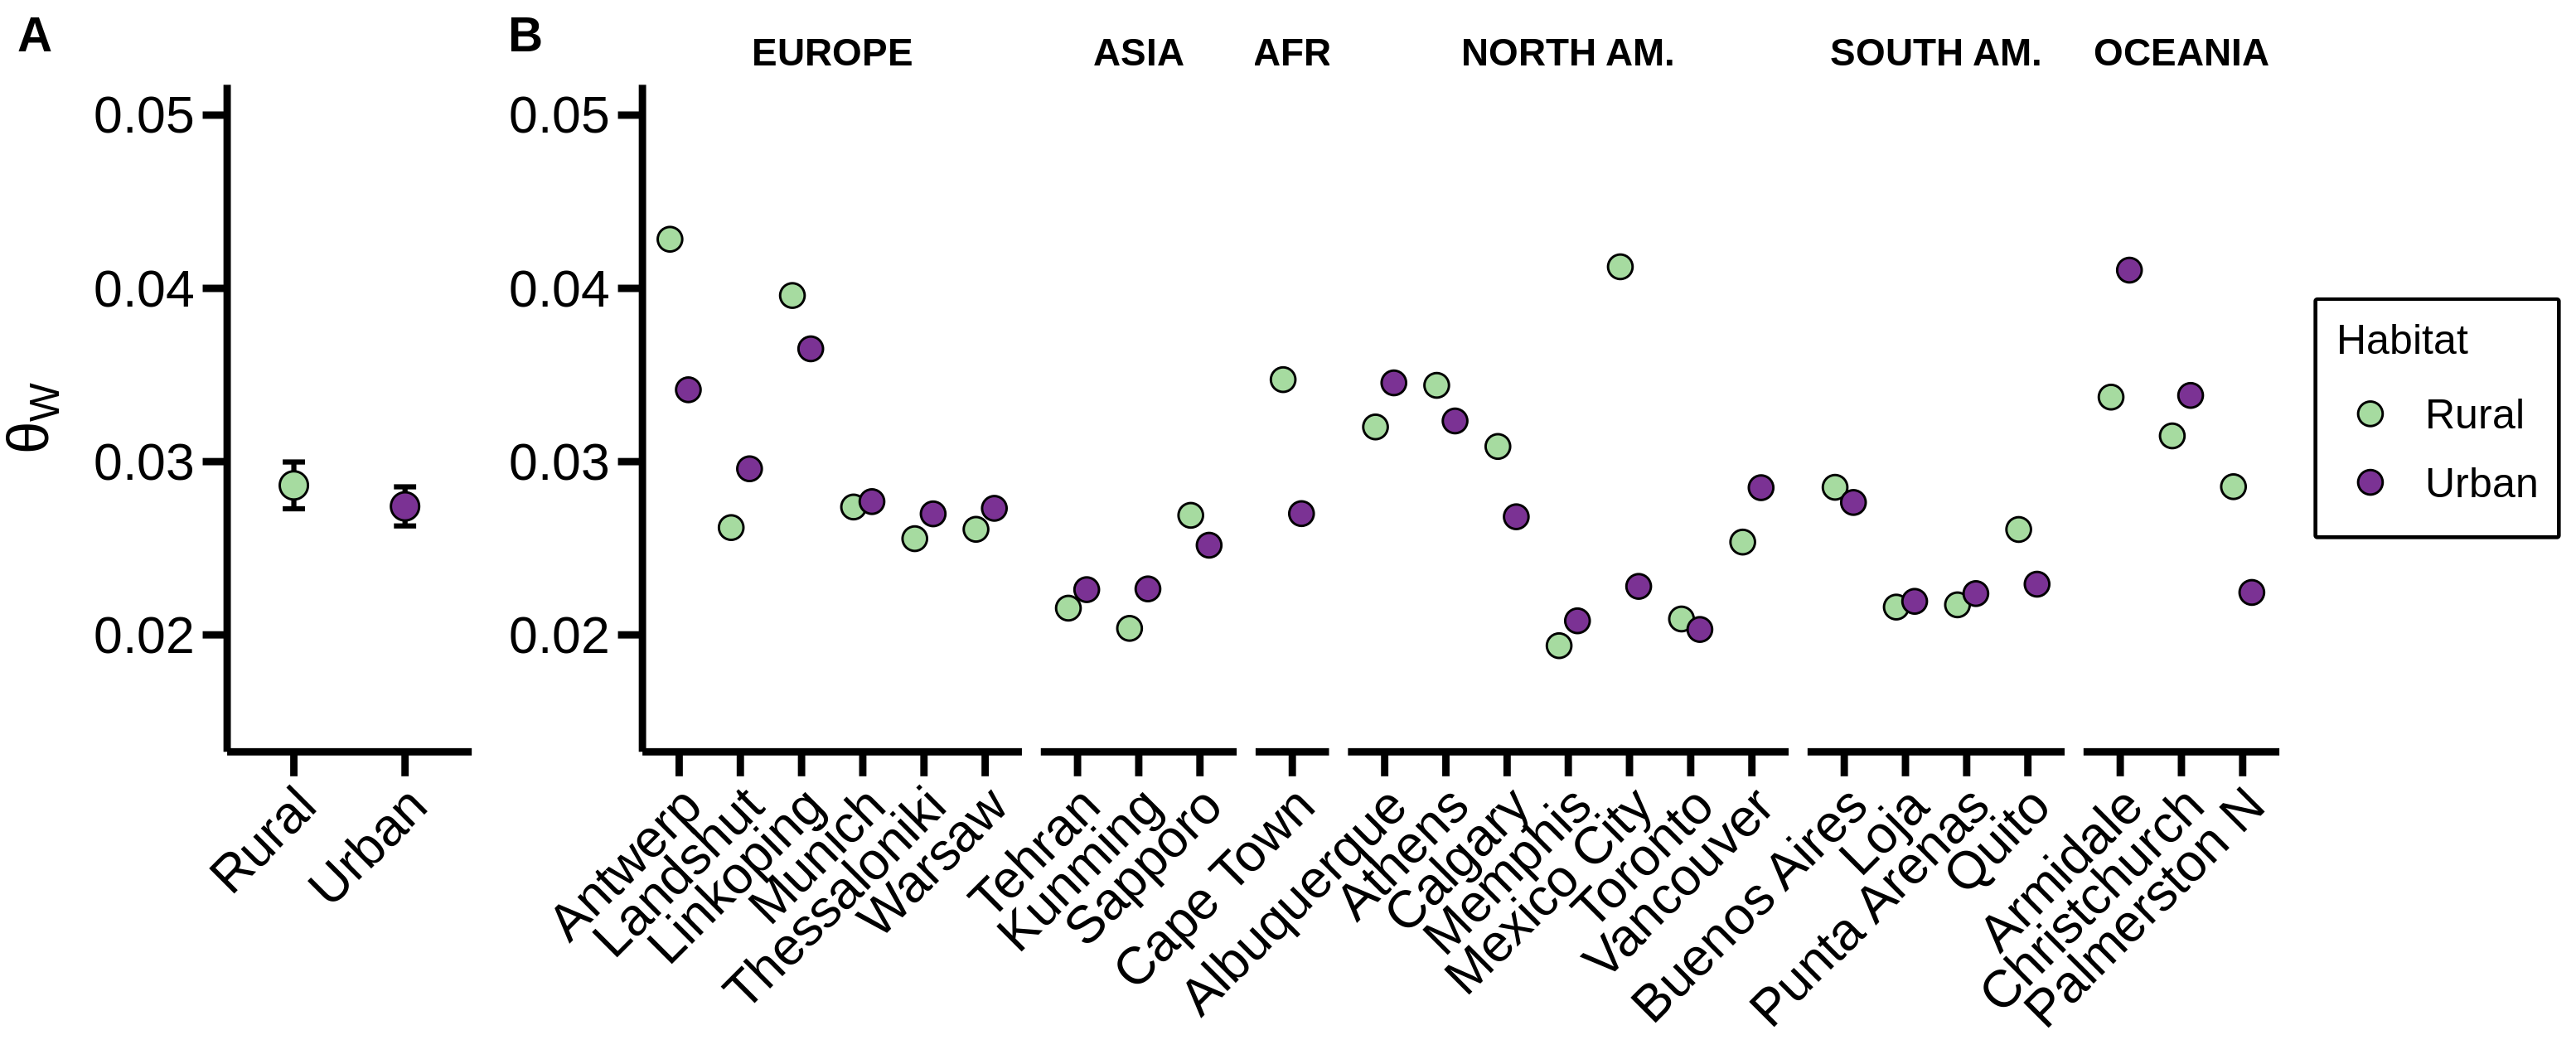

In [9]:
# Global theta
theta_by_habitat <- div_table %>% 
  group_by(habitat) %>% 
  summarise(mean = mean(tw_mean),
            sd = sd(tw_mean),
            se = sd / sqrt(n())) %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u'),
         global = rep("",2)) %>% 
  ggplot(., aes(x = habitat, y = mean, fill = habitat)) +
  geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.2, size = .7) +
  geom_point(size = 3.5, shape = 21) +
  facet_grid(~global,scales="free_x", space="free_x")+
  #scale_y_continuous(breaks=c(0.024,0.026,0.028))+
  ylim(0.015,0.05)+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
  ylab(expression("\u03B8"[W]))  +
  ng2 +
  theme(strip.placement ="outside", strip.background=element_rect(colour="white",fill="white"))+
  theme(legend.position = "none")

# theta per city per habitat
theta_by_city_by_habitat <- div_table %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(city, level = level_order), y = tw_mean, fill = habitat)) +
  geom_errorbar(aes(ymax = tw_upper.bound, ymin = tw_lower.bound), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 3, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(#breaks=c(0.02,0.03,0.04),
                     limits = c(0.015,0.05))+
  #ylab('Pairwise nucleotide diversity') +
  ng2 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.title.y=element_blank())#+
  #theme(legend.position = "none")  # remove if we want legent to show


theta_combined<-ggarrange(theta_by_habitat,theta_by_city_by_habitat, ncol=2,nrow=1,widths=c(0.4,1.7),align="h",labels=c("A","B"))


ggsave(theta_combined,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="theta_mean_plot_CI.png", width = 10.36, height = 4.26, unit="in")

display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/theta_mean_plot_CI.png")



### theta per pop

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


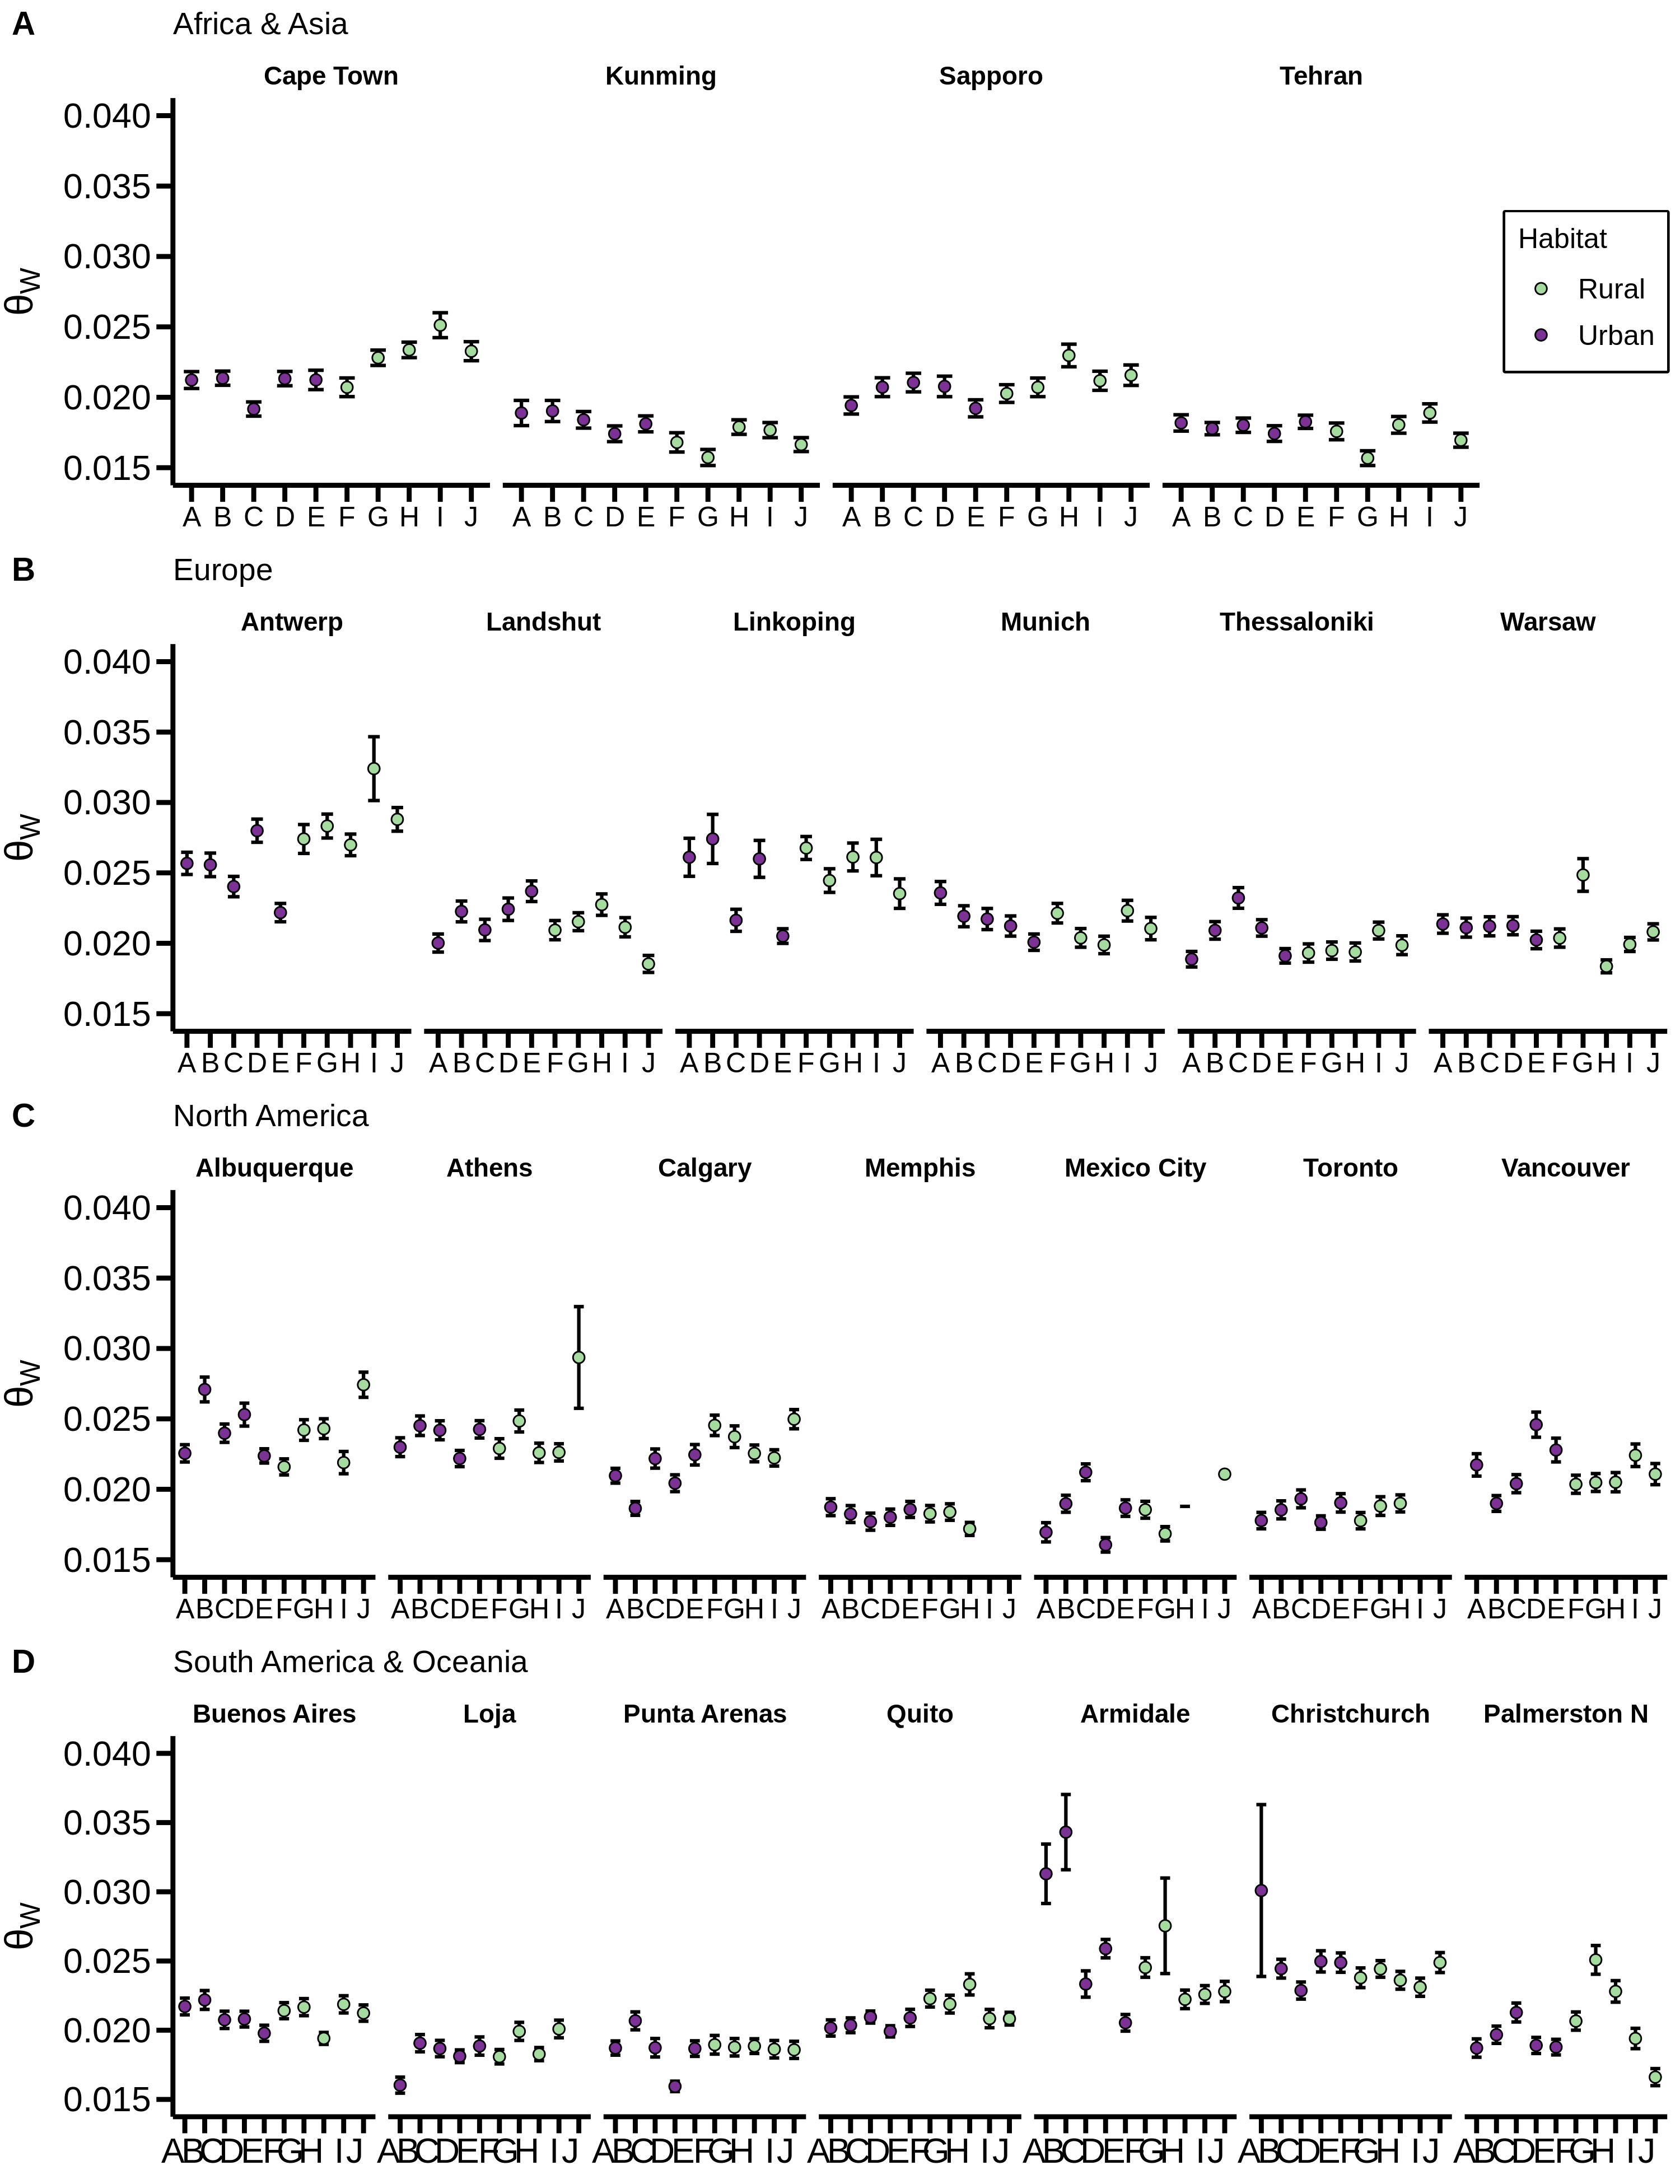

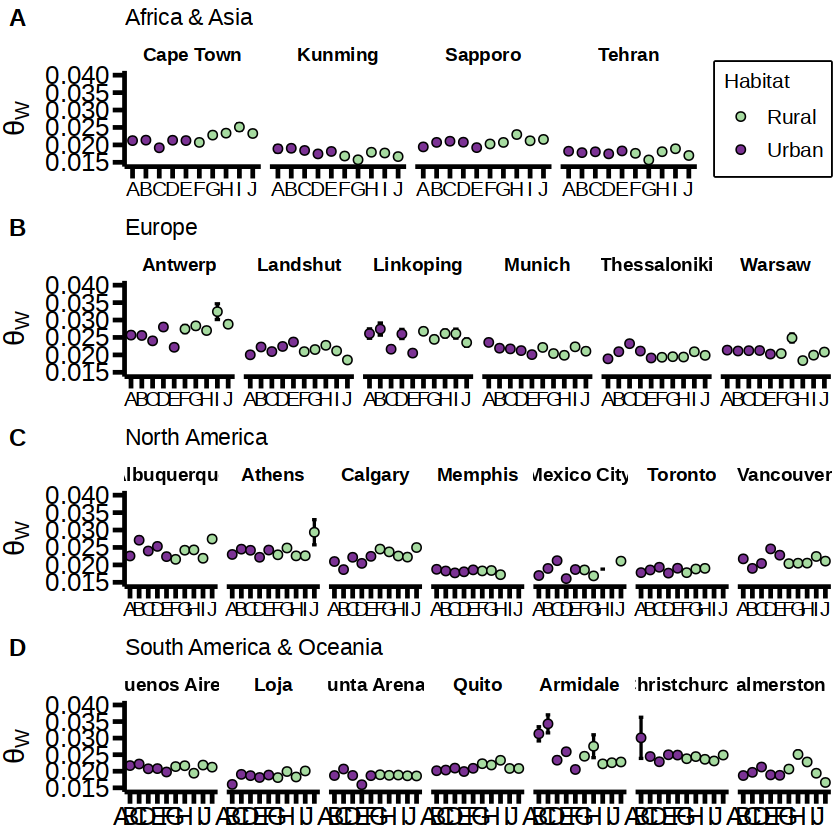

In [56]:
pi_pop_clean <- suppressMessages(read_delim('../analyses/tables/div_popStruct/observed_urban-rural_pi_per_pop_clean.txt', delim = '\t'))  # Observed urban-rural thetas
europe<-subset(pi_pop_clean, pi_pop_clean$city == "Antwerp" |  pi_pop_clean$city == "Landshut" |  pi_pop_clean$city == "Linkoping"|  pi_pop_clean$city == "Munich"|  pi_pop_clean$city == "Thessaloniki" |  pi_pop_clean$city == "Warsaw" )
level_order <- c('Antwerp', 'Landshut', 'Linkoping','Munich','Thessaloniki','Warsaw') 


theta_by_city_by_habitat_by_pop_europe <- europe %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = tw_mean, fill = site)) +
  geom_errorbar(aes(ymax = tw_mean+tw_sd , ymin = tw_mean-tw_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(limits = c(0.015,0.040))+
  ylab(expression("\u03B8"[W]))  +
  ggtitle('Europe')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12))+
  theme(legend.position = "none")  # remove if we want legent to show

asiaafr<-subset(pi_pop_clean, pi_pop_clean$city == "Tehran" |  pi_pop_clean$city == "Kunming" |  pi_pop_clean$city == "Sapporo"|  pi_pop_clean$city == "Cape Town" )
level_order <- c('Tehran','Kunming','Sapporo','Cape Town') 


theta_by_city_by_habitat_by_pop_asiaafr <- asiaafr %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = tw_mean, fill = site)) +
  geom_errorbar(aes(ymax = tw_mean+tw_sd , ymin = tw_mean-tw_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(limits = c(0.015,0.040))+
  ylab(expression("\u03B8"[W]))  +
  ggtitle('Africa & Asia')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12))+
  theme(legend.position = "right") 


nam<-subset(pi_pop_clean, pi_pop_clean$city == "Albuquerque" |  pi_pop_clean$city == "Athens" |  pi_pop_clean$city == "Calgary"|  pi_pop_clean$city == "Memphis"|  pi_pop_clean$city == "Mexico City" |  pi_pop_clean$city == "Toronto"|  pi_pop_clean$city == "Vancouver" )
level_order <- c('Albuquerque','Athens','Calgary','Memphis','Mexico City', 'Toronto', 'Vancouver') 

theta_by_city_by_habitat_by_pop_nam <- nam %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = tw_mean, fill = site)) +
  geom_errorbar(aes(ymax = tw_mean+tw_sd , ymin = tw_mean-tw_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(limits = c(0.015,0.04))+
  ylab(expression("\u03B8"[W]))  +
  ggtitle('North America')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12))+
  theme(legend.position = "none")  # remove if we want legent to show
#pi_by_city_by_habitat_by_pop_nam

sam<-subset(pi_pop_clean, pi_pop_clean$city == "Buenos Aires" |  pi_pop_clean$city == "Loja" |  pi_pop_clean$city == "Punta Arenas"|  pi_pop_clean$city == "Quito"|  pi_pop_clean$city == "Armidale" |  pi_pop_clean$city == "Christchurch"|  pi_pop_clean$city == "Palmerston N" )
sam$city <- factor(sam$city, levels = c('Buenos Aires','Loja','Punta Arenas','Quito','Armidale','Christchurch','Palmerston N'))
level_order <- c('Buenos Aires','Loja','Punta Arenas','Quito','Armidale','Christchurch','Palmerston N') 

theta_by_city_by_habitat_by_pop_sam <- sam %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = tw_mean, fill = site)) +
  geom_errorbar(aes(ymax = tw_mean+tw_sd , ymin = tw_mean-tw_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(limits = c(0.015,0.040))+
  ylab(expression("\u03B8"[W]))  +
  ggtitle('South America & Oceania')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.text.x=element_text(size=15,hjust = 1))+
  theme(legend.position = "none")  # remove if we want legent to show



thetapop_combined<-ggarrange(theta_by_city_by_habitat_by_pop_asiaafr,theta_by_city_by_habitat_by_pop_europe,theta_by_city_by_habitat_by_pop_nam,theta_by_city_by_habitat_by_pop_sam, ncol=1,nrow=4,labels=c("A","B","C","D"))
thetapop_combined

ggsave(thetapop_combined,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="theta_pop_combined.png", width = 10, height = 13, unit="in")
display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/theta_pop_combined.png")

#ggsave(pi_by_city_by_habitat_by_pop_europe,
#    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_pop_europe.png", width = 9, height = 4.26, unit="in")
#ggsave(pi_by_city_by_habitat_by_pop_europe,
#    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_pop_europe.png", width = 9, height = 4.26, unit="in")
#ggsave(pi_by_city_by_habitat_by_pop_asiaafr,
#path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_pop_asiaafr.png", width = 6, height = 4.26, unit="in")
#ggsave(pi_by_city_by_habitat_by_pop_nam,
#    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_pop_nam.png", width = 10.5, height = 4.26, unit="in")
#ggsave(pi_by_city_by_habitat_by_pop_sam,
#    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_pop_sam.png", width = 10.5, height = 4.26, unit="in")


#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_pop_europe.png")
#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_pop_asiaafr.png")
#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_pop_nam.png")
#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_pop_sam.png")


#ggsave(pi_by_city_by_habitat_by_pop,
 #   path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
  #  filename="pi_per_pop.png", width = 20, height = 4.26, unit="in")

#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_per_pop.png")



## Plot Tajima's D

In [58]:
## Plot Tajima's D
# Global Dtaj
taj_by_habitat <- div_table %>% 
  group_by(habitat) %>% 
  summarise(mean = mean(taj),
            sd = sd(taj),
            se = sd / sqrt(n())) %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u'),
         global = rep("",2)) %>% 
  ggplot(., aes(x = habitat, y = mean, fill = habitat)) +
  geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.2, size = .7) +
  geom_point(size = 3.5, shape = 21) +
  facet_grid(~global,scales="free_x", space="free_x")+
  #scale_y_continuous(breaks=c(0.024,0.026,0.028))+
  ylim(-0.6,0.1)+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
  ylab(expression(D[taj]))  +
  ng2 +
  theme(strip.placement ="outside", strip.background=element_rect(colour="white",fill="white"))+
  theme(legend.position = "none")

# theta per city per habitat
taj_by_city_by_habitat <- div_table %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(city, level = level_order), y = taj, fill = habitat)) +
  geom_errorbar(aes(ymax = taj_upper.bound, ymin = taj_lower.bound), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 3, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(-0.8,-0.6,-0.4,-0.2,0,0.2,0.4),
    limits = c(-0.8,0.4))+
  ng2 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.title.y=element_blank())+
  theme(legend.position = "none")  # remove if we want legent to show


taj_combined<-ggarrange(taj_by_habitat,taj_by_city_by_habitat, ncol=2,nrow=1,widths=c(0.4,1.7),align="h",labels=c("A","B"))

ggsave(taj_combined,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="tajima_mean_plot_CI.png", width = 10.36, height = 4.26, unit="in")

display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/tajima_mean_plot_CI.png")


ERROR: Error in group_by(., habitat): objet 'div_table' introuvable


### Taj D per pop

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


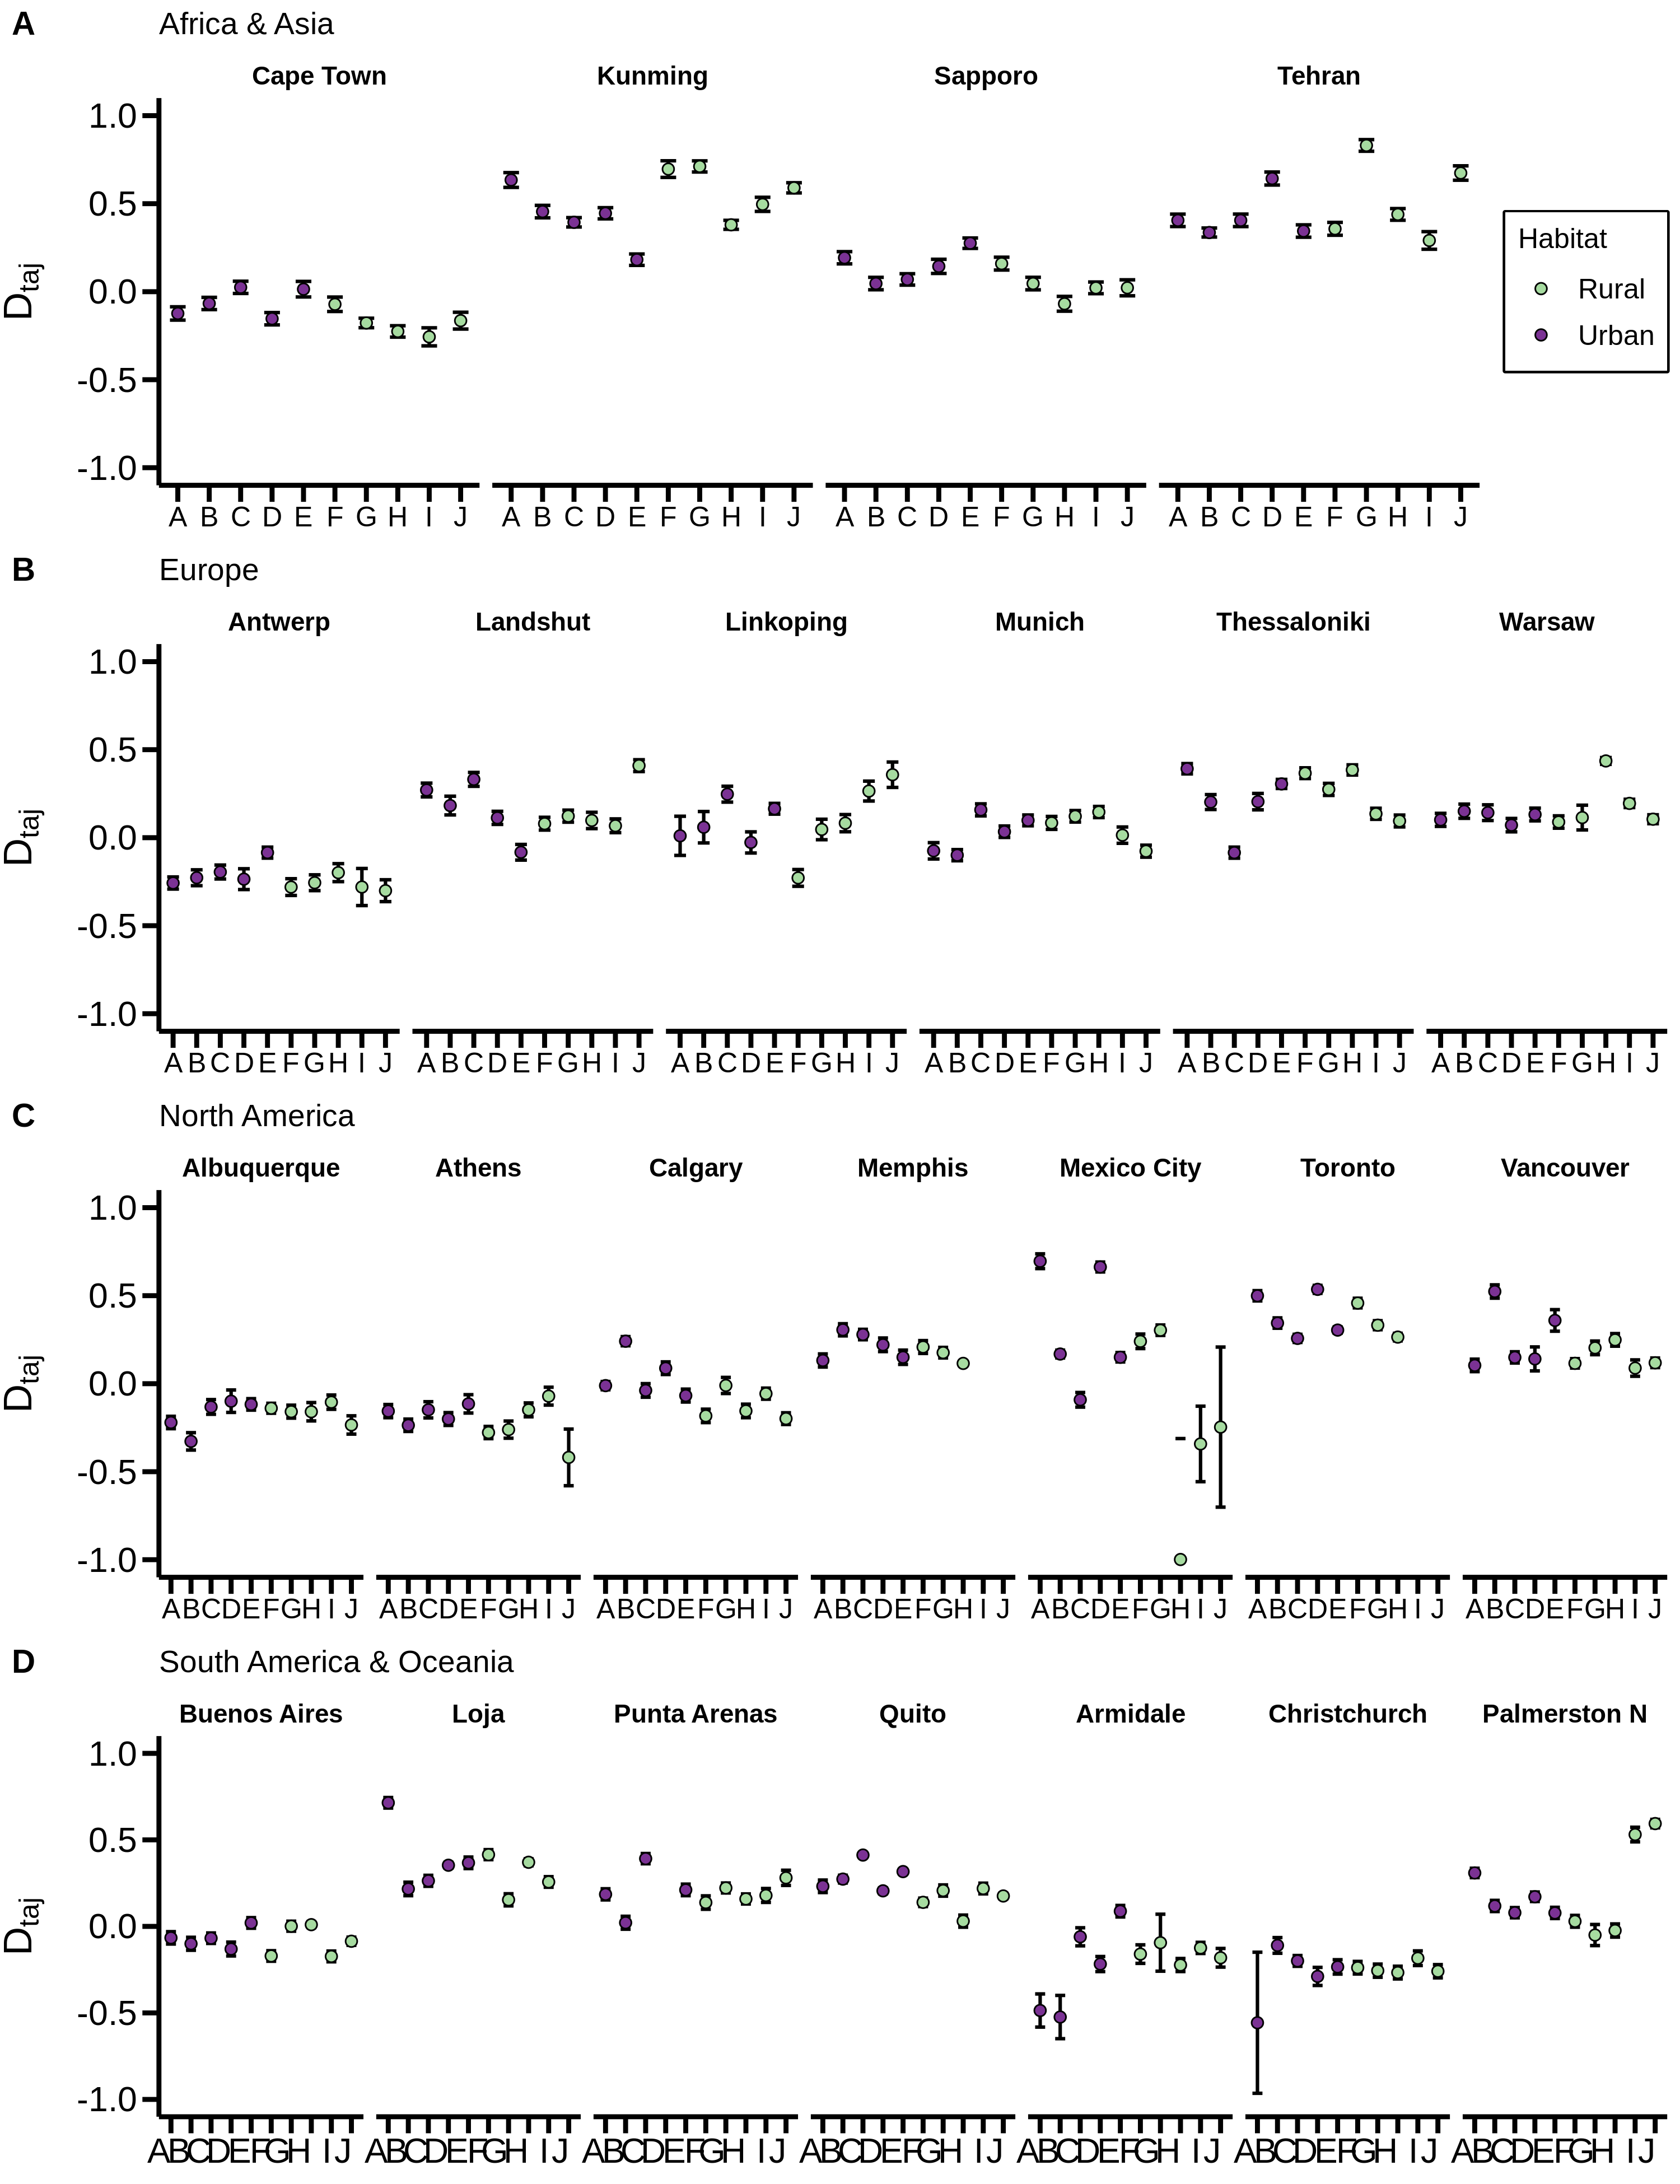

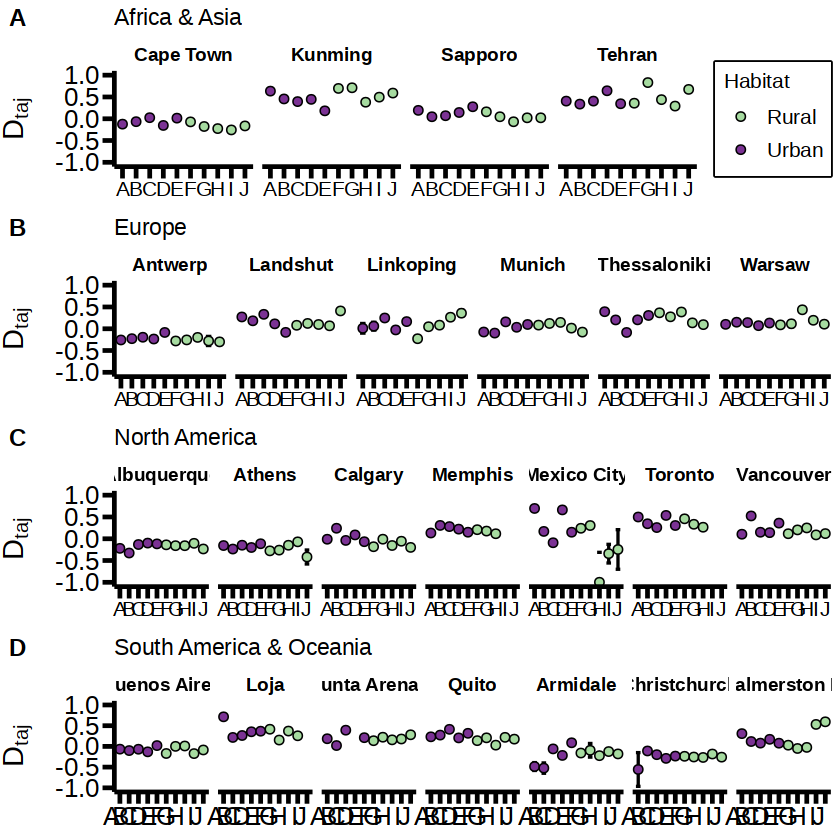

In [59]:
pi_pop_clean <- suppressMessages(read_delim('../analyses/tables/div_popStruct/observed_urban-rural_pi_per_pop_clean.txt', delim = '\t'))  # Observed urban-rural thetas
europe<-subset(pi_pop_clean, pi_pop_clean$city == "Antwerp" |  pi_pop_clean$city == "Landshut" |  pi_pop_clean$city == "Linkoping"|  pi_pop_clean$city == "Munich"|  pi_pop_clean$city == "Thessaloniki" |  pi_pop_clean$city == "Warsaw" )
level_order <- c('Antwerp', 'Landshut', 'Linkoping','Munich','Thessaloniki','Warsaw') 


taj_by_city_by_habitat_by_pop_europe <- europe %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = taj, fill = site)) +
  geom_errorbar(aes(ymax = taj+taj_sd , ymin = taj-taj_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(limits = c(-1,1))+
  ylab(expression(D[taj]))  +
  ggtitle('Europe')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12))+
  theme(legend.position = "none")  # remove if we want legent to show

asiaafr<-subset(pi_pop_clean, pi_pop_clean$city == "Tehran" |  pi_pop_clean$city == "Kunming" |  pi_pop_clean$city == "Sapporo"|  pi_pop_clean$city == "Cape Town" )
level_order <- c('Tehran','Kunming','Sapporo','Cape Town') 


taj_by_city_by_habitat_by_pop_asiaafr <- asiaafr %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = taj, fill = site)) +
  geom_errorbar(aes(ymax = taj+taj_sd , ymin = taj-taj_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(limits = c(-1,1))+
  ylab(expression(D[taj]))  +
  ggtitle('Africa & Asia')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12))+
  theme(legend.position = "right") 


nam<-subset(pi_pop_clean, pi_pop_clean$city == "Albuquerque" |  pi_pop_clean$city == "Athens" |  pi_pop_clean$city == "Calgary"|  pi_pop_clean$city == "Memphis"|  pi_pop_clean$city == "Mexico City" |  pi_pop_clean$city == "Toronto"|  pi_pop_clean$city == "Vancouver" )
level_order <- c('Albuquerque','Athens','Calgary','Memphis','Mexico City', 'Toronto', 'Vancouver') 

taj_by_city_by_habitat_by_pop_nam <- nam %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = taj, fill = site)) +
  geom_errorbar(aes(ymax = taj+taj_sd , ymin = taj-taj_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(limits = c(-1,1))+
  ylab(expression(D[taj]))  +
  ggtitle('North America')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12))+
  theme(legend.position = "none")  # remove if we want legent to show
#pi_by_city_by_habitat_by_pop_nam

sam<-subset(pi_pop_clean, pi_pop_clean$city == "Buenos Aires" |  pi_pop_clean$city == "Loja" |  pi_pop_clean$city == "Punta Arenas"|  pi_pop_clean$city == "Quito"|  pi_pop_clean$city == "Armidale" |  pi_pop_clean$city == "Christchurch"|  pi_pop_clean$city == "Palmerston N" )
sam$city <- factor(sam$city, levels = c('Buenos Aires','Loja','Punta Arenas','Quito','Armidale','Christchurch','Palmerston N'))
level_order <- c('Buenos Aires','Loja','Punta Arenas','Quito','Armidale','Christchurch','Palmerston N') 

taj_by_city_by_habitat_by_pop_sam <- sam %>% 
  mutate(habitat = fct_recode(site, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(population), y = taj, fill = site)) +
  geom_errorbar(aes(ymax = taj+taj_sd , ymin = taj-taj_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 2, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  facet_grid(. ~ city)+
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  #facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(limits = c(-1,1))+
  ylab(expression(D[taj]))  +
  ggtitle('South America & Oceania')+
  #ylab('Pairwise nucleotide diversity') +
  ng3 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.text.x=element_text(size=15,hjust = 1))+
  theme(legend.position = "none")  # remove if we want legent to show



tajpop_combined<-ggarrange(taj_by_city_by_habitat_by_pop_asiaafr,taj_by_city_by_habitat_by_pop_europe,taj_by_city_by_habitat_by_pop_nam,taj_by_city_by_habitat_by_pop_sam, ncol=1,nrow=4,labels=c("A","B","C","D"))
tajpop_combined

ggsave(tajpop_combined,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="taj_pop_combined.pdf", width = 10, height = 13, unit="in")
display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/taj_pop_combined.png")


## Plot Fst

In [33]:
uu_col <- "#7b3294"
rr_col <- "#a6dba0"
ur_col<-"black"

cols <- c(uu_col,  ur_col,rr_col)
fst_table2<-subset(fst_table,fst_table$hab_combo!="global")

# Global Fst
fst_by_hab_combo <- fst_table2 %>% 
  group_by(hab_combo) %>% 
      summarise(mean = mean(fst_mean),
            sd = sd(fst_mean),
            se = sd / sqrt(n())) %>% 
    mutate(hab_combo = fct_recode(hab_combo,'R-R' = 'r r', 'U-U' = 'u u','R-U' = 'r u'),
         global = rep("",3)) %>% 
  ggplot(., aes(x = hab_combo, y = mean, fill = hab_combo)) +
  geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.2, size = .7) +
  geom_point(size = 3.5, shape = 21) +
  facet_grid(~global,scales="free_x", space="free_x")+
  #scale_y_continuous(breaks=c(0.024,0.026,0.028))+
  #ylim(-0.6,0.1)+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
  ylab(expression(F[ST]))  +
  ng2 +
  theme(strip.placement ="outside", strip.background=element_rect(colour="white",fill="white"))+
  theme(legend.position = "none")

# FST per city per hab_combo  
fst_by_city_by_hab_combo <- fst_table2 %>%
  ggplot(., aes(x = factor(city, level = level_order), y = fst_mean, fill = hab_combo)) +
  #geom_errorbar(aes(ymax = fst_mean + fst_sd, ymin = fst_mean - fst_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 3, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('R-R', 'R-U', 'U-U'), name="Habitat Combination") +
  #scale_y_continuous(limits=c(0.018,0.04))+
  coord_cartesian(ylim = c(0,0.1)) +
  facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  #scale_y_continuous(breaks=c(-0.8,-0.6,-0.4,-0.2,0,0.2,0.4),
  #  limits = c(-0.8,0.4))+
  ng2 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.title.y=element_blank())+
  theme(legend.position = "none")  # remove if we want legent to show


fst_combined<-ggarrange(fst_by_hab_combo,fst_by_city_by_hab_combo, ncol=2,nrow=1,widths=c(0.4,1.7),align="h",labels=c("A","B"))

ggsave(fst_combined,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="fst_mean_plot.png", width = 10.36, height = 4.26, unit="in")

display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/fst_mean_plot.png")


ERROR: Error in subset(fst_table, fst_table$hab_combo != "global"): objet 'fst_table' introuvable


## Relatedness

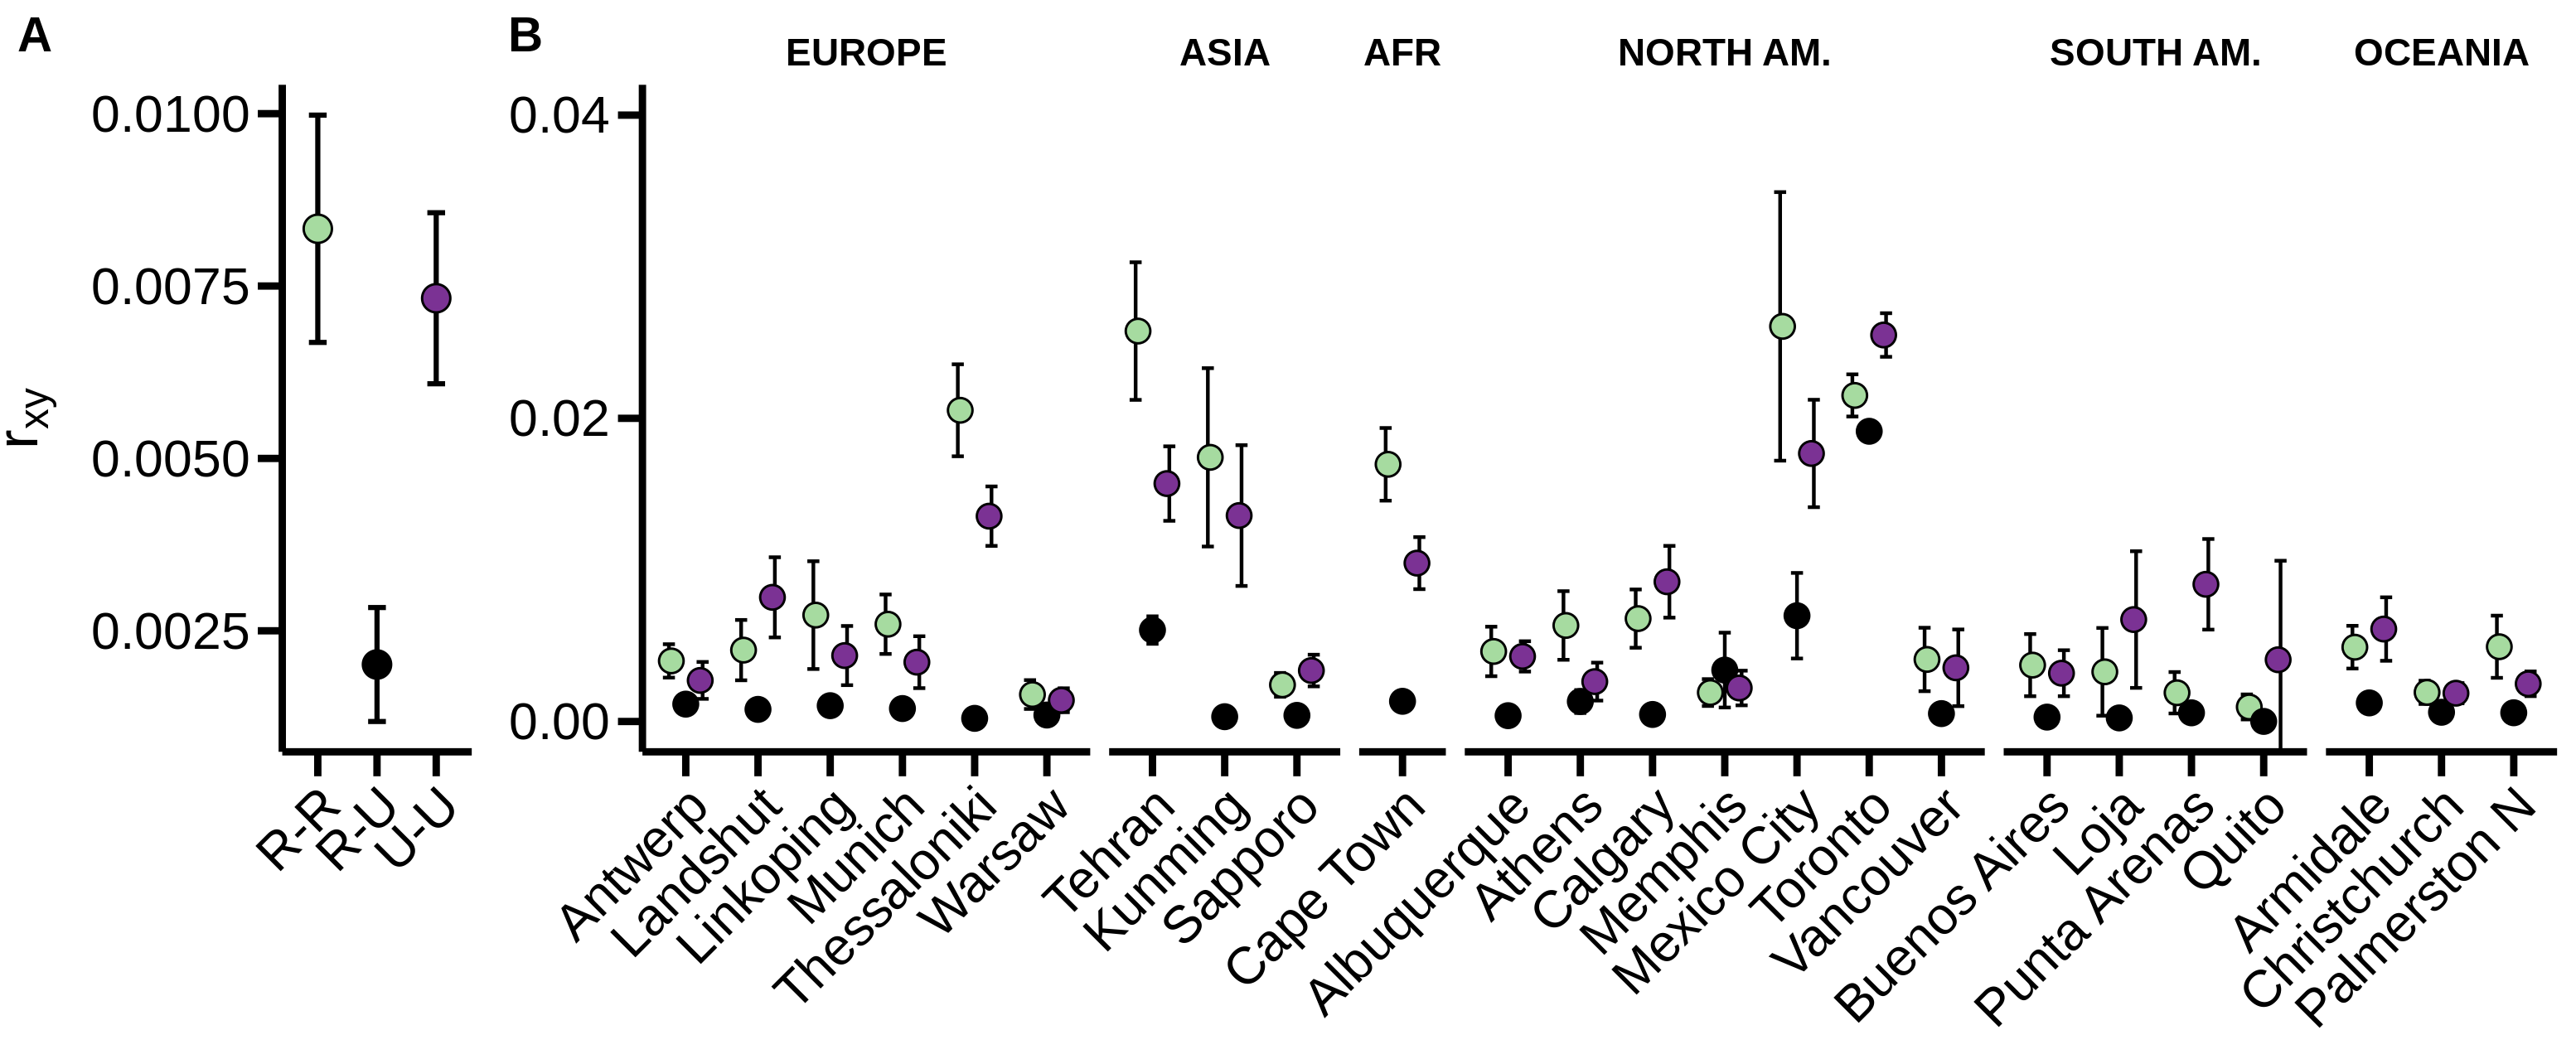

In [12]:
urban_col <- "#7b3294"
rural_col <- "#a6dba0"
ur_col<-"black"
cols <- c( urban_col, ur_col, rural_col )
# Global rab
rab_by_habitat <- inbr_table %>% 
  group_by(habitat_combo) %>% 
  summarise(mean = mean(rab),
            sd = sd(rab),
            se = sd / sqrt(n())) %>% 
  mutate(habitat_combo = fct_recode(habitat_combo, 'R-R' = 'rr', 'U-U' = 'uu', 'R-U' = 'ru'),
         global = rep("",3)) %>% 
  ggplot(., aes(x = habitat_combo, y = mean, fill = habitat_combo)) +
  geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.3, size = .7) +
  geom_point(size = 3.5, shape = 21) +
  facet_grid(~global,scales="free_x", space="free_x")+
  #coord_cartesian(ylim = c(0,0.1)) +
  #scale_y_continuous(breaks=c(0,0.02,0.04,0.06,0.08,0.1))+
  #scale_y_continuous(breaks=c(0.024,0.026,0.028))+
  #ylim(0.022,0.03)+
  scale_fill_manual(values = rev(cols), labels = c('R-R', 'U-U','R-U')) +
  ylab(expression(r[xy]))  +
  ng2 +
  theme(strip.placement ="outside", strip.background=element_rect(colour="white",fill="white"))+
  theme(legend.position = "none")

# rab per city per habitat
rab_by_city_by_habitat <- inbr_table %>% 
  mutate(habitat_combo = fct_recode(habitat_combo, 'R-R' = 'rr', 'U-U' = 'uu', 'R-U' = 'ru')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(city, level = level_order), y = rab, fill = habitat_combo)) +
  geom_errorbar(aes(ymax = rab_upper, ymin = rab_lower), width = 0.5, size = 0.5, position=position_dodge(width = 0.7)) +
  geom_point(size = 3, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('R-R', 'R-U', 'U-U'), name="Habitat Combination") +
  #scale_y_continuous(limits=c(0.018,0.04))+
  coord_cartesian(ylim = c(0,0.04)) +
  facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0,0.02,0.04))+
  ng2 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.title.y=element_blank())+
  theme(legend.position = "none")  # remove if we want legent to show

rab_combined<-ggarrange(rab_by_habitat,rab_by_city_by_habitat, ncol=2,nrow=1,widths=c(0.4,1.7),align="h",labels=c("A","B"))

ggsave(rab_combined,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="rab_mean_plot.png", width = 10.36, height = 4.26, unit="in")

display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/rab_mean_plot.png")


Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


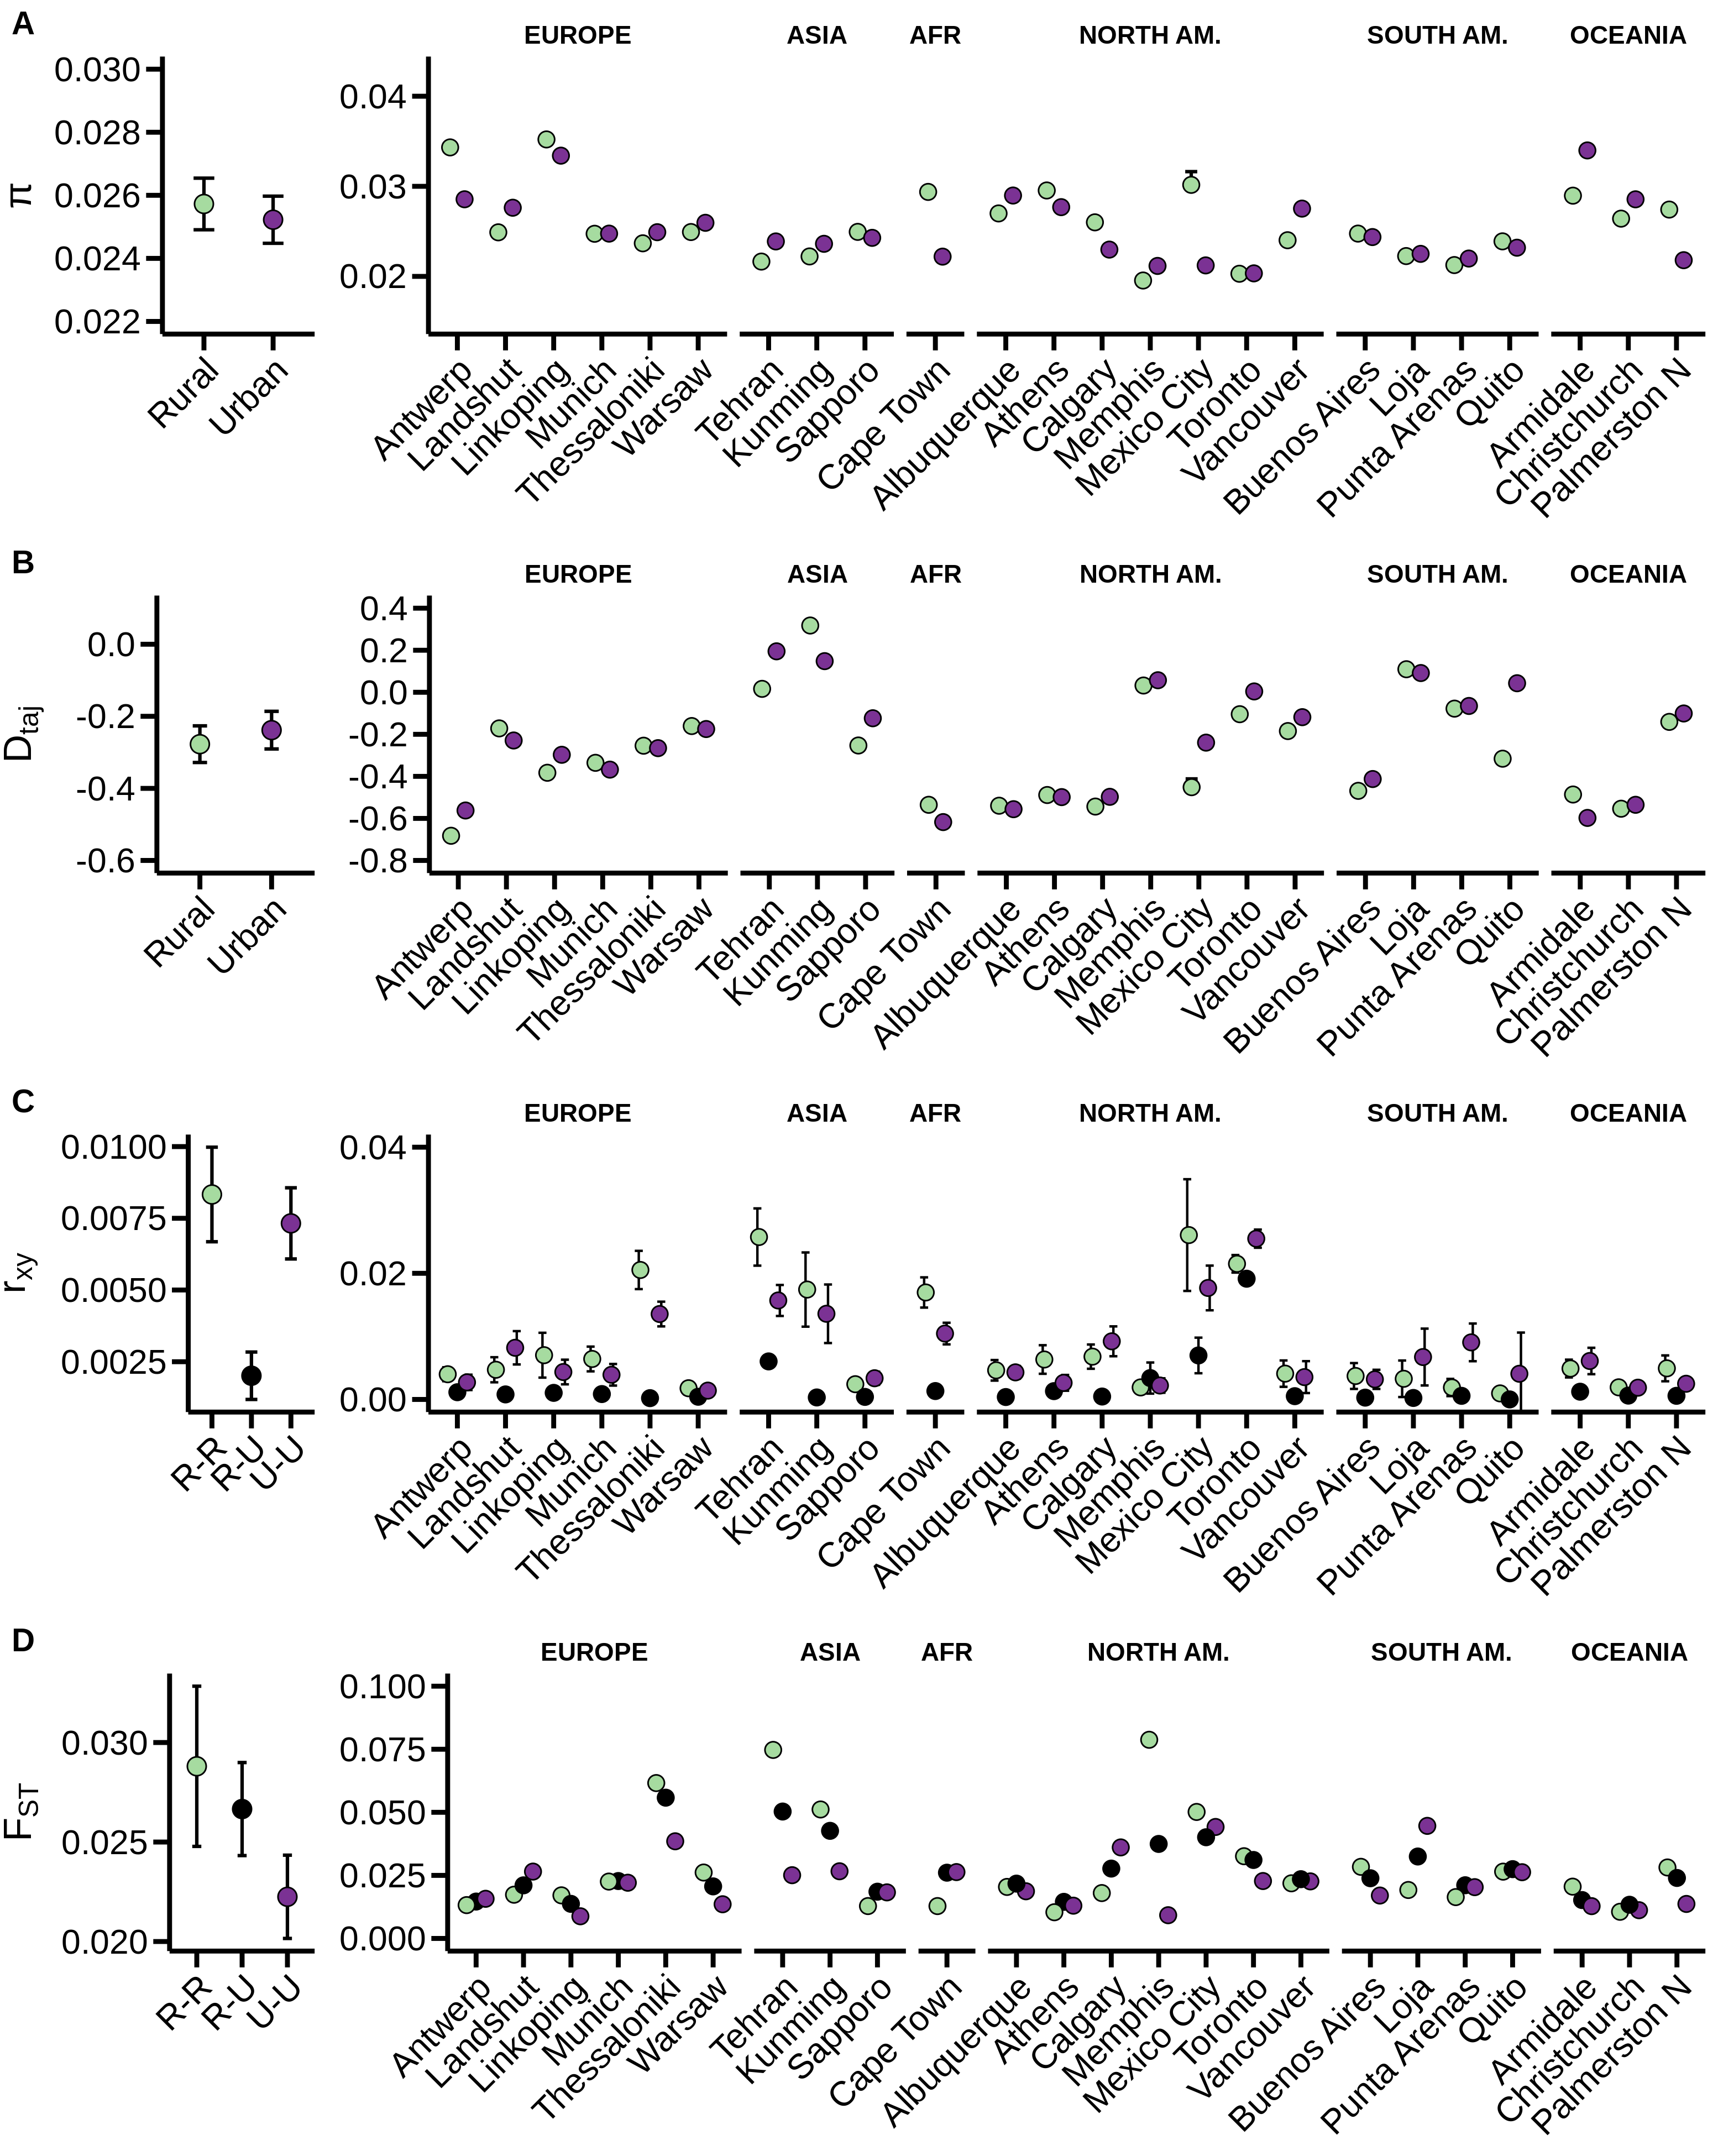

In [14]:
panel<-ggarrange(pi_by_habitat,pi_by_city_by_habitat,
                                taj_by_habitat,taj_by_city_by_habitat,
                                rab_by_habitat,rab_by_city_by_habitat,
                                fst_by_hab_combo,fst_by_city_by_hab_combo, 
                                
                                
                                ncol=2,nrow=4,widths=c(0.4,1.7),align="hv",labels=c("A","","B","","C","","D"))
ggsave(panel,
    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
    filename="panel2.png", width = 10.36, height = 13, unit="in")
display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/panel2.png")


# Models

## Detailed table

In [8]:
# generating file with details
## loading sample sheet
sample_sheet<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t")
city_detail<-distinct(sample_sheet, city, .keep_all= TRUE)

## merging details per city to the diversity values
div_table<-merge(obs_div_df,city_detail, by.x="city", by.y="city", all.x=TRUE, all.y=FALSE)


## Pi

### Distribution

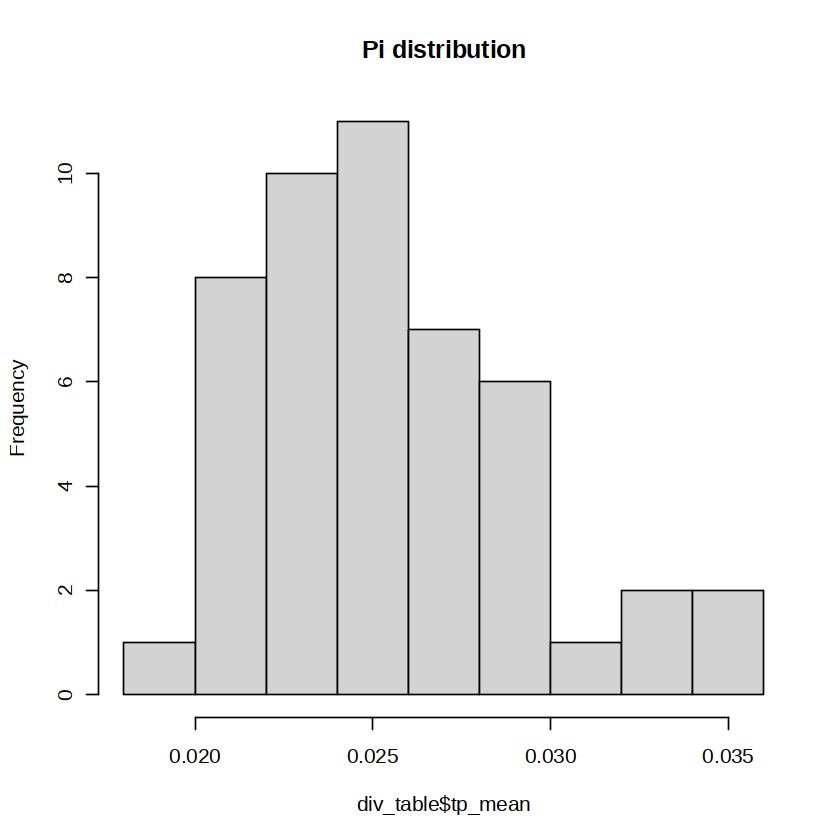

In [9]:
hist(div_table$tp_mean, main="Pi distribution") #normal distribution


### Model selection

In [12]:
mod_pi1<-lmer(tp_mean~habitat+continent+range+habitat*continent+habitat*range +(1|continent/city),data=div_table,na.action = "na.fail")
#mod<-dredge(mod_pi1, trace=T, rank="AICc", REML=T)

# Anova on the best model conta
best_mod_pi<-lmer(tp_mean~habitat +(1|city),data=div_table,na.action = "na.fail")
anova(best_mod_pi)

mod_pi2<-lmer(tp_mean~habitat + continent+ (1|city),data=div_table,na.action = "na.fail")
anova(mod_pi2)


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -2.3e-20”


Sum Sq       Mean Sq      NumDF DenDF F value   Pr(>F)   
habitat 2.999049e-06 2.999049e-06 1     23    0.5045661 0.4846414

Sum Sq       Mean Sq      NumDF DenDF F value   Pr(>F)   
habitat   2.999049e-06 2.999049e-06 1     23    0.5045661 0.4846414
continent 5.178978e-05 1.035796e-05 5     18    1.7426438 0.1759238

## Watterson's theta

### Distribution

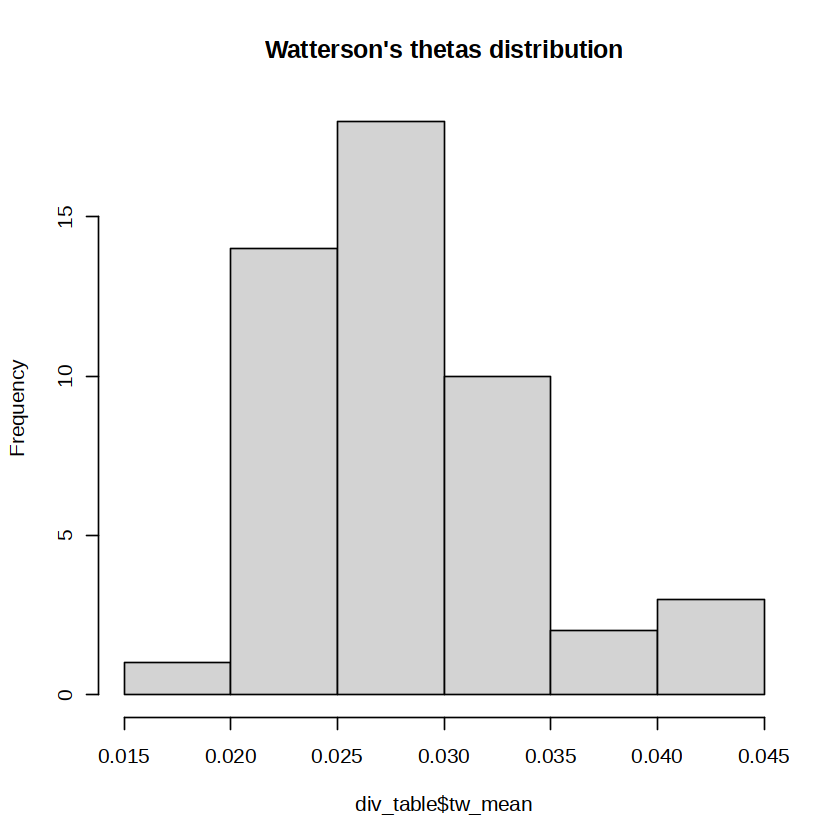

In [150]:
hist(div_table$tw_mean, main="Watterson's thetas distribution") #normal distribution


### Model selection

In [13]:
#finding the best model (with habitat variable) with AICc
mod_theta1<-lmer(tw_mean~habitat+continent+range+habitat*continent+habitat*range +(1|continent/city),data=div_table,na.action = "na.fail")
mod<-dredge(mod_theta1, trace=T, rank="AICc", REML=T)
mod
# Anova on the best model
best_mod_theta<-lmer(tw_mean~habitat +(1|city),data=div_table,na.action = "na.fail")
anova(best_mod_theta)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 1.9e-09”
Warning message in dredge(mod_theta1, trace = T, rank = "AICc", REML = T):
“comparing models fitted by REML”
Fixed term is "(Intercept)"



0 : lmer(formula = tw_mean ~ (1 | continent/city), data = div_table, 
    na.action = "na.fail")
1 : lmer(formula = tw_mean ~ continent + (1 | continent/city), data = div_table, 
    na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -5.3e-20”


2 : lmer(formula = tw_mean ~ habitat + (1 | continent/city), data = div_table, 
    na.action = "na.fail")
3 : lmer(formula = tw_mean ~ continent + habitat + (1 | continent/city), 
    data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -4.2e-20”


4 : lmer(formula = tw_mean ~ range + (1 | continent/city), data = div_table, 
    na.action = "na.fail")
5 : lmer(formula = tw_mean ~ continent + range + (1 | continent/city), 
    data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“ Hessian is numerically singular: parameters are not uniquely determined”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -1.3e-22”


6 : lmer(formula = tw_mean ~ habitat + range + (1 | continent/city), 
    data = div_table, na.action = "na.fail")
7 : lmer(formula = tw_mean ~ continent + habitat + range + (1 | continent/city), 
    data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -2.2e-21”


11 : lmer(formula = tw_mean ~ continent + habitat + (1 | continent/city) + 
    continent:habitat, data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -4.4e-21”


15 : lmer(formula = tw_mean ~ continent + habitat + range + (1 | continent/city) + 
    continent:habitat, data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -7.6e-21”


22 : lmer(formula = tw_mean ~ habitat + range + (1 | continent/city) + 
    habitat:range, data = div_table, na.action = "na.fail")
23 : lmer(formula = tw_mean ~ continent + habitat + range + (1 | continent/city) + 
    habitat:range, data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -1.9e-09”


31 : lmer(formula = tw_mean ~ continent + habitat + range + (1 | continent/city) + 
    continent:habitat + habitat:range, data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -8.9e-23”


(Intercept) continent habitat range continent:habitat habitat:range df
1  0.02794305  NA        NA      NA    NA                NA             4
5  0.02761162  NA        NA      +     NA                NA             5
3  0.02854869  NA        +       NA    NA                NA             5
7  0.02821726  NA        +       +     NA                NA             6
23 0.02833869  NA        +       +     NA                +              7
2  0.03086562  +         NA      NA    NA                NA             9
6  0.03086562  +         NA      +     NA                NA            10
4  0.03147126  +         +       NA    NA                NA            10
8  0.03147126  +         +       +     NA                NA            11
24 0.03159269  +         +       +     NA                +             12
12 0.03473268  +         +       NA    +                 NA            15
16 0.03473268  +         +       +     +                 NA            16
32 0.03473268  +         +       +     +                 +             17
   logLik   AICc      delta     weight      
1  177.7653 -346.6003   0.00000 9.960423e-01
5  173.0262 -334.6239  11.97643 2.498213e-03
3  172.4864 -333.5442  13.05615 1.456031e-03
7  167.7473 -321.4459  25.15445 3.436042e-06
23 162.6783 -308.5566  38.04367 5.460099e-09
2  157.8122 -292.8875  53.71276 2.161225e-12
6  153.7056 -281.4653  65.13497 7.151540e-15
4  152.5333 -279.1206  67.47968 2.214379e-15
8  148.4267 -267.5201  79.08017 6.702517e-18
24 143.3577 -253.8012  92.79912 7.034055e-21
12 130.3507 -215.7015 130.89884 3.749345e-29
16 126.2442 -202.9400 143.66033 6.350873e-32
32 122.1776 -189.9553 156.64505 9.621362e-35

Sum Sq       Mean Sq      NumDF DenDF F value  Pr(>F)   
habitat 1.760631e-05 1.760631e-05 1     23    1.303166 0.2653821

## Tajima's D

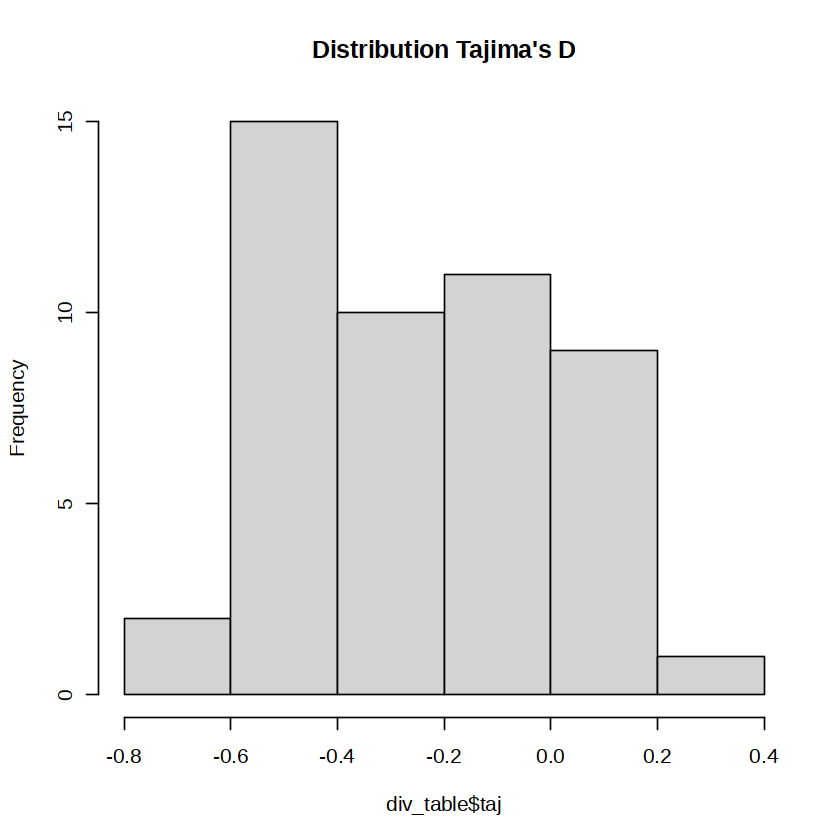

In [148]:
hist(div_table$taj, main="Tajima's D distribution")

### Model selection

In [14]:
#finding the best model (with habitat variable) with AICc
mod_taj1<-lmer(taj~habitat+continent+range+habitat*continent+habitat*range +(1|continent/city),data=div_table,na.action = "na.fail")
summary(mod_taj1)
mod<-dredge(mod_taj1, trace=T, rank="AICc", REML=T)
mod
# Anova on the best model
best_mod_taj<<-lmer(taj~habitat +(1|city),data=div_table,na.action = "na.fail")
anova(best_mod_taj)


Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 5.4e-10”

Correlation matrix not shown by default, as p = 14 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: taj ~ habitat + continent + range + habitat * continent + habitat *  
    range + (1 | continent/city)
   Data: div_table

REML criterion at convergence: -15.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6261 -0.3867  0.0000  0.4318  1.6271 

Random effects:
 Groups         Name        Variance Std.Dev.
 city:continent (Intercept) 0.046741 0.21620 
 continent      (Intercept) 0.006684 0.08176 
 Residual                   0.006216 0.07884 
Number of obs: 48, groups:  city:continent, 24; continent, 6

Fixed effects:
                            Estimate Std. Error       df t value Pr(>|t|)  
(Intercept)                 -0.53527    0.24422 23.43096  -2.192   0.0386 *
habitatu                    -0.08228    0.11150 16.99998  -0.738   0.4706  
continentASIA                0.56751    0.30464 24.74830   1.863   0.0744 .
continentEUROPE              0.21993    0.39317 22.39611   0.

Warning message in dredge(mod_taj1, trace = T, rank = "AICc", REML = T):
“comparing models fitted by REML”
Fixed term is "(Intercept)"



0 : lmer(formula = taj ~ (1 | continent/city), data = div_table, 
    na.action = "na.fail")
1 : lmer(formula = taj ~ continent + (1 | continent/city), data = div_table, 
    na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -3.2e-10”


2 : lmer(formula = taj ~ habitat + (1 | continent/city), data = div_table, 
    na.action = "na.fail")
3 : lmer(formula = taj ~ continent + habitat + (1 | continent/city), 
    data = div_table, na.action = "na.fail")


Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 1.9e-09”


4 : lmer(formula = taj ~ range + (1 | continent/city), data = div_table, 
    na.action = "na.fail")
5 : lmer(formula = taj ~ continent + range + (1 | continent/city), 
    data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“ Hessian is numerically singular: parameters are not uniquely determined”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -1.1e-09”


6 : lmer(formula = taj ~ habitat + range + (1 | continent/city), 
    data = div_table, na.action = "na.fail")
7 : lmer(formula = taj ~ continent + habitat + range + (1 | continent/city), 
    data = div_table, na.action = "na.fail")


Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 8.3e-10”


11 : lmer(formula = taj ~ continent + habitat + (1 | continent/city) + 
    continent:habitat, data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 4.2e-10”


15 : lmer(formula = taj ~ continent + habitat + range + (1 | continent/city) + 
    continent:habitat, data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“ Hessian is numerically singular: parameters are not uniquely determined”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 7.2e-10”


22 : lmer(formula = taj ~ habitat + range + (1 | continent/city) + 
    habitat:range, data = div_table, na.action = "na.fail")
23 : lmer(formula = taj ~ continent + habitat + range + (1 | continent/city) + 
    habitat:range, data = div_table, na.action = "na.fail")


Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: 1.3e-09”


31 : lmer(formula = taj ~ continent + habitat + range + (1 | continent/city) + 
    continent:habitat + habitat:range, data = div_table, na.action = "na.fail")


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in as_lmerModLT(model, devfun):
“Model may not have converged with 1 eigenvalue close to zero: -3.6e-12”


(Intercept) continent habitat range continent:habitat habitat:range df
1  -0.2573370  NA        NA      NA    NA                NA             4
5  -0.2709210  NA        NA      +     NA                NA             5
3  -0.2768079  NA        +       NA    NA                NA             5
7  -0.2903918  NA        +       +     NA                NA             6
2  -0.5764095  +         NA      NA    NA                NA             9
23 -0.2905091  NA        +       +     NA                +              7
6  -0.5764095  +         NA      +     NA                NA            10
4  -0.5958805  +         +       NA    NA                NA            10
8  -0.5958805  +         +       +     NA                NA            11
24 -0.5959977  +         +       +     NA                +             12
12 -0.5352719  +         +       NA    +                 NA            15
16 -0.5352719  +         +       +     +                 NA            16
32 -0.5352719  +         +       +     +                 +             17
   logLik    AICc        delta     weight      
1  16.087463 -23.2446940  0.000000 8.376954e-01
5  15.188169 -18.9477656  4.296928 9.772821e-02
3  14.652855 -17.8771391  5.367555 5.721849e-02
7  13.753561 -13.4583405  9.786353 6.280677e-03
2  15.948136  -9.1594301 14.085264 7.319980e-04
23 11.688103  -6.5762051 16.668489 2.011730e-04
6  15.605015  -5.2640832 17.980611 1.043869e-04
4  14.513528  -3.0811102 20.163584 3.504447e-05
8  14.170407   0.9925202 24.237214 4.571323e-06
24 12.104949   8.7043885 31.949082 9.670101e-08
12  7.998550  29.0028994 52.247593 3.781511e-12
16  7.655429  34.2375296 57.482224 2.760450e-13
32  7.623379  39.1532428 62.397937 2.363449e-14

Sum Sq     Mean Sq    NumDF DenDF F value  Pr(>F)   
habitat 0.01819778 0.01819778 1     23    2.935046 0.1001258

# Fst within habitat

In [14]:
obs_fst_within_df<-read.csv('../analyses/tables/observed_fst_per_pop.csv',header=TRUE)
obs_fst_within_df$hab_combo <- paste(obs_fst_within_df$hab1, obs_fst_within_df$hab2)

rr<-subset(obs_fst_within_df, hab_combo=="r r")
ur<-subset(obs_fst_within_df, hab_combo=="u r" | hab_combo=="r u")
uu<-subset(obs_fst_within_df, hab_combo=="u u")
rr1<-rr[,c(1,2,3,6,12)]
mean(rr1$fst)
sd(rr1$fst)
ur1<-ur[,c(1,2,3,6,12)]
mean(ur1$fst)
sd(ur1$fst)
uu1<-uu[,c(1,2,3,6,12)]
mean(uu1$fst)
sd(uu1$fst)

temp<-rbind(rr1,ur1)
fst_within<-rbind(temp,uu1)
fst_within[fst_within == "u r"] <- "r u"

fst_within

ERROR: Error in `[.data.frame`(rr, , c(1, 2, 3, 6, 12)): colonnes non définies sélectionnées


In [18]:
obs_fst_within_df<-read.csv('../analyses/tables/observed_fst_per_pop.csv',header=TRUE)
obs_fst_within_df$hab_combo <- paste(obs_fst_within_df$hab1, obs_fst_within_df$hab2)

rr<-subset(obs_fst_within_df, hab_combo=="r r")
ur<-subset(obs_fst_within_df, hab_combo=="u r" | hab_combo=="r u")
uu<-subset(obs_fst_within_df, hab_combo=="u u")
rr1<-rr[,c(1,2,3,6,11)]
mean(rr1$fst)
sd(rr1$fst)
ur1<-ur[,c(1,2,3,6,11)]
mean(ur1$fst)
sd(ur1$fst)
uu1<-uu[,c(1,2,3,6,11)]
mean(uu1$fst)
sd(uu1$fst)

temp<-rbind(rr1,ur1)
fst_within<-rbind(temp,uu1)
fst_within[fst_within == "u r"] <- "r u"

fst_within


[1] 0.02858301

[1] 0.02770612

[1] 0.0266771

[1] 0.01622279

[1] 0.0216415

[1] 0.01270637

city        pop1 pop2 fst         hab_combo
11  Albuquerque 32   29   0.017987088 r r      
15  Albuquerque 33   29   0.017611277 r r      
19  Albuquerque 33   32   0.016178901 r r      
21  Albuquerque 35   33   0.025635398 r r      
23  Albuquerque 35   29   0.028269862 r r      
24  Albuquerque 35   32   0.028642285 r r      
28  Albuquerque 36   32   0.016817538 r r      
29  Albuquerque 36   29   0.015762719 r r      
31  Albuquerque 36   33   0.014622112 r r      
32  Albuquerque 36   35   0.022725092 r r      
45  Antwerp     37   36   0.011411336 r r      
47  Antwerp     38   37   0.008880795 r r      
50  Antwerp     38   36   0.009478291 r r      
53  Antwerp     39   37   0.018929671 r r      
54  Antwerp     39   36   0.019908422 r r      
58  Antwerp     39   38   0.017875026 r r      
62  Antwerp     40   37   0.011113629 r r      
63  Antwerp     40   36   0.013551638 r r      
64  Antwerp     40   38   0.008375686 r r      
65  Antwerp     40   39   0.012634741 r r      
83  Armidale    36   35   0.021217615 r r      
87  Armidale    37   36   0.015858402 r r      
91  Armidale    37   35   0.015967458 r r      
93  Armidale    39   36   0.019986598 r r      
97  Armidale    39   35   0.013354651 r r      
105 Armidale    40   35   0.029276996 r r      
107 Armidale    40   36   0.028086332 r r      
123 Athens      22   21   0.010803799 r r      
128 Athens      23   21   0.008675009 r r      
130 Athens      23   22   0.012127029 r r      
⋮   ⋮           ⋮    ⋮    ⋮           ⋮        
826 Toronto     40   37   0.035761910 u u      
828 Toronto     41   37   0.026752815 u u      
830 Toronto     41   40   0.025173461 u u      
832 Toronto     42   37   0.032360709 u u      
833 Toronto     42   40   0.031759209 u u      
834 Toronto     42   42   0.000000000 u u      
836 Toronto     43   40   0.027021978 u u      
837 Toronto     43   42   0.021960192 u u      
838 Toronto     43   37   0.026811924 u u      
839 Toronto     43   43   0.000000000 u u      
851 Vancouver    2    1   0.039252029 u u      
852 Vancouver    3    1   0.019718164 u u      
853 Vancouver    3    2   0.046898038 u u      
880 Vancouver    4    1   0.010446081 u u      
881 Vancouver    4    3   0.013851669 u u      
882 Vancouver    4    2   0.025420704 u u      
892 Vancouver    5    1   0.012231782 u u      
893 Vancouver    5    2   0.032758249 u u      
894 Vancouver    5    4   0.008529434 u u      
895 Vancouver    5    3   0.017125763 u u      
896 Warsaw       2    1   0.011660224 u u      
897 Warsaw       3    1   0.010618327 u u      
898 Warsaw       3    2   0.012392341 u u      
899 Warsaw       4    1   0.013822543 u u      
900 Warsaw       4    3   0.013542372 u u      
901 Warsaw       4    2   0.015448108 u u      
928 Warsaw       5    1   0.014386946 u u      
929 Warsaw       5    2   0.015694590 u u      
930 Warsaw       5    4   0.012984265 u u      
931 Warsaw       5    3   0.014957585 u u


	Shapiro-Wilk normality test

data:  fst_within$fst
W = 0.74894, p-value < 2.2e-16



	Shapiro-Wilk normality test

data:  log(fst_within$fst + 1)
W = 0.77079, p-value < 2.2e-16


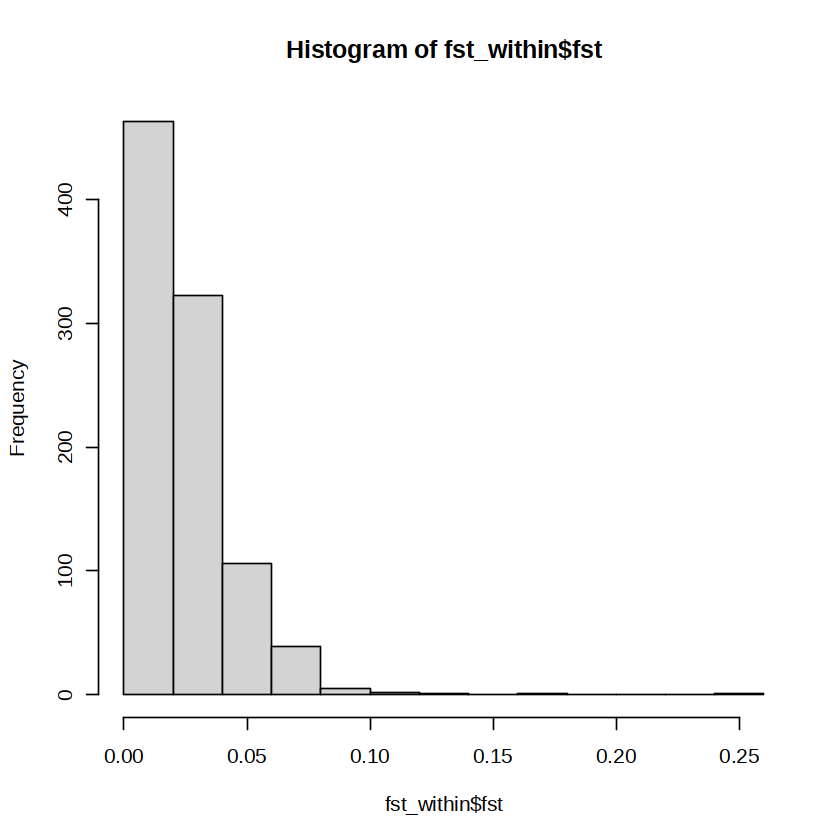

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: fst ~ hab_combo + (1 | city)
   Data: fst_within

REML criterion at convergence: -5141.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0177 -0.4176 -0.1022  0.2945 13.5316 

Random effects:
 Groups   Name        Variance  Std.Dev.
 city     (Intercept) 0.0001272 0.01128 
 Residual             0.0002203 0.01484 
Number of obs: 940, groups:  city, 24

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)    0.028356   0.002533  30.930337  11.193 2.09e-12 ***
hab_combor u  -0.001634   0.001240 915.008304  -1.318    0.188    
hab_combou u  -0.006437   0.001460 916.175391  -4.409 1.16e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) hb_cmbru
hab_comboru -0.353         
hab_combouu -0.304  0.618  


	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = fst ~ hab_combo + (1 | city), data = fst_within)

Linear Hypotheses:
                Estimate Std. Error z value Pr(>|z|)    
r u - r r == 0 -0.001634   0.001240  -1.318 0.187435    
u u - r r == 0 -0.006437   0.001460  -4.409 3.12e-05 ***
u u - r u == 0 -0.004803   0.001196  -4.017 0.000118 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
(Adjusted p values reported -- holm method)


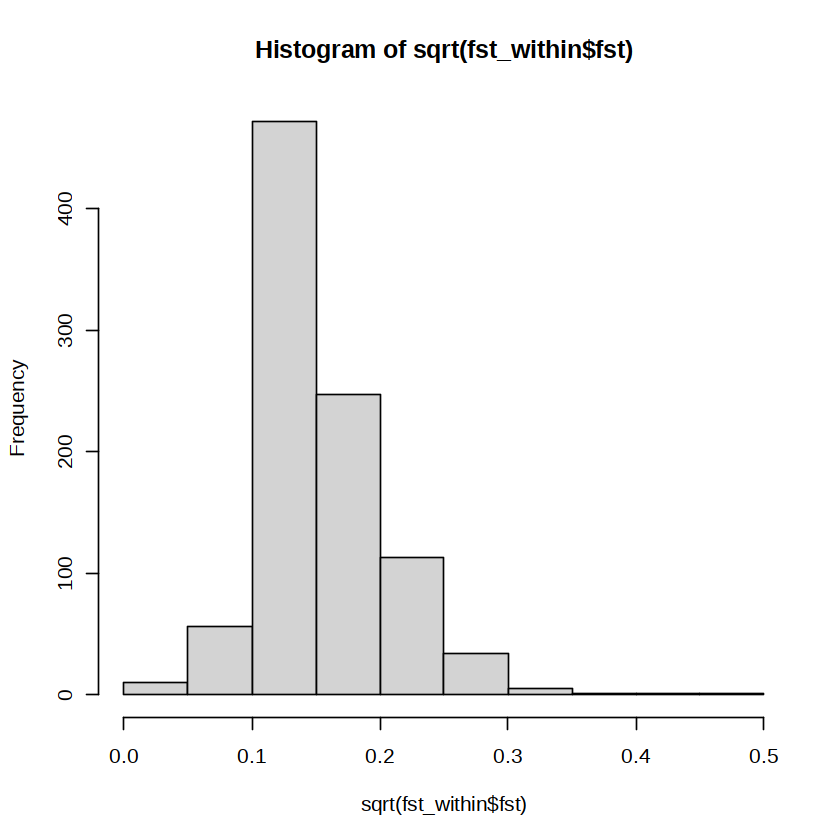

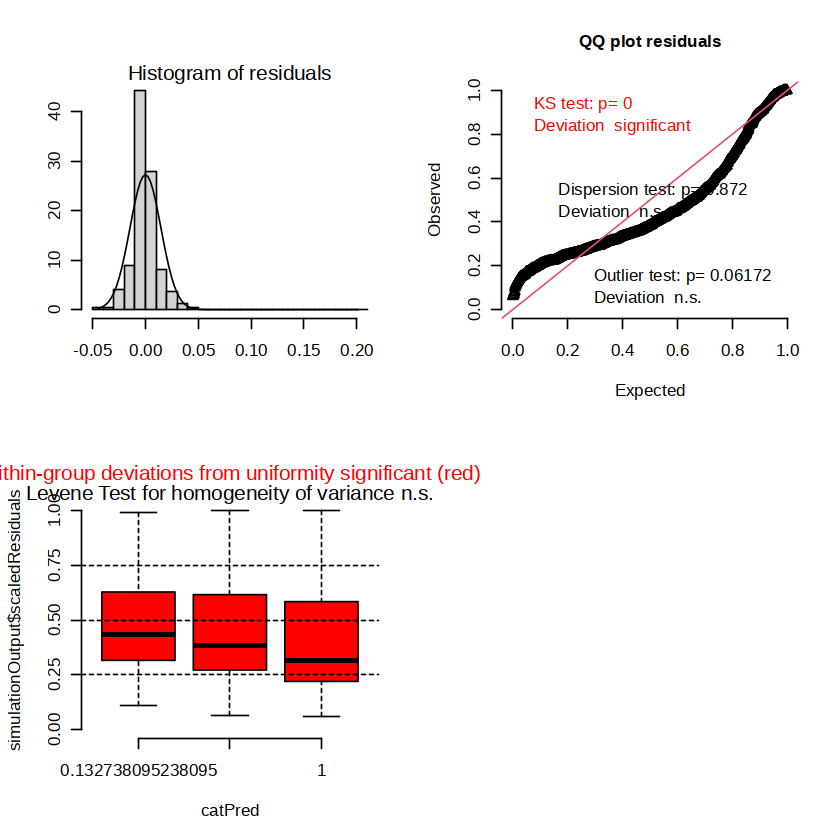

In [74]:
#fst_within
hist(fst_within$fst)
shapiro.test(fst_within$fst) # not normal
shapiro.test(log(fst_within$fst+1))

hist(sqrt(fst_within$fst))
#model1<-glmmTMB(sqrt(fst)~hab_combo+(1|city),data=fst_within)
#summary(model1)

#hist(log(fst_within$fst))
#model2<-lmer(log(fst+1)~hab_combo+(1|city),data=fst_within)
#summary(model2)
#library(multcomp)
#summary(glht(model2, linfct = mcp(hab_combo = "Tukey")), test = adjusted("holm"))
model4<-lmer(fst~hab_combo+(1|city),data=fst_within)
summary(model4)
summary(glht(model4, linfct = mcp(hab_combo = "Tukey")), test = adjusted("holm"))

#check fit
diagnostics.plot.dharma <-function(mod.res, col=grey(level=0.25, alpha=0.5), breaks.histo=20, quantreg=TRUE){
  old.par = par(no.readonly = TRUE)
  par(mfrow=c(2, 2))
  hist(residuals(mod.res), probability=T, xlab="", ylab="", main="", breaks=breaks.histo)
  mtext(text="Histogram of residuals", side=3, line=0)
  x=seq(min(residuals(mod.res)), max(residuals(mod.res)), length.out=100)
  lines(x, dnorm(x, mean=0, sd=sd(residuals(mod.res))))
  simulationOutput <- simulateResiduals(fittedModel = mod.res, plot = FALSE)
  plotQQunif(simulationOutput) # left plot in plot.DHARMa()
  plotResiduals(simulationOutput, quantreg=quantreg)
}
#diagnostics.plot.dharma(model2)
diagnostics.plot.dharma(model4)

In [78]:
temp<-rbind(rr1,ur1)
temp[temp == "u r"] <- "r u"
wilcox.test(temp$fst~temp$hab_combo, data = temp, paired = FALSE, alternative="greater")

temp2<-rbind(rr1,uu1)
wilcox.test(fst~hab_combo, data = temp2, paired = FALSE, alternative="greater")

temp3<-rbind(ur1,uu1)
temp3[temp3 == "u r"] <- "r u"
wilcox.test(fst~hab_combo, data = temp3, paired = FALSE, alternative="greater")



	Wilcoxon rank sum test with continuity correction

data:  temp$fst by temp$hab_combo
W = 48227, p-value = 0.9326
alternative hypothesis: true location shift is greater than 0



	Wilcoxon rank sum test with continuity correction

data:  fst by hab_combo
W = 24649, p-value = 0.03133
alternative hypothesis: true location shift is greater than 0



	Wilcoxon rank sum test with continuity correction

data:  fst by hab_combo
W = 68077, p-value = 2.935e-05
alternative hypothesis: true location shift is greater than 0


# Migration rates (from dadi)

city         direction mig_rate
1 Albuquerque  ur        6.85e-06
2 Antwerp      ur        0.00e+00
3 Armidale     ur        0.00e+00
4 Athens       ur        0.00e+00
5 Buenos_Aires ur        0.00e+00
6 Calgary      ur        0.00e+00

Warning message in wilcox.test.default(x = c(6.85e-06, 5.88e-06, 9.45e-07, 0, 1.73e-06, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = c(6.85e-06, 5.88e-06, 9.45e-07, 0, 1.73e-06, :
“cannot compute exact p-value with zeroes”



	Wilcoxon signed rank test with continuity correction

data:  mig_rate by direction
V = 33.5, p-value = 1
alternative hypothesis: true location shift is not equal to 0


ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' and 'y' lengths differ


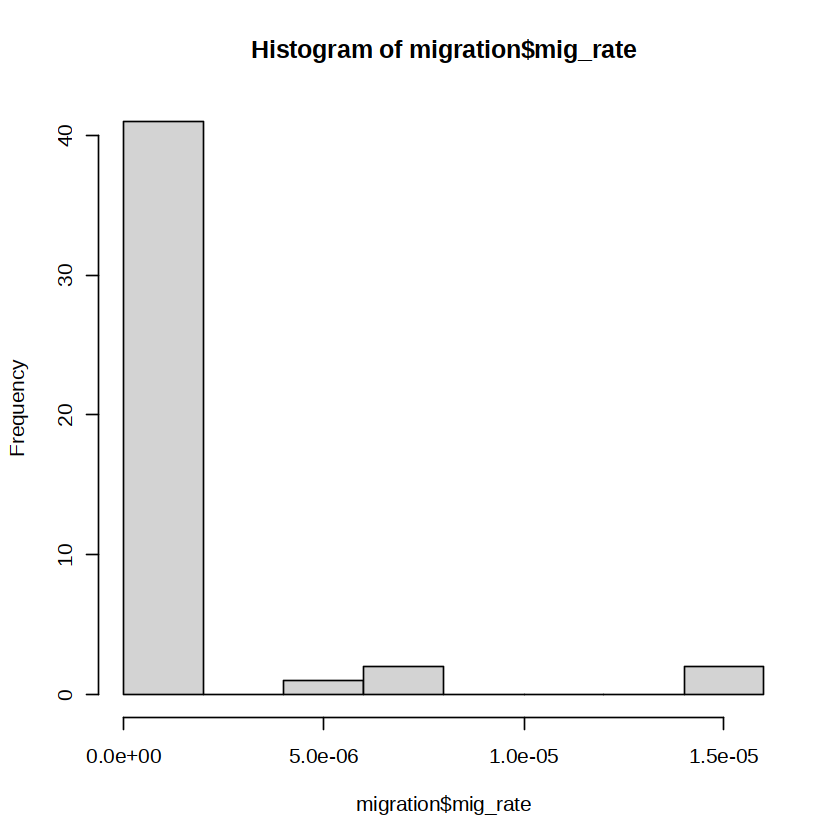

In [89]:
migration<-read.table('../analyses/tables/migration_rates_gadma.txt',header=TRUE)
head(migration)
hist(migration$mig_rate)
wilcox.test(mig_rate~direction, data = migration, paired = TRUE, alternative="two.sided")

plot(migration$mig_gate,migration$direction)

# Generate summary datasets and write dataframes

Note: This section only needs to be run to generate the summary datasets from the raw data output by the Snakemake pipeline. If the Snakemake pipeline hasn't been run, then the manuscript's results can be reproduced by running the analyses above using the summary datasets.

## Functions used to generate summary datasets

In [2]:
# Function to load observed diversity estimates by city and habitat
load_obs_pairwise_diversity <- function(path){
    
    # Get city and site names from file
    city <- dirname(path)
    site <- str_extract(basename(path), pattern = '(?<=_)[r|u]')
    
    full_path <- paste0(inpath, path)
    
    # Load dataframe
    df <- suppressMessages(read_delim(full_path, delim = '\t')) %>% 
        mutate(tp_scaled = tP / nSites,
               tw_scaled = tW / nSites,
               city = city,
               habitat = site) %>% 

    # Calculate mean across chromosomes and sum of number of sites
        group_by(city, habitat) %>% 
        summarise(tp_mean = mean(tp_scaled),
                  tw_mean = mean(tw_scaled),
                  tp_sd = sd(tp_scaled,na.rm=TRUE),
                  tw_sd = sd(tw_scaled, na.rm=TRUE),
                  taj= mean(Tajima),
                  taj_sd = sd(Tajima),
                  nSites = sum(nSites),
                 .groups = 'drop') %>% 
        dplyr::select(city, habitat, tp_mean, tw_mean, tp_sd, tw_sd, taj, taj_sd, nSites)

    return(df)
    
}


# Function to load observed Fst df by city/habitat
load_obs_fst <- function(path){
    
    # Get Fst type and city from filenames
    city <- dirname(path)
    
    full_path <- paste0(inpath, path)
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(fread(full_path, sep = '\t', header = FALSE, col.names = colnames)) %>% 
        
        # Cap numerators at 0 if negative 
        # https://github.com/ANGSD/angsd/issues/309
        # Does not affect overall pattern
        mutate(num = ifelse(num < 0, 0, num))  
        df$ratio<- df$num / df$denom
        
        # Estimate weighted Fst as ratio of averages
        # https://github.com/ANGSD/angsd/issues/61
        df1<- df %>%
        summarise(num_sum = sum(num),
                  denom_sum = sum(denom),
                  fst = num_sum / denom_sum,
                  fst_sd = sd(ratio,na.rm=TRUE),
                  nSites = n()) %>% 
        mutate(city = city)
    
    return(df1)
    
}

load_bootstrapped_pairwise_diversity <- function(path){
    
    # Get city and site names from file
    #city <- str_extract(basename(path), pattern = '(?<=/bootstrap/)([a-z]+)')
    city <-sub("_[r|u]_.*", "", basename(path))  
    site <- str_extract(basename(path), pattern = '(?<=_)[r|u]')
    seed <- str_extract(basename(path), pattern = '(?<=_4fold_)(\\d)+')

    
    full_path <- paste0(inpath, path)
    print(full_path)
    df <- suppressMessages(read_delim(full_path, delim = '\t')) %>% 
        mutate(tp_scaled = tP / nSites,
               tw_scaled = tW / nSites,
               city = city,
               habitat = site,
               seed = seed) %>% 
        # Calculate mean across chromosomes and sum of number of sites
        group_by(city, habitat, seed) %>% 
        summarise(tp_mean = mean(tp_scaled),
                  tw_mean = mean(tw_scaled),
                  tp_sd = sd(tp_scaled,na.rm=TRUE),
                  tw_sd = sd(tw_scaled, na.rm=TRUE),
                  taj= mean(Tajima),
                  taj_sd = sd(Tajima),
                  nSites = sum(nSites),
                 .groups = 'drop') %>%  
        #dplyr::select(city, habitat, seed, tp_scaled, tw_scaled, nSites)

    return(df)
    
}

## Write dataframes

### Urban-rural diversity stats

In [7]:
# Concatenate urban and rural genetic diversity results (N = 2 habitats x 26 citis = 52) into single dataframe
inpath <- '/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/'
obs_div_df <- list.files(inpath, pattern = '.*_[u|r]_4fold.thetas.idx.pestPG', recursive = TRUE) %>% 
    map_dfr(., load_obs_pairwise_diversity)
obs_div_df
# Write observed data to disc
write_delim(obs_div_df, '../analyses/tables/div_popStruct/observed_urban-rural_pi.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/observed_urban-rural_pi.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)


city             habitat tp_mean    tw_mean    tp_sd        tw_sd       
1  Albuquerque      r       0.02698932 0.03200117 0.0013754307 0.0010143774
2  Albuquerque      u       0.02897677 0.03454662 0.0013304794 0.0009070059
3  Antwerp          r       0.03431930 0.04283631 0.0018133506 0.0014501993
4  Antwerp          u       0.02856077 0.03414765 0.0013437693 0.0009041316
5  Armidale         r       0.02896160 0.03372373 0.0013611441 0.0009864637
6  Armidale         u       0.03398263 0.04105213 0.0034362431 0.0027046818
7  Athens           r       0.02953841 0.03440285 0.0016742391 0.0011017586
8  Athens           u       0.02768696 0.03234779 0.0014167350 0.0009469668
9  Buenos_Aires     r       0.02475177 0.02851836 0.0009369085 0.0008321895
10 Buenos_Aires     u       0.02436669 0.02764306 0.0010824470 0.0008364573
11 Calgary          r       0.02600060 0.03087428 0.0011646101 0.0008317991
12 Calgary          u       0.02297499 0.02681663 0.0009680399 0.0008181451
13 Cape_Town        r       0.02937824 0.03473268 0.0015364394 0.0012045712
14 Cape_Town        u       0.02219535 0.02699856 0.0008915799 0.0006651308
15 Christchurch     r       0.02641199 0.03148593 0.0012271662 0.0009534118
16 Christchurch     u       0.02855621 0.03382179 0.0014457045 0.0010195383
17 Kunming          r       0.02221668 0.02037496 0.0010447383 0.0007522115
18 Kunming          u       0.02361680 0.02265286 0.0011712106 0.0007978255
19 Landshut         r       0.02489212 0.02619236 0.0012070347 0.0008710003
20 Landshut         u       0.02762286 0.02958616 0.0013805234 0.0010156805
21 Linkoping        r       0.03520314 0.03958853 0.0025289543 0.0017159225
22 Linkoping        u       0.03340262 0.03651084 0.0031766694 0.0021881594
23 Loja             r       0.02225706 0.02160358 0.0009448283 0.0007315815
24 Loja             u       0.02250125 0.02193499 0.0010677008 0.0007730305
25 Memphis          r       0.01954426 0.01937561 0.0008099654 0.0006546579
26 Memphis          u       0.02116296 0.02081104 0.0009978606 0.0007350125
27 Mexico_City      r       0.03016143 0.04124637 0.0446062756 0.0652857294
28 Mexico_City      u       0.02122120 0.02279857 0.0008332982 0.0006848188
29 Munich           r       0.02473156 0.02738145 0.0011809939 0.0009786893
30 Munich           u       0.02474829 0.02769250 0.0011645161 0.0009128502
31 Palmerston_North r       0.02741821 0.02855379 0.0015717161 0.0010619152
32 Palmerston_North u       0.02180008 0.02244907 0.0009590627 0.0007852003
33 Punta_Arenas     r       0.02125875 0.02173400 0.0010318026 0.0007813973
34 Punta_Arenas     u       0.02198160 0.02238396 0.0010016608 0.0007672867
35 Quito            r       0.02389041 0.02608363 0.0010325811 0.0007935230
36 Quito            u       0.02318592 0.02292540 0.0010528836 0.0008131375
37 Sapporo          r       0.02494184 0.02690036 0.0011005472 0.0009031456
38 Sapporo          u       0.02427972 0.02517504 0.0010834227 0.0009484183
39 Tehran           r       0.02164648 0.02154207 0.0008954441 0.0006820477
40 Tehran           u       0.02388162 0.02261002 0.0009699126 0.0007120886
41 Thessaloniki     r       0.02367304 0.02555338 0.0010028259 0.0008474097
42 Thessaloniki     u       0.02490624 0.02698524 0.0010080124 0.0007483184
43 Toronto          r       0.02029401 0.02091743 0.0007863861 0.0006912975
44 Toronto          u       0.02033674 0.02031170 0.0007550556 0.0006810154
45 Vancouver        r       0.02401564 0.02535670 0.0011549913 0.0009036699
46 Vancouver        u       0.02752482 0.02849582 0.0012771242 0.0011016726
47 Warsaw           r       0.02492455 0.02609305 0.0012404516 0.0009531980
48 Warsaw           u       0.02594923 0.02730448 0.0015258461 0.0009974904
   taj          taj_sd     nSites 
1  -0.539630313 0.06615948 1014098
2  -0.556195625 0.07066635  805367
3  -0.682612625 0.08142041  274252
4  -0.562371250 0.06983064  925024
5  -0.486352750 0.06743949  966853
6  -0.597688062 0.13437001  162945
7  -0.488714312 0.08225448  660506

### Per city per habitat per population diversity stats

In [104]:
# Function to load observed diversity estimates by city and habitat
load_obs_pairwise_diversity_per_pop <- function(path){
    
    # Get city and site names from file
    full_path <- paste0(inpath2, path)

    city_prov <- strsplit(full_path, "/")[[1]][13]
    city <- strsplit(city_prov, "_")[[1]][1]

    pop<- strsplit(full_path, "[.]")[[1]][2]

    # Load dataframe
    df <- suppressMessages(read_delim(full_path, delim = '\t')) %>% 
        mutate(tp_scaled = tP / nSites,
               tw_scaled = tW / nSites,
               city = city,
               population = pop) %>% 

    # Calculate mean across chromosomes and sum of number of sites
        group_by(city, population) %>% 
        summarise(tp_mean = mean(tp_scaled),
                  tw_mean = mean(tw_scaled),
                  tp_sd = sd(tp_scaled,na.rm=TRUE),
                  tw_sd = sd(tw_scaled, na.rm=TRUE),
                  taj= mean(Tajima),
                  taj_sd = sd(Tajima),
                  nSites = sum(nSites),
                 .groups = 'drop') %>% 
        dplyr::select(city, population, tp_mean, tw_mean, tp_sd, tw_sd, taj, taj_sd, nSites)

    return(df)
    
}

inpath2 <- '/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/byPop/thetas/'
obs_div_perpop_df <- list.files(inpath2, pattern = '.*._4fold.thetas.idx.pestPG', recursive = TRUE) %>% 
    map_dfr(., load_obs_pairwise_diversity_per_pop)

write_delim(obs_div_perpop_df, '../analyses/tables/div_popStruct/observed_urban-rural_pi_per_pop.txt', delim = '\t')
#bzip2(filename = '../analyses/tables/div_popStruct/observed_urban-rural_pi_per_pop.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)


### Urban-rural Fst

In [12]:
# Merge Fst dataframes. Using Hudson's Fst
inpath <- '/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/hudson_fst/'
obs_fst_df <- list.files(inpath, pattern = '.*_4fold_r_u_readable.fst', recursive = TRUE) %>% 
    map_dfr(., load_obs_fst)

# Write observed Fst values to disc
write_delim(obs_fst_df, '../analyses/tables/div_popStruct/observed_fst.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/observed_fst.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)

### Fst between populations

In [16]:
list<-c('Albuquerque.1.2', 'Albuquerque.1.32', 'Albuquerque.14.14', 'Albuquerque.14.15', 'Albuquerque.14.29', 'Albuquerque.14.32', 'Albuquerque.14.33', 'Albuquerque.14.35', 'Albuquerque.14.36', 'Albuquerque.15.29', 'Albuquerque.15.32', 'Albuquerque.15.33', 'Albuquerque.15.35', 'Albuquerque.15.36', 'Albuquerque.2.32', 'Albuquerque.2.3', 'Albuquerque.29.32', 'Albuquerque.29.33', 'Albuquerque.29.35', 'Albuquerque.29.36', 'Albuquerque.3.15', 'Albuquerque.32.33', 'Albuquerque.32.35', 'Albuquerque.32.36', 'Albuquerque.3.29', 'Albuquerque.3.32', 'Albuquerque.3.33', 'Albuquerque.33.35', 'Albuquerque.33.36', 'Albuquerque.3.35', 'Albuquerque.3.36', 'Albuquerque.35.36', 'Antwerp.1.2', 'Antwerp.1.3', 'Antwerp.1.36', 'Antwerp.1.37', 'Antwerp.1.38', 'Antwerp.1.39', 'Antwerp.1.40', 'Antwerp.1.5', 'Antwerp.2.3', 'Antwerp.2.36', 'Antwerp.2.37', 'Antwerp.2.38', 'Antwerp.2.39', 'Antwerp.2.40', 'Antwerp.2.5', 'Antwerp.3.36', 'Antwerp.3.37', 'Antwerp.3.38', 'Antwerp.3.39', 'Antwerp.3.40', 'Antwerp.3.4', 'Antwerp.3.5', 'Antwerp.36.37', 'Antwerp.36.38', 'Antwerp.36.39', 'Antwerp.36.40', 'Antwerp.37.38', 'Antwerp.37.39', 'Antwerp.37.40', 'Antwerp.38.39', 'Antwerp.38.40', 'Antwerp.39.40', 'Antwerp.4.37', 'Antwerp.5.36', 'Antwerp.5.37', 'Antwerp.5.38', 'Antwerp.5.39', 'Antwerp.5.40', 'Armidale.1.2', 'Armidale.1.3', 'Armidale.1.35', 'Armidale.1.36', 'Armidale.1.37', 'Armidale.1.39', 'Armidale.1.40', 'Armidale.1.4', 'Armidale.1.5', 'Armidale.2.3', 'Armidale.2.35', 'Armidale.2.36', 'Armidale.2.37', 'Armidale.2.39', 'Armidale.2.40', 'Armidale.2.4', 'Armidale.2.5', 'Armidale.3.35', 'Armidale.3.36', 'Armidale.3.37', 'Armidale.3.39', 'Armidale.3.40', 'Armidale.3.4', 'Armidale.35.36', 'Armidale.35.37', 'Armidale.35.39', 'Armidale.35.40', 'Armidale.3.5', 'Armidale.36.37', 'Armidale.36.39', 'Armidale.36.40', 'Armidale.4.35', 'Armidale.4.36', 'Armidale.4.37', 'Armidale.4.39', 'Armidale.4.40', 'Armidale.4.5', 'Armidale.5.35', 'Armidale.5.36', 'Armidale.5.37', 'Armidale.5.39', 'Armidale.5.40', 'Athens.10.21', 'Athens.10.22', 'Athens.10.23', 'Athens.10.24', 'Athens.10.25', 'Athens.21.22', 'Athens.21.23', 'Athens.21.24', 'Athens.21.25', 'Athens.22.23', 'Athens.22.24', 'Athens.22.25', 'Athens.23.24', 'Athens.23.25', 'Athens.24.25', 'Athens.6.10', 'Athens.6.21', 'Athens.6.22', 'Athens.6.23', 'Athens.6.24', 'Athens.6.25', 'Athens.6.7', 'Athens.6.8', 'Athens.6.9', 'Athens.7.10', 'Athens.7.21', 'Athens.7.22', 'Athens.7.23', 'Athens.7.24', 'Athens.7.25', 'Athens.7.8', 'Athens.7.9', 'Athens.8.10', 'Athens.8.21', 'Athens.8.22', 'Athens.8.23', 'Athens.8.24', 'Athens.8.25', 'Athens.8.9', 'Athens.9.10', 'Athens.9.21', 'Athens.9.22', 'Athens.9.23', 'Athens.9.24', 'Athens.9.25', 'Buenos_Aires.1.23', 'Buenos_Aires.18.19', 'Buenos_Aires.18.21', 'Buenos_Aires.18.22', 'Buenos_Aires.18.23', 'Buenos_Aires.19.21', 'Buenos_Aires.19.22', 'Buenos_Aires.19.23', 'Buenos_Aires.21.22', 'Buenos_Aires.21.23', 'Buenos_Aires.22.23', 'Buenos_Aires.3.18', 'Buenos_Aires.3.19', 'Buenos_Aires.3.21', 'Buenos_Aires.3.22', 'Buenos_Aires.3.23', 'Buenos_Aires.3.4', 'Buenos_Aires.3.5', 'Buenos_Aires.4.18', 'Buenos_Aires.4.19', 'Buenos_Aires.4.21', 'Buenos_Aires.4.22', 'Buenos_Aires.4.23', 'Buenos_Aires.4.5', 'Buenos_Aires.5.18', 'Buenos_Aires.5.19', 'Buenos_Aires.5.21', 'Buenos_Aires.5.22', 'Buenos_Aires.5.23', 'Calgary.2.23', 'Calgary.2.24', 'Calgary.2.25', 'Calgary.2.27', 'Calgary.2.28', 'Calgary.23.24', 'Calgary.2.32', 'Calgary.23.25', 'Calgary.23.27', 'Calgary.23.28', 'Calgary.23.32', 'Calgary.23.35', 'Calgary.23.36', 'Calgary.23.37', 'Calgary.2.35', 'Calgary.2.36', 'Calgary.2.37', 'Calgary.24.25', 'Calgary.24.27', 'Calgary.24.28', 'Calgary.24.32', 'Calgary.24.35', 'Calgary.24.36', 'Calgary.24.37', 'Calgary.25.27', 'Calgary.25.28', 'Calgary.25.32', 'Calgary.25.35', 'Calgary.25.36', 'Calgary.25.37', 'Calgary.27.28', 'Calgary.27.32', 'Calgary.27.35', 'Calgary.27.36', 'Calgary.27.37', 'Calgary.28.32', 'Calgary.28.35', 'Calgary.28.36', 'Calgary.28.37', 'Calgary.32.35', 'Calgary.32.36', 'Calgary.32.37', 'Calgary.35.36', 'Calgary.35.37', 'Calgary.36.37', 'Cape_Town.12.13', 'Cape_Town.12.14', 'Cape_Town.12.18', 'Cape_Town.12.19', 'Cape_Town.13.14', 'Cape_Town.13.18', 'Cape_Town.13.19', 'Cape_Town.14.18', 'Cape_Town.14.19', 'Cape_Town.18.19', 'Cape_Town.3.12', 'Cape_Town.3.13', 'Cape_Town.3.14', 'Cape_Town.3.18', 'Cape_Town.3.19', 'Cape_Town.3.4', 'Cape_Town.3.6', 'Cape_Town.3.7', 'Cape_Town.3.8', 'Cape_Town.4.12', 'Cape_Town.4.13', 'Cape_Town.4.14', 'Cape_Town.4.18', 'Cape_Town.4.19', 'Cape_Town.4.6', 'Cape_Town.4.7', 'Cape_Town.4.8', 'Cape_Town.6.12', 'Cape_Town.6.13', 'Cape_Town.6.14', 'Cape_Town.6.18', 'Cape_Town.6.19', 'Cape_Town.6.7', 'Cape_Town.6.8', 'Cape_Town.7.12', 'Cape_Town.7.13', 'Cape_Town.7.14', 'Cape_Town.7.18', 'Cape_Town.7.19', 'Cape_Town.7.8', 'Cape_Town.8.12', 'Cape_Town.8.13', 'Cape_Town.8.14', 'Cape_Town.8.18', 'Cape_Town.8.19', 'Christchurch.1.2', 'Christchurch.1.3', 'Christchurch.1.37', 'Christchurch.1.38', 'Christchurch.1.39', 'Christchurch.1.40', 'Christchurch.1.41', 'Christchurch.1.6', 'Christchurch.2.3', 'Christchurch.2.37', 'Christchurch.2.38', 'Christchurch.2.39', 'Christchurch.2.40', 'Christchurch.2.41', 'Christchurch.2.4', 'Christchurch.2.6', 'Christchurch.3.37', 'Christchurch.3.38', 'Christchurch.3.39', 'Christchurch.3.40', 'Christchurch.3.41', 'Christchurch.3.4', 'Christchurch.3.6', 'Christchurch.37.38', 'Christchurch.37.39', 'Christchurch.37.40', 'Christchurch.37.41', 'Christchurch.38.39', 'Christchurch.38.40', 'Christchurch.38.41', 'Christchurch.39.40', 'Christchurch.39.41', 'Christchurch.40.41', 'Christchurch.6.37', 'Christchurch.6.38', 'Christchurch.6.39', 'Christchurch.6.40', 'Christchurch.6.41', 'Kunming.1.2', 'Kunming.1.3', 'Kunming.1.46', 'Kunming.1.47', 'Kunming.1.48', 'Kunming.1.49', 'Kunming.1.50', 'Kunming.1.5', 'Kunming.2.3', 'Kunming.2.4', 'Kunming.2.46', 'Kunming.2.47', 'Kunming.2.48', 'Kunming.2.49', 'Kunming.2.50', 'Kunming.2.5', 'Kunming.3.4', 'Kunming.3.46', 'Kunming.3.47', 'Kunming.3.48', 'Kunming.3.49', 'Kunming.3.50', 'Kunming.3.5', 'Kunming.4.46', 'Kunming.4.50', 'Kunming.4.5', 'Kunming.46.47', 'Kunming.46.48', 'Kunming.46.49', 'Kunming.46.50', 'Kunming.47.48', 'Kunming.47.49', 'Kunming.47.50', 'Kunming.48.49', 'Kunming.48.5', 'Kunming.49.50', 'Kunming.5.46', 'Kunming.5.47', 'Kunming.5.48', 'Kunming.5.49', 'Kunming.5.50', 'Landshut.1.2', 'Landshut.1.3', 'Landshut.1.4', 'Landshut.1.47', 'Landshut.1.48', 'Landshut.1.49', 'Landshut.1.50', 'Landshut.1.51', 'Landshut.1.5', 'Landshut.2.3', 'Landshut.2.4', 'Landshut.2.47', 'Landshut.2.48', 'Landshut.2.49', 'Landshut.2.50', 'Landshut.2.51', 'Landshut.2.5', 'Landshut.3.4', 'Landshut.3.47', 'Landshut.3.48', 'Landshut.3.49', 'Landshut.3.50', 'Landshut.3.51', 'Landshut.3.5', 'Landshut.4.47', 'Landshut.4.48', 'Landshut.4.49', 'Landshut.4.50', 'Landshut.4.51', 'Landshut.4.5', 'Landshut.47.48', 'Landshut.47.49', 'Landshut.47.50', 'Landshut.48.49', 'Landshut.48.50', 'Landshut.49.50', 'Landshut.51.47', 'Landshut.51.48', 'Landshut.51.49', 'Landshut.51.50', 'Linkoping.13.15', 'Linkoping.13.16', 'Linkoping.13.25', 'Linkoping.13.37', 'Linkoping.13.38', 'Linkoping.13.40', 'Linkoping.15.16', 'Linkoping.15.25', 'Linkoping.15.37', 'Linkoping.15.38', 'Linkoping.15.40', 'Linkoping.16.25', 'Linkoping.16.37', 'Linkoping.16.38', 'Linkoping.16.40', 'Linkoping.25.37', 'Linkoping.25.38', 'Linkoping.25.40', 'Linkoping.27.38', 'Linkoping.27.40', 'Linkoping.5.13', 'Linkoping.5.15', 'Linkoping.5.16', 'Linkoping.5.25', 'Linkoping.5.37', 'Linkoping.5.38', 'Linkoping.5.40', 'Linkoping.5.8', 'Linkoping.8.13', 'Linkoping.8.15', 'Linkoping.8.16', 'Linkoping.8.25', 'Linkoping.8.37', 'Linkoping.8.38', 'Linkoping.8.40', 'Linkoping.8.8', 'Loja.1.2', 'Loja.1.3', 'Loja.1.36', 'Loja.1.37', 'Loja.1.38', 'Loja.1.39', 'Loja.1.40', 'Loja.1.5', 'Loja.2.3', 'Loja.2.36', 'Loja.2.37', 'Loja.2.38', 'Loja.2.39', 'Loja.2.40', 'Loja.2.5', 'Loja.3.36', 'Loja.3.37', 'Loja.3.38', 'Loja.3.39', 'Loja.3.40', 'Loja.3.5', 'Loja.36.37', 'Loja.36.38', 'Loja.36.39', 'Loja.36.40', 'Loja.37.38', 'Loja.37.39', 'Loja.37.40', 'Loja.38.39', 'Loja.38.40', 'Loja.5.36', 'Loja.5.37', 'Loja.5.38', 'Loja.5.39', 'Loja.5.40', 'Memphis.1.2', 'Memphis.1.3', 'Memphis.1.43', 'Memphis.1.44', 'Memphis.1.4', 'Memphis.1.45', 'Memphis.1.47', 'Memphis.1.5', 'Memphis.2.3', 'Memphis.2.43', 'Memphis.2.44', 'Memphis.2.4', 'Memphis.2.45', 'Memphis.2.47', 'Memphis.2.5', 'Memphis.3.43', 'Memphis.3.44', 'Memphis.3.4', 'Memphis.3.45', 'Memphis.3.47', 'Memphis.3.5', 'Memphis.43.44', 'Memphis.43.45', 'Memphis.43.47', 'Memphis.4.43', 'Memphis.4.44', 'Memphis.44.45', 'Memphis.44.47', 'Memphis.4.45', 'Memphis.4.47', 'Memphis.45.47', 'Memphis.4.5', 'Memphis.5.43', 'Memphis.5.44', 'Memphis.5.45', 'Memphis.5.47', 'Mexico_City.1.22', 'Mexico_City.1.25', 'Mexico_City.1.28', 'Mexico_City.1.30', 'Mexico_City.18.20', 'Mexico_City.18.22', 'Mexico_City.18.24', 'Mexico_City.18.25', 'Mexico_City.18.28', 'Mexico_City.18.30', 'Mexico_City.20.22', 'Mexico_City.20.24', 'Mexico_City.20.25', 'Mexico_City.20.28', 'Mexico_City.20.30', 'Mexico_City.22.24', 'Mexico_City.22.25', 'Mexico_City.22.28', 'Mexico_City.22.30', 'Mexico_City.2.24', 'Mexico_City.24.25', 'Mexico_City.24.28', 'Mexico_City.24.30', 'Mexico_City.25.28', 'Mexico_City.25.30', 'Mexico_City.28.30', 'Mexico_City.3.18', 'Munich.1.2', 'Munich.1.3', 'Munich.1.47', 'Munich.1.48', 'Munich.1.49', 'Munich.1.50', 'Munich.1.51', 'Munich.2.3', 'Munich.2.4', 'Munich.2.47', 'Munich.2.48', 'Munich.2.49', 'Munich.2.50', 'Munich.2.51', 'Munich.2.5', 'Munich.3.47', 'Munich.3.48', 'Munich.3.49', 'Munich.3.50', 'Munich.3.51', 'Munich.47.48', 'Munich.47.49', 'Munich.47.50', 'Munich.48.49', 'Munich.48.50', 'Munich.49.50', 'Munich.51.47', 'Munich.51.48', 'Munich.51.49', 'Munich.51.50', 'Palmerston_North.10.11', 'Palmerston_North.10.36', 'Palmerston_North.10.37', 'Palmerston_North.10.38', 'Palmerston_North.10.39', 'Palmerston_North.10.40', 'Palmerston_North.11.36', 'Palmerston_North.11.37', 'Palmerston_North.11.38', 'Palmerston_North.11.39', 'Palmerston_North.11.40', 'Palmerston_North.36.37', 'Palmerston_North.36.38', 'Palmerston_North.36.39', 'Palmerston_North.36.40', 'Palmerston_North.37.38', 'Palmerston_North.37.39', 'Palmerston_North.37.40', 'Palmerston_North.38.39', 'Palmerston_North.38.40', 'Palmerston_North.39.40', 'Palmerston_North.6.10', 'Palmerston_North.6.11', 'Palmerston_North.6.36', 'Palmerston_North.6.37', 'Palmerston_North.6.38', 'Palmerston_North.6.39', 'Palmerston_North.6.40', 'Palmerston_North.6.7', 'Palmerston_North.6.8', 'Palmerston_North.7.10', 'Palmerston_North.7.11', 'Palmerston_North.7.36', 'Palmerston_North.7.37', 'Palmerston_North.7.38', 'Palmerston_North.7.39', 'Palmerston_North.7.40', 'Palmerston_North.7.8', 'Palmerston_North.8.10', 'Palmerston_North.8.11', 'Palmerston_North.8.36', 'Palmerston_North.8.37', 'Palmerston_North.8.38', 'Palmerston_North.8.39', 'Palmerston_North.8.40', 'Punta_Arenas.1.20', 'Punta_Arenas.1.21', 'Punta_Arenas.1.22', 'Punta_Arenas.1.23', 'Punta_Arenas.1.24', 'Punta_Arenas.1.2', 'Punta_Arenas.1.3', 'Punta_Arenas.1.4', 'Punta_Arenas.1.5', 'Punta_Arenas.20.21', 'Punta_Arenas.20.22', 'Punta_Arenas.20.23', 'Punta_Arenas.20.24', 'Punta_Arenas.21.22', 'Punta_Arenas.21.23', 'Punta_Arenas.21.24', 'Punta_Arenas.2.20', 'Punta_Arenas.2.21', 'Punta_Arenas.22.23', 'Punta_Arenas.22.24', 'Punta_Arenas.2.22', 'Punta_Arenas.2.23', 'Punta_Arenas.2.24', 'Punta_Arenas.23.24', 'Punta_Arenas.2.3', 'Punta_Arenas.2.4', 'Punta_Arenas.2.5', 'Punta_Arenas.3.20', 'Punta_Arenas.3.21', 'Punta_Arenas.3.22', 'Punta_Arenas.3.23', 'Punta_Arenas.3.24', 'Punta_Arenas.3.4', 'Punta_Arenas.3.5', 'Punta_Arenas.4.20', 'Punta_Arenas.4.21', 'Punta_Arenas.4.22', 'Punta_Arenas.4.23', 'Punta_Arenas.4.24', 'Punta_Arenas.4.5', 'Punta_Arenas.5.20', 'Punta_Arenas.5.21', 'Punta_Arenas.5.22', 'Punta_Arenas.5.23', 'Punta_Arenas.5.24', 'Quito.1.2', 'Quito.1.3', 'Quito.1.36', 'Quito.1.37', 'Quito.1.38', 'Quito.1.39', 'Quito.1.40', 'Quito.1.4', 'Quito.1.6', 'Quito.2.3', 'Quito.2.36', 'Quito.2.37', 'Quito.2.38', 'Quito.2.39', 'Quito.2.40', 'Quito.2.4', 'Quito.2.6', 'Quito.3.36', 'Quito.3.37', 'Quito.3.38', 'Quito.3.39', 'Quito.3.40', 'Quito.3.4', 'Quito.36.37', 'Quito.36.38', 'Quito.36.39', 'Quito.36.40', 'Quito.3.6', 'Quito.37.38', 'Quito.37.39', 'Quito.37.40', 'Quito.38.39', 'Quito.38.40', 'Quito.39.40', 'Quito.4.36', 'Quito.4.37', 'Quito.4.38', 'Quito.4.39', 'Quito.4.40', 'Quito.4.6', 'Quito.6.36', 'Quito.6.37', 'Quito.6.38', 'Quito.6.39', 'Quito.6.40', 'Sapporo.1.2', 'Sapporo.1.3', 'Sapporo.1.35', 'Sapporo.1.36', 'Sapporo.1.38', 'Sapporo.1.39', 'Sapporo.1.40', 'Sapporo.1.43', 'Sapporo.1.44', 'Sapporo.2.3', 'Sapporo.2.35', 'Sapporo.2.36', 'Sapporo.2.38', 'Sapporo.2.39', 'Sapporo.2.40', 'Sapporo.2.43', 'Sapporo.2.44', 'Sapporo.3.35', 'Sapporo.3.36', 'Sapporo.3.38', 'Sapporo.3.39', 'Sapporo.3.40', 'Sapporo.3.43', 'Sapporo.3.44', 'Sapporo.36.36', 'Sapporo.36.38', 'Sapporo.36.39', 'Sapporo.36.40', 'Sapporo.36.43', 'Sapporo.36.44', 'Sapporo.38.39', 'Sapporo.38.40', 'Sapporo.38.43', 'Sapporo.38.44', 'Sapporo.39.40', 'Sapporo.39.43', 'Sapporo.39.44', 'Sapporo.40.43', 'Sapporo.40.44', 'Sapporo.43.44', 'Tehran.1.2', 'Tehran.1.27', 'Tehran.1.28', 'Tehran.1.35', 'Tehran.1.36', 'Tehran.1.37', 'Tehran.1.38', 'Tehran.1.39', 'Tehran.1.40', 'Tehran.2.27', 'Tehran.2.28', 'Tehran.2.35', 'Tehran.2.36', 'Tehran.2.37', 'Tehran.2.38', 'Tehran.2.39', 'Tehran.2.40', 'Tehran.27.28', 'Tehran.27.35', 'Tehran.27.36', 'Tehran.27.37', 'Tehran.27.38', 'Tehran.27.39', 'Tehran.27.40', 'Tehran.28.35', 'Tehran.28.36', 'Tehran.28.37', 'Tehran.28.38', 'Tehran.28.39', 'Tehran.28.40', 'Tehran.35.36', 'Tehran.35.37', 'Tehran.35.38', 'Tehran.35.39', 'Tehran.35.40', 'Tehran.36.37', 'Tehran.36.38', 'Tehran.36.39', 'Tehran.36.40', 'Tehran.37.38', 'Tehran.37.39', 'Tehran.37.40', 'Tehran.38.39', 'Tehran.38.40', 'Tehran.39.40', 'Thessaloniki.1.2', 'Thessaloniki.1.3', 'Thessaloniki.1.42', 'Thessaloniki.1.43', 'Thessaloniki.1.44', 'Thessaloniki.1.4', 'Thessaloniki.1.45', 'Thessaloniki.1.46', 'Thessaloniki.1.5', 'Thessaloniki.2.3', 'Thessaloniki.2.42', 'Thessaloniki.2.43', 'Thessaloniki.2.44', 'Thessaloniki.2.4', 'Thessaloniki.2.45', 'Thessaloniki.2.46', 'Thessaloniki.2.5', 'Thessaloniki.3.42', 'Thessaloniki.3.43', 'Thessaloniki.3.44', 'Thessaloniki.3.4', 'Thessaloniki.3.45', 'Thessaloniki.3.46', 'Thessaloniki.3.5', 'Thessaloniki.42.43', 'Thessaloniki.42.44', 'Thessaloniki.42.45', 'Thessaloniki.42.46', 'Thessaloniki.43.44', 'Thessaloniki.43.45', 'Thessaloniki.43.46', 'Thessaloniki.4.42', 'Thessaloniki.4.43', 'Thessaloniki.4.44', 'Thessaloniki.44.45', 'Thessaloniki.44.46', 'Thessaloniki.4.45', 'Thessaloniki.4.46', 'Thessaloniki.45.46', 'Thessaloniki.4.5', 'Thessaloniki.5.42', 'Thessaloniki.5.43', 'Thessaloniki.5.44', 'Thessaloniki.5.45', 'Thessaloniki.5.46', 'Toronto.37.40', 'Toronto.37.41', 'Toronto.37.42', 'Toronto.37.43', 'Toronto.37.83', 'Toronto.37.97', 'Toronto.40.41', 'Toronto.40.42', 'Toronto.40.43', 'Toronto.40.83', 'Toronto.40.97', 'Toronto.42.42', 'Toronto.42.43', 'Toronto.42.83', 'Toronto.42.97', 'Toronto.43.43', 'Toronto.43.83', 'Toronto.43.97', 'Toronto.7.37', 'Toronto.7.40', 'Toronto.7.41', 'Toronto.7.42', 'Toronto.7.43', 'Toronto.7.83', 'Toronto.7.97', 'Toronto.83.97', 'Vancouver.1.2', 'Vancouver.1.3', 'Vancouver.1.36', 'Vancouver.1.37', 'Vancouver.1.38', 'Vancouver.1.39', 'Vancouver.1.40', 'Vancouver.1.4', 'Vancouver.1.5', 'Vancouver.2.3', 'Vancouver.2.36', 'Vancouver.2.37', 'Vancouver.2.38', 'Vancouver.2.39', 'Vancouver.2.40', 'Vancouver.2.4', 'Vancouver.2.5', 'Vancouver.3.36', 'Vancouver.3.37', 'Vancouver.3.38', 'Vancouver.3.39', 'Vancouver.3.40', 'Vancouver.3.4', 'Vancouver.3.5', 'Vancouver.36.37', 'Vancouver.36.38', 'Vancouver.36.39', 'Vancouver.36.40', 'Vancouver.37.38', 'Vancouver.37.39', 'Vancouver.37.40', 'Vancouver.38.39', 'Vancouver.38.40', 'Vancouver.39.40', 'Vancouver.4.36', 'Vancouver.4.37', 'Vancouver.4.38', 'Vancouver.4.39', 'Vancouver.4.40', 'Vancouver.4.5', 'Vancouver.5.36', 'Vancouver.5.37', 'Vancouver.5.38', 'Vancouver.5.39', 'Vancouver.5.40', 'Warsaw.1.2', 'Warsaw.1.3', 'Warsaw.1.4', 'Warsaw.1.46', 'Warsaw.1.47', 'Warsaw.1.48', 'Warsaw.1.49', 'Warsaw.1.50', 'Warsaw.1.5', 'Warsaw.2.3', 'Warsaw.2.4', 'Warsaw.2.46', 'Warsaw.2.47', 'Warsaw.2.48', 'Warsaw.2.49', 'Warsaw.2.50', 'Warsaw.2.5', 'Warsaw.3.4', 'Warsaw.3.46', 'Warsaw.3.47', 'Warsaw.3.48', 'Warsaw.3.49', 'Warsaw.3.50', 'Warsaw.3.5', 'Warsaw.4.46', 'Warsaw.4.47', 'Warsaw.4.48', 'Warsaw.4.49', 'Warsaw.4.50', 'Warsaw.4.5', 'Warsaw.46.47', 'Warsaw.46.48', 'Warsaw.46.49', 'Warsaw.46.50', 'Warsaw.47.48', 'Warsaw.47.49', 'Warsaw.47.50', 'Warsaw.48.49', 'Warsaw.48.50', 'Warsaw.49.50', 'Warsaw.5.46', 'Warsaw.5.47', 'Warsaw.5.48', 'Warsaw.5.49', 'Warsaw.5.50')

samples<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t")
detail_small<-samples[,c(2,3,5)]
columns<- c("num_sum","denom_sum","fst","nSites","city","pop1","pop2") 
table_fst<- data.frame(matrix(nrow = 0, ncol = length(columns))) 
head(list)
i=0
for (city_pop in list){
  city<-lapply(strsplit(city_pop, "\\."), `[`, 1)
  print(city)
  i=i+1
  data <- read.table(paste0("/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/byPop/hudson_fst/",city_pop,"_4fold_readable.fst"),header=TRUE)
  colnames(data) <- c('chrom', 'pos', 'num', 'denom')
  data_ok1<- data %>%
    mutate(num = ifelse(num < 0, 0, num)) 
  data_ok1$ratio<- data_ok1$num / data_ok1$denom
  data_ok<- data_ok1 %>%
    summarise(num_sum = sum(num),
              denom_sum = sum(denom),
              fst = num_sum / denom_sum,
              fst_sd = sd(ratio,na.rm=TRUE),
              nSites = n()) 
  data_ok$city=as.character(city)
  data_ok$pop1=lapply(strsplit(city_pop, "\\."), `[`, 2)
  data_ok$pop2=lapply(strsplit(city_pop, "\\."), `[`, 3)
  table_fst<-rbind(table_fst,data_ok)
  message('Processing ', city_pop," ", i, ' of ', length(list))
}
head(table_fst)
detail<-unique(detail_small)             
test<-merge(table_fst,detail, by.x=c("city","pop1"),by.y=c("city","pop"),all.x=TRUE,all.y=FALSE) 
colnames(test)<- c("city","pop1","num_sum","denom_sum","fst","fst_sd","nSites","pop2","hab1") 
test2<-merge(test,detail, by.x=c("city","pop2"),by.y=c("city","pop"),all.x=TRUE,all.y=FALSE)
colnames(test2)<- c("city","pop1","pop2","num_sum","denom_sum","fst","fst_sd","nSites","hab1","hab2") 
test2$pop2<-as.character(test2$pop2)
test2$pop1<-as.character(test2$pop1)
head(test2)
write_csv(test2, '../analyses/tables/observed_fst_per_pop.csv')




[1] "Albuquerque.1.2"   "Albuquerque.1.32"  "Albuquerque.14.14"
[4] "Albuquerque.14.15" "Albuquerque.14.29" "Albuquerque.14.32"

[[1]]
[1] "Albuquerque"



Processing Albuquerque.1.2 1 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.1.32 2 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.14.14 3 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.14.15 4 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.14.29 5 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.14.32 6 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.14.33 7 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.14.35 8 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.14.36 9 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.15.29 10 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.15.32 11 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.15.33 12 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.15.35 13 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.15.36 14 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.2.32 15 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.2.3 16 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.29.32 17 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.29.33 18 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.29.35 19 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.29.36 20 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.3.15 21 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.32.33 22 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.32.35 23 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.32.36 24 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.3.29 25 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.3.32 26 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.3.33 27 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.33.35 28 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.33.36 29 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.3.35 30 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.3.36 31 of 940



[[1]]
[1] "Albuquerque"



Processing Albuquerque.35.36 32 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.1.2 33 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.1.3 34 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.1.36 35 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.1.37 36 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.1.38 37 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.1.39 38 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.1.40 39 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.1.5 40 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.2.3 41 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.2.36 42 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.2.37 43 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.2.38 44 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.2.39 45 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.2.40 46 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.2.5 47 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.3.36 48 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.3.37 49 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.3.38 50 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.3.39 51 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.3.40 52 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.3.4 53 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.3.5 54 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.36.37 55 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.36.38 56 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.36.39 57 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.36.40 58 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.37.38 59 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.37.39 60 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.37.40 61 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.38.39 62 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.38.40 63 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.39.40 64 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.4.37 65 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.5.36 66 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.5.37 67 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.5.38 68 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.5.39 69 of 940



[[1]]
[1] "Antwerp"



Processing Antwerp.5.40 70 of 940



[[1]]
[1] "Armidale"



Processing Armidale.1.2 71 of 940



[[1]]
[1] "Armidale"



Processing Armidale.1.3 72 of 940



[[1]]
[1] "Armidale"



Processing Armidale.1.35 73 of 940



[[1]]
[1] "Armidale"



Processing Armidale.1.36 74 of 940



[[1]]
[1] "Armidale"



Processing Armidale.1.37 75 of 940



[[1]]
[1] "Armidale"



Processing Armidale.1.39 76 of 940



[[1]]
[1] "Armidale"



Processing Armidale.1.40 77 of 940



[[1]]
[1] "Armidale"



Processing Armidale.1.4 78 of 940



[[1]]
[1] "Armidale"



Processing Armidale.1.5 79 of 940



[[1]]
[1] "Armidale"



Processing Armidale.2.3 80 of 940



[[1]]
[1] "Armidale"



Processing Armidale.2.35 81 of 940



[[1]]
[1] "Armidale"



Processing Armidale.2.36 82 of 940



[[1]]
[1] "Armidale"



Processing Armidale.2.37 83 of 940



[[1]]
[1] "Armidale"



Processing Armidale.2.39 84 of 940



[[1]]
[1] "Armidale"



Processing Armidale.2.40 85 of 940



[[1]]
[1] "Armidale"



Processing Armidale.2.4 86 of 940



[[1]]
[1] "Armidale"



Processing Armidale.2.5 87 of 940



[[1]]
[1] "Armidale"



Processing Armidale.3.35 88 of 940



[[1]]
[1] "Armidale"



Processing Armidale.3.36 89 of 940



[[1]]
[1] "Armidale"



Processing Armidale.3.37 90 of 940



[[1]]
[1] "Armidale"



Processing Armidale.3.39 91 of 940



[[1]]
[1] "Armidale"



Processing Armidale.3.40 92 of 940



[[1]]
[1] "Armidale"



Processing Armidale.3.4 93 of 940



[[1]]
[1] "Armidale"



Processing Armidale.35.36 94 of 940



[[1]]
[1] "Armidale"



Processing Armidale.35.37 95 of 940



[[1]]
[1] "Armidale"



Processing Armidale.35.39 96 of 940



[[1]]
[1] "Armidale"



Processing Armidale.35.40 97 of 940



[[1]]
[1] "Armidale"



Processing Armidale.3.5 98 of 940



[[1]]
[1] "Armidale"



Processing Armidale.36.37 99 of 940



[[1]]
[1] "Armidale"



Processing Armidale.36.39 100 of 940



[[1]]
[1] "Armidale"



Processing Armidale.36.40 101 of 940



[[1]]
[1] "Armidale"



Processing Armidale.4.35 102 of 940



[[1]]
[1] "Armidale"



Processing Armidale.4.36 103 of 940



[[1]]
[1] "Armidale"



Processing Armidale.4.37 104 of 940



[[1]]
[1] "Armidale"



Processing Armidale.4.39 105 of 940



[[1]]
[1] "Armidale"



Processing Armidale.4.40 106 of 940



[[1]]
[1] "Armidale"



Processing Armidale.4.5 107 of 940



[[1]]
[1] "Armidale"



Processing Armidale.5.35 108 of 940



[[1]]
[1] "Armidale"



Processing Armidale.5.36 109 of 940



[[1]]
[1] "Armidale"



Processing Armidale.5.37 110 of 940



[[1]]
[1] "Armidale"



Processing Armidale.5.39 111 of 940



[[1]]
[1] "Armidale"



Processing Armidale.5.40 112 of 940



[[1]]
[1] "Athens"



Processing Athens.10.21 113 of 940



[[1]]
[1] "Athens"



Processing Athens.10.22 114 of 940



[[1]]
[1] "Athens"



Processing Athens.10.23 115 of 940



[[1]]
[1] "Athens"



Processing Athens.10.24 116 of 940



[[1]]
[1] "Athens"



Processing Athens.10.25 117 of 940



[[1]]
[1] "Athens"



Processing Athens.21.22 118 of 940



[[1]]
[1] "Athens"



Processing Athens.21.23 119 of 940



[[1]]
[1] "Athens"



Processing Athens.21.24 120 of 940



[[1]]
[1] "Athens"



Processing Athens.21.25 121 of 940



[[1]]
[1] "Athens"



Processing Athens.22.23 122 of 940



[[1]]
[1] "Athens"



Processing Athens.22.24 123 of 940



[[1]]
[1] "Athens"



Processing Athens.22.25 124 of 940



[[1]]
[1] "Athens"



Processing Athens.23.24 125 of 940



[[1]]
[1] "Athens"



Processing Athens.23.25 126 of 940



[[1]]
[1] "Athens"



Processing Athens.24.25 127 of 940



[[1]]
[1] "Athens"



Processing Athens.6.10 128 of 940



[[1]]
[1] "Athens"



Processing Athens.6.21 129 of 940



[[1]]
[1] "Athens"



Processing Athens.6.22 130 of 940



[[1]]
[1] "Athens"



Processing Athens.6.23 131 of 940



[[1]]
[1] "Athens"



Processing Athens.6.24 132 of 940



[[1]]
[1] "Athens"



Processing Athens.6.25 133 of 940



[[1]]
[1] "Athens"



Processing Athens.6.7 134 of 940



[[1]]
[1] "Athens"



Processing Athens.6.8 135 of 940



[[1]]
[1] "Athens"



Processing Athens.6.9 136 of 940



[[1]]
[1] "Athens"



Processing Athens.7.10 137 of 940



[[1]]
[1] "Athens"



Processing Athens.7.21 138 of 940



[[1]]
[1] "Athens"



Processing Athens.7.22 139 of 940



[[1]]
[1] "Athens"



Processing Athens.7.23 140 of 940



[[1]]
[1] "Athens"



Processing Athens.7.24 141 of 940



[[1]]
[1] "Athens"



Processing Athens.7.25 142 of 940



[[1]]
[1] "Athens"



Processing Athens.7.8 143 of 940



[[1]]
[1] "Athens"



Processing Athens.7.9 144 of 940



[[1]]
[1] "Athens"



Processing Athens.8.10 145 of 940



[[1]]
[1] "Athens"



Processing Athens.8.21 146 of 940



[[1]]
[1] "Athens"



Processing Athens.8.22 147 of 940



[[1]]
[1] "Athens"



Processing Athens.8.23 148 of 940



[[1]]
[1] "Athens"



Processing Athens.8.24 149 of 940



[[1]]
[1] "Athens"



Processing Athens.8.25 150 of 940



[[1]]
[1] "Athens"



Processing Athens.8.9 151 of 940



[[1]]
[1] "Athens"



Processing Athens.9.10 152 of 940



[[1]]
[1] "Athens"



Processing Athens.9.21 153 of 940



[[1]]
[1] "Athens"



Processing Athens.9.22 154 of 940



[[1]]
[1] "Athens"



Processing Athens.9.23 155 of 940



[[1]]
[1] "Athens"



Processing Athens.9.24 156 of 940



[[1]]
[1] "Athens"



Processing Athens.9.25 157 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.1.23 158 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.18.19 159 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.18.21 160 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.18.22 161 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.18.23 162 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.19.21 163 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.19.22 164 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.19.23 165 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.21.22 166 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.21.23 167 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.22.23 168 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.3.18 169 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.3.19 170 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.3.21 171 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.3.22 172 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.3.23 173 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.3.4 174 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.3.5 175 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.4.18 176 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.4.19 177 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.4.21 178 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.4.22 179 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.4.23 180 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.4.5 181 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.5.18 182 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.5.19 183 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.5.21 184 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.5.22 185 of 940



[[1]]
[1] "Buenos_Aires"



Processing Buenos_Aires.5.23 186 of 940



[[1]]
[1] "Calgary"



Processing Calgary.2.23 187 of 940



[[1]]
[1] "Calgary"



Processing Calgary.2.24 188 of 940



[[1]]
[1] "Calgary"



Processing Calgary.2.25 189 of 940



[[1]]
[1] "Calgary"



Processing Calgary.2.27 190 of 940



[[1]]
[1] "Calgary"



Processing Calgary.2.28 191 of 940



[[1]]
[1] "Calgary"



Processing Calgary.23.24 192 of 940



[[1]]
[1] "Calgary"



Processing Calgary.2.32 193 of 940



[[1]]
[1] "Calgary"



Processing Calgary.23.25 194 of 940



[[1]]
[1] "Calgary"



Processing Calgary.23.27 195 of 940



[[1]]
[1] "Calgary"



Processing Calgary.23.28 196 of 940



[[1]]
[1] "Calgary"



Processing Calgary.23.32 197 of 940



[[1]]
[1] "Calgary"



Processing Calgary.23.35 198 of 940



[[1]]
[1] "Calgary"



Processing Calgary.23.36 199 of 940



[[1]]
[1] "Calgary"



Processing Calgary.23.37 200 of 940



[[1]]
[1] "Calgary"



Processing Calgary.2.35 201 of 940



[[1]]
[1] "Calgary"



Processing Calgary.2.36 202 of 940



[[1]]
[1] "Calgary"



Processing Calgary.2.37 203 of 940



[[1]]
[1] "Calgary"



Processing Calgary.24.25 204 of 940



[[1]]
[1] "Calgary"



Processing Calgary.24.27 205 of 940



[[1]]
[1] "Calgary"



Processing Calgary.24.28 206 of 940



[[1]]
[1] "Calgary"



Processing Calgary.24.32 207 of 940



[[1]]
[1] "Calgary"



Processing Calgary.24.35 208 of 940



[[1]]
[1] "Calgary"



Processing Calgary.24.36 209 of 940



[[1]]
[1] "Calgary"



Processing Calgary.24.37 210 of 940



[[1]]
[1] "Calgary"



Processing Calgary.25.27 211 of 940



[[1]]
[1] "Calgary"



Processing Calgary.25.28 212 of 940



[[1]]
[1] "Calgary"



Processing Calgary.25.32 213 of 940



[[1]]
[1] "Calgary"



Processing Calgary.25.35 214 of 940



[[1]]
[1] "Calgary"



Processing Calgary.25.36 215 of 940



[[1]]
[1] "Calgary"



Processing Calgary.25.37 216 of 940



[[1]]
[1] "Calgary"



Processing Calgary.27.28 217 of 940



[[1]]
[1] "Calgary"



Processing Calgary.27.32 218 of 940



[[1]]
[1] "Calgary"



Processing Calgary.27.35 219 of 940



[[1]]
[1] "Calgary"



Processing Calgary.27.36 220 of 940



[[1]]
[1] "Calgary"



Processing Calgary.27.37 221 of 940



[[1]]
[1] "Calgary"



Processing Calgary.28.32 222 of 940



[[1]]
[1] "Calgary"



Processing Calgary.28.35 223 of 940



[[1]]
[1] "Calgary"



Processing Calgary.28.36 224 of 940



[[1]]
[1] "Calgary"



Processing Calgary.28.37 225 of 940



[[1]]
[1] "Calgary"



Processing Calgary.32.35 226 of 940



[[1]]
[1] "Calgary"



Processing Calgary.32.36 227 of 940



[[1]]
[1] "Calgary"



Processing Calgary.32.37 228 of 940



[[1]]
[1] "Calgary"



Processing Calgary.35.36 229 of 940



[[1]]
[1] "Calgary"



Processing Calgary.35.37 230 of 940



[[1]]
[1] "Calgary"



Processing Calgary.36.37 231 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.12.13 232 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.12.14 233 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.12.18 234 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.12.19 235 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.13.14 236 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.13.18 237 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.13.19 238 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.14.18 239 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.14.19 240 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.18.19 241 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.3.12 242 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.3.13 243 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.3.14 244 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.3.18 245 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.3.19 246 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.3.4 247 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.3.6 248 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.3.7 249 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.3.8 250 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.4.12 251 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.4.13 252 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.4.14 253 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.4.18 254 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.4.19 255 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.4.6 256 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.4.7 257 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.4.8 258 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.6.12 259 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.6.13 260 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.6.14 261 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.6.18 262 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.6.19 263 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.6.7 264 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.6.8 265 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.7.12 266 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.7.13 267 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.7.14 268 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.7.18 269 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.7.19 270 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.7.8 271 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.8.12 272 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.8.13 273 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.8.14 274 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.8.18 275 of 940



[[1]]
[1] "Cape_Town"



Processing Cape_Town.8.19 276 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.1.2 277 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.1.3 278 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.1.37 279 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.1.38 280 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.1.39 281 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.1.40 282 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.1.41 283 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.1.6 284 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.2.3 285 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.2.37 286 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.2.38 287 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.2.39 288 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.2.40 289 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.2.41 290 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.2.4 291 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.2.6 292 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.3.37 293 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.3.38 294 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.3.39 295 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.3.40 296 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.3.41 297 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.3.4 298 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.3.6 299 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.37.38 300 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.37.39 301 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.37.40 302 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.37.41 303 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.38.39 304 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.38.40 305 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.38.41 306 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.39.40 307 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.39.41 308 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.40.41 309 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.6.37 310 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.6.38 311 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.6.39 312 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.6.40 313 of 940



[[1]]
[1] "Christchurch"



Processing Christchurch.6.41 314 of 940



[[1]]
[1] "Kunming"



Processing Kunming.1.2 315 of 940



[[1]]
[1] "Kunming"



Processing Kunming.1.3 316 of 940



[[1]]
[1] "Kunming"



Processing Kunming.1.46 317 of 940



[[1]]
[1] "Kunming"



Processing Kunming.1.47 318 of 940



[[1]]
[1] "Kunming"



Processing Kunming.1.48 319 of 940



[[1]]
[1] "Kunming"



Processing Kunming.1.49 320 of 940



[[1]]
[1] "Kunming"



Processing Kunming.1.50 321 of 940



[[1]]
[1] "Kunming"



Processing Kunming.1.5 322 of 940



[[1]]
[1] "Kunming"



Processing Kunming.2.3 323 of 940



[[1]]
[1] "Kunming"



Processing Kunming.2.4 324 of 940



[[1]]
[1] "Kunming"



Processing Kunming.2.46 325 of 940



[[1]]
[1] "Kunming"



Processing Kunming.2.47 326 of 940



[[1]]
[1] "Kunming"



Processing Kunming.2.48 327 of 940



[[1]]
[1] "Kunming"



Processing Kunming.2.49 328 of 940



[[1]]
[1] "Kunming"



Processing Kunming.2.50 329 of 940



[[1]]
[1] "Kunming"



Processing Kunming.2.5 330 of 940



[[1]]
[1] "Kunming"



Processing Kunming.3.4 331 of 940



[[1]]
[1] "Kunming"



Processing Kunming.3.46 332 of 940



[[1]]
[1] "Kunming"



Processing Kunming.3.47 333 of 940



[[1]]
[1] "Kunming"



Processing Kunming.3.48 334 of 940



[[1]]
[1] "Kunming"



Processing Kunming.3.49 335 of 940



[[1]]
[1] "Kunming"



Processing Kunming.3.50 336 of 940



[[1]]
[1] "Kunming"



Processing Kunming.3.5 337 of 940



[[1]]
[1] "Kunming"



Processing Kunming.4.46 338 of 940



[[1]]
[1] "Kunming"



Processing Kunming.4.50 339 of 940



[[1]]
[1] "Kunming"



Processing Kunming.4.5 340 of 940



[[1]]
[1] "Kunming"



Processing Kunming.46.47 341 of 940



[[1]]
[1] "Kunming"



Processing Kunming.46.48 342 of 940



[[1]]
[1] "Kunming"



Processing Kunming.46.49 343 of 940



[[1]]
[1] "Kunming"



Processing Kunming.46.50 344 of 940



[[1]]
[1] "Kunming"



Processing Kunming.47.48 345 of 940



[[1]]
[1] "Kunming"



Processing Kunming.47.49 346 of 940



[[1]]
[1] "Kunming"



Processing Kunming.47.50 347 of 940



[[1]]
[1] "Kunming"



Processing Kunming.48.49 348 of 940



[[1]]
[1] "Kunming"



Processing Kunming.48.5 349 of 940



[[1]]
[1] "Kunming"



Processing Kunming.49.50 350 of 940



[[1]]
[1] "Kunming"



Processing Kunming.5.46 351 of 940



[[1]]
[1] "Kunming"



Processing Kunming.5.47 352 of 940



[[1]]
[1] "Kunming"



Processing Kunming.5.48 353 of 940



[[1]]
[1] "Kunming"



Processing Kunming.5.49 354 of 940



[[1]]
[1] "Kunming"



Processing Kunming.5.50 355 of 940



[[1]]
[1] "Landshut"



Processing Landshut.1.2 356 of 940



[[1]]
[1] "Landshut"



Processing Landshut.1.3 357 of 940



[[1]]
[1] "Landshut"



Processing Landshut.1.4 358 of 940



[[1]]
[1] "Landshut"



Processing Landshut.1.47 359 of 940



[[1]]
[1] "Landshut"



Processing Landshut.1.48 360 of 940



[[1]]
[1] "Landshut"



Processing Landshut.1.49 361 of 940



[[1]]
[1] "Landshut"



Processing Landshut.1.50 362 of 940



[[1]]
[1] "Landshut"



Processing Landshut.1.51 363 of 940



[[1]]
[1] "Landshut"



Processing Landshut.1.5 364 of 940



[[1]]
[1] "Landshut"



Processing Landshut.2.3 365 of 940



[[1]]
[1] "Landshut"



Processing Landshut.2.4 366 of 940



[[1]]
[1] "Landshut"



Processing Landshut.2.47 367 of 940



[[1]]
[1] "Landshut"



Processing Landshut.2.48 368 of 940



[[1]]
[1] "Landshut"



Processing Landshut.2.49 369 of 940



[[1]]
[1] "Landshut"



Processing Landshut.2.50 370 of 940



[[1]]
[1] "Landshut"



Processing Landshut.2.51 371 of 940



[[1]]
[1] "Landshut"



Processing Landshut.2.5 372 of 940



[[1]]
[1] "Landshut"



Processing Landshut.3.4 373 of 940



[[1]]
[1] "Landshut"



Processing Landshut.3.47 374 of 940



[[1]]
[1] "Landshut"



Processing Landshut.3.48 375 of 940



[[1]]
[1] "Landshut"



Processing Landshut.3.49 376 of 940



[[1]]
[1] "Landshut"



Processing Landshut.3.50 377 of 940



[[1]]
[1] "Landshut"



Processing Landshut.3.51 378 of 940



[[1]]
[1] "Landshut"



Processing Landshut.3.5 379 of 940



[[1]]
[1] "Landshut"



Processing Landshut.4.47 380 of 940



[[1]]
[1] "Landshut"



Processing Landshut.4.48 381 of 940



[[1]]
[1] "Landshut"



Processing Landshut.4.49 382 of 940



[[1]]
[1] "Landshut"



Processing Landshut.4.50 383 of 940



[[1]]
[1] "Landshut"



Processing Landshut.4.51 384 of 940



[[1]]
[1] "Landshut"



Processing Landshut.4.5 385 of 940



[[1]]
[1] "Landshut"



Processing Landshut.47.48 386 of 940



[[1]]
[1] "Landshut"



Processing Landshut.47.49 387 of 940



[[1]]
[1] "Landshut"



Processing Landshut.47.50 388 of 940



[[1]]
[1] "Landshut"



Processing Landshut.48.49 389 of 940



[[1]]
[1] "Landshut"



Processing Landshut.48.50 390 of 940



[[1]]
[1] "Landshut"



Processing Landshut.49.50 391 of 940



[[1]]
[1] "Landshut"



Processing Landshut.51.47 392 of 940



[[1]]
[1] "Landshut"



Processing Landshut.51.48 393 of 940



[[1]]
[1] "Landshut"



Processing Landshut.51.49 394 of 940



[[1]]
[1] "Landshut"



Processing Landshut.51.50 395 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.13.15 396 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.13.16 397 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.13.25 398 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.13.37 399 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.13.38 400 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.13.40 401 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.15.16 402 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.15.25 403 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.15.37 404 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.15.38 405 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.15.40 406 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.16.25 407 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.16.37 408 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.16.38 409 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.16.40 410 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.25.37 411 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.25.38 412 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.25.40 413 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.27.38 414 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.27.40 415 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.5.13 416 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.5.15 417 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.5.16 418 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.5.25 419 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.5.37 420 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.5.38 421 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.5.40 422 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.5.8 423 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.8.13 424 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.8.15 425 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.8.16 426 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.8.25 427 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.8.37 428 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.8.38 429 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.8.40 430 of 940



[[1]]
[1] "Linkoping"



Processing Linkoping.8.8 431 of 940



[[1]]
[1] "Loja"



Processing Loja.1.2 432 of 940



[[1]]
[1] "Loja"



Processing Loja.1.3 433 of 940



[[1]]
[1] "Loja"



Processing Loja.1.36 434 of 940



[[1]]
[1] "Loja"



Processing Loja.1.37 435 of 940



[[1]]
[1] "Loja"



Processing Loja.1.38 436 of 940



[[1]]
[1] "Loja"



Processing Loja.1.39 437 of 940



[[1]]
[1] "Loja"



Processing Loja.1.40 438 of 940



[[1]]
[1] "Loja"



Processing Loja.1.5 439 of 940



[[1]]
[1] "Loja"



Processing Loja.2.3 440 of 940



[[1]]
[1] "Loja"



Processing Loja.2.36 441 of 940



[[1]]
[1] "Loja"



Processing Loja.2.37 442 of 940



[[1]]
[1] "Loja"



Processing Loja.2.38 443 of 940



[[1]]
[1] "Loja"



Processing Loja.2.39 444 of 940



[[1]]
[1] "Loja"



Processing Loja.2.40 445 of 940



[[1]]
[1] "Loja"



Processing Loja.2.5 446 of 940



[[1]]
[1] "Loja"



Processing Loja.3.36 447 of 940



[[1]]
[1] "Loja"



Processing Loja.3.37 448 of 940



[[1]]
[1] "Loja"



Processing Loja.3.38 449 of 940



[[1]]
[1] "Loja"



Processing Loja.3.39 450 of 940



[[1]]
[1] "Loja"



Processing Loja.3.40 451 of 940



[[1]]
[1] "Loja"



Processing Loja.3.5 452 of 940



[[1]]
[1] "Loja"



Processing Loja.36.37 453 of 940



[[1]]
[1] "Loja"



Processing Loja.36.38 454 of 940



[[1]]
[1] "Loja"



Processing Loja.36.39 455 of 940



[[1]]
[1] "Loja"



Processing Loja.36.40 456 of 940



[[1]]
[1] "Loja"



Processing Loja.37.38 457 of 940



[[1]]
[1] "Loja"



Processing Loja.37.39 458 of 940



[[1]]
[1] "Loja"



Processing Loja.37.40 459 of 940



[[1]]
[1] "Loja"



Processing Loja.38.39 460 of 940



[[1]]
[1] "Loja"



Processing Loja.38.40 461 of 940



[[1]]
[1] "Loja"



Processing Loja.5.36 462 of 940



[[1]]
[1] "Loja"



Processing Loja.5.37 463 of 940



[[1]]
[1] "Loja"



Processing Loja.5.38 464 of 940



[[1]]
[1] "Loja"



Processing Loja.5.39 465 of 940



[[1]]
[1] "Loja"



Processing Loja.5.40 466 of 940



[[1]]
[1] "Memphis"



Processing Memphis.1.2 467 of 940



[[1]]
[1] "Memphis"



Processing Memphis.1.3 468 of 940



[[1]]
[1] "Memphis"



Processing Memphis.1.43 469 of 940



[[1]]
[1] "Memphis"



Processing Memphis.1.44 470 of 940



[[1]]
[1] "Memphis"



Processing Memphis.1.4 471 of 940



[[1]]
[1] "Memphis"



Processing Memphis.1.45 472 of 940



[[1]]
[1] "Memphis"



Processing Memphis.1.47 473 of 940



[[1]]
[1] "Memphis"



Processing Memphis.1.5 474 of 940



[[1]]
[1] "Memphis"



Processing Memphis.2.3 475 of 940



[[1]]
[1] "Memphis"



Processing Memphis.2.43 476 of 940



[[1]]
[1] "Memphis"



Processing Memphis.2.44 477 of 940



[[1]]
[1] "Memphis"



Processing Memphis.2.4 478 of 940



[[1]]
[1] "Memphis"



Processing Memphis.2.45 479 of 940



[[1]]
[1] "Memphis"



Processing Memphis.2.47 480 of 940



[[1]]
[1] "Memphis"



Processing Memphis.2.5 481 of 940



[[1]]
[1] "Memphis"



Processing Memphis.3.43 482 of 940



[[1]]
[1] "Memphis"



Processing Memphis.3.44 483 of 940



[[1]]
[1] "Memphis"



Processing Memphis.3.4 484 of 940



[[1]]
[1] "Memphis"



Processing Memphis.3.45 485 of 940



[[1]]
[1] "Memphis"



Processing Memphis.3.47 486 of 940



[[1]]
[1] "Memphis"



Processing Memphis.3.5 487 of 940



[[1]]
[1] "Memphis"



Processing Memphis.43.44 488 of 940



[[1]]
[1] "Memphis"



Processing Memphis.43.45 489 of 940



[[1]]
[1] "Memphis"



Processing Memphis.43.47 490 of 940



[[1]]
[1] "Memphis"



Processing Memphis.4.43 491 of 940



[[1]]
[1] "Memphis"



Processing Memphis.4.44 492 of 940



[[1]]
[1] "Memphis"



Processing Memphis.44.45 493 of 940



[[1]]
[1] "Memphis"



Processing Memphis.44.47 494 of 940



[[1]]
[1] "Memphis"



Processing Memphis.4.45 495 of 940



[[1]]
[1] "Memphis"



Processing Memphis.4.47 496 of 940



[[1]]
[1] "Memphis"



Processing Memphis.45.47 497 of 940



[[1]]
[1] "Memphis"



Processing Memphis.4.5 498 of 940



[[1]]
[1] "Memphis"



Processing Memphis.5.43 499 of 940



[[1]]
[1] "Memphis"



Processing Memphis.5.44 500 of 940



[[1]]
[1] "Memphis"



Processing Memphis.5.45 501 of 940



[[1]]
[1] "Memphis"



Processing Memphis.5.47 502 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.1.22 503 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.1.25 504 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.1.28 505 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.1.30 506 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.18.20 507 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.18.22 508 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.18.24 509 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.18.25 510 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.18.28 511 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.18.30 512 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.20.22 513 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.20.24 514 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.20.25 515 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.20.28 516 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.20.30 517 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.22.24 518 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.22.25 519 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.22.28 520 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.22.30 521 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.2.24 522 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.24.25 523 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.24.28 524 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.24.30 525 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.25.28 526 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.25.30 527 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.28.30 528 of 940



[[1]]
[1] "Mexico_City"



Processing Mexico_City.3.18 529 of 940



[[1]]
[1] "Munich"



Processing Munich.1.2 530 of 940



[[1]]
[1] "Munich"



Processing Munich.1.3 531 of 940



[[1]]
[1] "Munich"



Processing Munich.1.47 532 of 940



[[1]]
[1] "Munich"



Processing Munich.1.48 533 of 940



[[1]]
[1] "Munich"



Processing Munich.1.49 534 of 940



[[1]]
[1] "Munich"



Processing Munich.1.50 535 of 940



[[1]]
[1] "Munich"



Processing Munich.1.51 536 of 940



[[1]]
[1] "Munich"



Processing Munich.2.3 537 of 940



[[1]]
[1] "Munich"



Processing Munich.2.4 538 of 940



[[1]]
[1] "Munich"



Processing Munich.2.47 539 of 940



[[1]]
[1] "Munich"



Processing Munich.2.48 540 of 940



[[1]]
[1] "Munich"



Processing Munich.2.49 541 of 940



[[1]]
[1] "Munich"



Processing Munich.2.50 542 of 940



[[1]]
[1] "Munich"



Processing Munich.2.51 543 of 940



[[1]]
[1] "Munich"



Processing Munich.2.5 544 of 940



[[1]]
[1] "Munich"



Processing Munich.3.47 545 of 940



[[1]]
[1] "Munich"



Processing Munich.3.48 546 of 940



[[1]]
[1] "Munich"



Processing Munich.3.49 547 of 940



[[1]]
[1] "Munich"



Processing Munich.3.50 548 of 940



[[1]]
[1] "Munich"



Processing Munich.3.51 549 of 940



[[1]]
[1] "Munich"



Processing Munich.47.48 550 of 940



[[1]]
[1] "Munich"



Processing Munich.47.49 551 of 940



[[1]]
[1] "Munich"



Processing Munich.47.50 552 of 940



[[1]]
[1] "Munich"



Processing Munich.48.49 553 of 940



[[1]]
[1] "Munich"



Processing Munich.48.50 554 of 940



[[1]]
[1] "Munich"



Processing Munich.49.50 555 of 940



[[1]]
[1] "Munich"



Processing Munich.51.47 556 of 940



[[1]]
[1] "Munich"



Processing Munich.51.48 557 of 940



[[1]]
[1] "Munich"



Processing Munich.51.49 558 of 940



[[1]]
[1] "Munich"



Processing Munich.51.50 559 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.10.11 560 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.10.36 561 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.10.37 562 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.10.38 563 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.10.39 564 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.10.40 565 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.11.36 566 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.11.37 567 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.11.38 568 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.11.39 569 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.11.40 570 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.36.37 571 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.36.38 572 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.36.39 573 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.36.40 574 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.37.38 575 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.37.39 576 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.37.40 577 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.38.39 578 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.38.40 579 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.39.40 580 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.6.10 581 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.6.11 582 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.6.36 583 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.6.37 584 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.6.38 585 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.6.39 586 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.6.40 587 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.6.7 588 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.6.8 589 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.7.10 590 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.7.11 591 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.7.36 592 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.7.37 593 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.7.38 594 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.7.39 595 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.7.40 596 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.7.8 597 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.8.10 598 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.8.11 599 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.8.36 600 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.8.37 601 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.8.38 602 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.8.39 603 of 940



[[1]]
[1] "Palmerston_North"



Processing Palmerston_North.8.40 604 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.1.20 605 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.1.21 606 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.1.22 607 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.1.23 608 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.1.24 609 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.1.2 610 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.1.3 611 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.1.4 612 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.1.5 613 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.20.21 614 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.20.22 615 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.20.23 616 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.20.24 617 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.21.22 618 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.21.23 619 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.21.24 620 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.2.20 621 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.2.21 622 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.22.23 623 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.22.24 624 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.2.22 625 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.2.23 626 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.2.24 627 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.23.24 628 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.2.3 629 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.2.4 630 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.2.5 631 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.3.20 632 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.3.21 633 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.3.22 634 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.3.23 635 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.3.24 636 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.3.4 637 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.3.5 638 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.4.20 639 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.4.21 640 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.4.22 641 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.4.23 642 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.4.24 643 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.4.5 644 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.5.20 645 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.5.21 646 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.5.22 647 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.5.23 648 of 940



[[1]]
[1] "Punta_Arenas"



Processing Punta_Arenas.5.24 649 of 940



[[1]]
[1] "Quito"



Processing Quito.1.2 650 of 940



[[1]]
[1] "Quito"



Processing Quito.1.3 651 of 940



[[1]]
[1] "Quito"



Processing Quito.1.36 652 of 940



[[1]]
[1] "Quito"



Processing Quito.1.37 653 of 940



[[1]]
[1] "Quito"



Processing Quito.1.38 654 of 940



[[1]]
[1] "Quito"



Processing Quito.1.39 655 of 940



[[1]]
[1] "Quito"



Processing Quito.1.40 656 of 940



[[1]]
[1] "Quito"



Processing Quito.1.4 657 of 940



[[1]]
[1] "Quito"



Processing Quito.1.6 658 of 940



[[1]]
[1] "Quito"



Processing Quito.2.3 659 of 940



[[1]]
[1] "Quito"



Processing Quito.2.36 660 of 940



[[1]]
[1] "Quito"



Processing Quito.2.37 661 of 940



[[1]]
[1] "Quito"



Processing Quito.2.38 662 of 940



[[1]]
[1] "Quito"



Processing Quito.2.39 663 of 940



[[1]]
[1] "Quito"



Processing Quito.2.40 664 of 940



[[1]]
[1] "Quito"



Processing Quito.2.4 665 of 940



[[1]]
[1] "Quito"



Processing Quito.2.6 666 of 940



[[1]]
[1] "Quito"



Processing Quito.3.36 667 of 940



[[1]]
[1] "Quito"



Processing Quito.3.37 668 of 940



[[1]]
[1] "Quito"



Processing Quito.3.38 669 of 940



[[1]]
[1] "Quito"



Processing Quito.3.39 670 of 940



[[1]]
[1] "Quito"



Processing Quito.3.40 671 of 940



[[1]]
[1] "Quito"



Processing Quito.3.4 672 of 940



[[1]]
[1] "Quito"



Processing Quito.36.37 673 of 940



[[1]]
[1] "Quito"



Processing Quito.36.38 674 of 940



[[1]]
[1] "Quito"



Processing Quito.36.39 675 of 940



[[1]]
[1] "Quito"



Processing Quito.36.40 676 of 940



[[1]]
[1] "Quito"



Processing Quito.3.6 677 of 940



[[1]]
[1] "Quito"



Processing Quito.37.38 678 of 940



[[1]]
[1] "Quito"



Processing Quito.37.39 679 of 940



[[1]]
[1] "Quito"



Processing Quito.37.40 680 of 940



[[1]]
[1] "Quito"



Processing Quito.38.39 681 of 940



[[1]]
[1] "Quito"



Processing Quito.38.40 682 of 940



[[1]]
[1] "Quito"



Processing Quito.39.40 683 of 940



[[1]]
[1] "Quito"



Processing Quito.4.36 684 of 940



[[1]]
[1] "Quito"



Processing Quito.4.37 685 of 940



[[1]]
[1] "Quito"



Processing Quito.4.38 686 of 940



[[1]]
[1] "Quito"



Processing Quito.4.39 687 of 940



[[1]]
[1] "Quito"



Processing Quito.4.40 688 of 940



[[1]]
[1] "Quito"



Processing Quito.4.6 689 of 940



[[1]]
[1] "Quito"



Processing Quito.6.36 690 of 940



[[1]]
[1] "Quito"



Processing Quito.6.37 691 of 940



[[1]]
[1] "Quito"



Processing Quito.6.38 692 of 940



[[1]]
[1] "Quito"



Processing Quito.6.39 693 of 940



[[1]]
[1] "Quito"



Processing Quito.6.40 694 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.1.2 695 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.1.3 696 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.1.35 697 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.1.36 698 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.1.38 699 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.1.39 700 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.1.40 701 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.1.43 702 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.1.44 703 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.2.3 704 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.2.35 705 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.2.36 706 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.2.38 707 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.2.39 708 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.2.40 709 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.2.43 710 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.2.44 711 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.3.35 712 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.3.36 713 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.3.38 714 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.3.39 715 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.3.40 716 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.3.43 717 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.3.44 718 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.36.36 719 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.36.38 720 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.36.39 721 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.36.40 722 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.36.43 723 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.36.44 724 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.38.39 725 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.38.40 726 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.38.43 727 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.38.44 728 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.39.40 729 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.39.43 730 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.39.44 731 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.40.43 732 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.40.44 733 of 940



[[1]]
[1] "Sapporo"



Processing Sapporo.43.44 734 of 940



[[1]]
[1] "Tehran"



Processing Tehran.1.2 735 of 940



[[1]]
[1] "Tehran"



Processing Tehran.1.27 736 of 940



[[1]]
[1] "Tehran"



Processing Tehran.1.28 737 of 940



[[1]]
[1] "Tehran"



Processing Tehran.1.35 738 of 940



[[1]]
[1] "Tehran"



Processing Tehran.1.36 739 of 940



[[1]]
[1] "Tehran"



Processing Tehran.1.37 740 of 940



[[1]]
[1] "Tehran"



Processing Tehran.1.38 741 of 940



[[1]]
[1] "Tehran"



Processing Tehran.1.39 742 of 940



[[1]]
[1] "Tehran"



Processing Tehran.1.40 743 of 940



[[1]]
[1] "Tehran"



Processing Tehran.2.27 744 of 940



[[1]]
[1] "Tehran"



Processing Tehran.2.28 745 of 940



[[1]]
[1] "Tehran"



Processing Tehran.2.35 746 of 940



[[1]]
[1] "Tehran"



Processing Tehran.2.36 747 of 940



[[1]]
[1] "Tehran"



Processing Tehran.2.37 748 of 940



[[1]]
[1] "Tehran"



Processing Tehran.2.38 749 of 940



[[1]]
[1] "Tehran"



Processing Tehran.2.39 750 of 940



[[1]]
[1] "Tehran"



Processing Tehran.2.40 751 of 940



[[1]]
[1] "Tehran"



Processing Tehran.27.28 752 of 940



[[1]]
[1] "Tehran"



Processing Tehran.27.35 753 of 940



[[1]]
[1] "Tehran"



Processing Tehran.27.36 754 of 940



[[1]]
[1] "Tehran"



Processing Tehran.27.37 755 of 940



[[1]]
[1] "Tehran"



Processing Tehran.27.38 756 of 940



[[1]]
[1] "Tehran"



Processing Tehran.27.39 757 of 940



[[1]]
[1] "Tehran"



Processing Tehran.27.40 758 of 940



[[1]]
[1] "Tehran"



Processing Tehran.28.35 759 of 940



[[1]]
[1] "Tehran"



Processing Tehran.28.36 760 of 940



[[1]]
[1] "Tehran"



Processing Tehran.28.37 761 of 940



[[1]]
[1] "Tehran"



Processing Tehran.28.38 762 of 940



[[1]]
[1] "Tehran"



Processing Tehran.28.39 763 of 940



[[1]]
[1] "Tehran"



Processing Tehran.28.40 764 of 940



[[1]]
[1] "Tehran"



Processing Tehran.35.36 765 of 940



[[1]]
[1] "Tehran"



Processing Tehran.35.37 766 of 940



[[1]]
[1] "Tehran"



Processing Tehran.35.38 767 of 940



[[1]]
[1] "Tehran"



Processing Tehran.35.39 768 of 940



[[1]]
[1] "Tehran"



Processing Tehran.35.40 769 of 940



[[1]]
[1] "Tehran"



Processing Tehran.36.37 770 of 940



[[1]]
[1] "Tehran"



Processing Tehran.36.38 771 of 940



[[1]]
[1] "Tehran"



Processing Tehran.36.39 772 of 940



[[1]]
[1] "Tehran"



Processing Tehran.36.40 773 of 940



[[1]]
[1] "Tehran"



Processing Tehran.37.38 774 of 940



[[1]]
[1] "Tehran"



Processing Tehran.37.39 775 of 940



[[1]]
[1] "Tehran"



Processing Tehran.37.40 776 of 940



[[1]]
[1] "Tehran"



Processing Tehran.38.39 777 of 940



[[1]]
[1] "Tehran"



Processing Tehran.38.40 778 of 940



[[1]]
[1] "Tehran"



Processing Tehran.39.40 779 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.1.2 780 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.1.3 781 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.1.42 782 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.1.43 783 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.1.44 784 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.1.4 785 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.1.45 786 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.1.46 787 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.1.5 788 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.2.3 789 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.2.42 790 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.2.43 791 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.2.44 792 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.2.4 793 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.2.45 794 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.2.46 795 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.2.5 796 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.3.42 797 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.3.43 798 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.3.44 799 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.3.4 800 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.3.45 801 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.3.46 802 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.3.5 803 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.42.43 804 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.42.44 805 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.42.45 806 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.42.46 807 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.43.44 808 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.43.45 809 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.43.46 810 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.4.42 811 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.4.43 812 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.4.44 813 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.44.45 814 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.44.46 815 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.4.45 816 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.4.46 817 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.45.46 818 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.4.5 819 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.5.42 820 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.5.43 821 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.5.44 822 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.5.45 823 of 940



[[1]]
[1] "Thessaloniki"



Processing Thessaloniki.5.46 824 of 940



[[1]]
[1] "Toronto"



Processing Toronto.37.40 825 of 940



[[1]]
[1] "Toronto"



Processing Toronto.37.41 826 of 940



[[1]]
[1] "Toronto"



Processing Toronto.37.42 827 of 940



[[1]]
[1] "Toronto"



Processing Toronto.37.43 828 of 940



[[1]]
[1] "Toronto"



Processing Toronto.37.83 829 of 940



[[1]]
[1] "Toronto"



Processing Toronto.37.97 830 of 940



[[1]]
[1] "Toronto"



Processing Toronto.40.41 831 of 940



[[1]]
[1] "Toronto"



Processing Toronto.40.42 832 of 940



[[1]]
[1] "Toronto"



Processing Toronto.40.43 833 of 940



[[1]]
[1] "Toronto"



Processing Toronto.40.83 834 of 940



[[1]]
[1] "Toronto"



Processing Toronto.40.97 835 of 940



[[1]]
[1] "Toronto"



Processing Toronto.42.42 836 of 940



[[1]]
[1] "Toronto"



Processing Toronto.42.43 837 of 940



[[1]]
[1] "Toronto"



Processing Toronto.42.83 838 of 940



[[1]]
[1] "Toronto"



Processing Toronto.42.97 839 of 940



[[1]]
[1] "Toronto"



Processing Toronto.43.43 840 of 940



[[1]]
[1] "Toronto"



Processing Toronto.43.83 841 of 940



[[1]]
[1] "Toronto"



Processing Toronto.43.97 842 of 940



[[1]]
[1] "Toronto"



Processing Toronto.7.37 843 of 940



[[1]]
[1] "Toronto"



Processing Toronto.7.40 844 of 940



[[1]]
[1] "Toronto"



Processing Toronto.7.41 845 of 940



[[1]]
[1] "Toronto"



Processing Toronto.7.42 846 of 940



[[1]]
[1] "Toronto"



Processing Toronto.7.43 847 of 940



[[1]]
[1] "Toronto"



Processing Toronto.7.83 848 of 940



[[1]]
[1] "Toronto"



Processing Toronto.7.97 849 of 940



[[1]]
[1] "Toronto"



Processing Toronto.83.97 850 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.1.2 851 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.1.3 852 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.1.36 853 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.1.37 854 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.1.38 855 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.1.39 856 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.1.40 857 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.1.4 858 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.1.5 859 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.2.3 860 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.2.36 861 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.2.37 862 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.2.38 863 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.2.39 864 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.2.40 865 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.2.4 866 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.2.5 867 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.3.36 868 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.3.37 869 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.3.38 870 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.3.39 871 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.3.40 872 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.3.4 873 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.3.5 874 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.36.37 875 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.36.38 876 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.36.39 877 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.36.40 878 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.37.38 879 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.37.39 880 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.37.40 881 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.38.39 882 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.38.40 883 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.39.40 884 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.4.36 885 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.4.37 886 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.4.38 887 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.4.39 888 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.4.40 889 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.4.5 890 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.5.36 891 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.5.37 892 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.5.38 893 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.5.39 894 of 940



[[1]]
[1] "Vancouver"



Processing Vancouver.5.40 895 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.1.2 896 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.1.3 897 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.1.4 898 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.1.46 899 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.1.47 900 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.1.48 901 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.1.49 902 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.1.50 903 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.1.5 904 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.2.3 905 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.2.4 906 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.2.46 907 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.2.47 908 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.2.48 909 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.2.49 910 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.2.50 911 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.2.5 912 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.3.4 913 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.3.46 914 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.3.47 915 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.3.48 916 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.3.49 917 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.3.50 918 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.3.5 919 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.4.46 920 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.4.47 921 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.4.48 922 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.4.49 923 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.4.50 924 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.4.5 925 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.46.47 926 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.46.48 927 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.46.49 928 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.46.50 929 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.47.48 930 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.47.49 931 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.47.50 932 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.48.49 933 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.48.50 934 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.49.50 935 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.5.46 936 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.5.47 937 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.5.48 938 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.5.49 939 of 940



[[1]]
[1] "Warsaw"



Processing Warsaw.5.50 940 of 940



num_sum  denom_sum fst        fst_sd     nSites  city        pop1 pop2
1 527.9209 26876.87  0.01964220 0.01178092 1066996 Albuquerque 1    2   
2 736.0791 45906.11  0.01603445 0.01011274 1972224 Albuquerque 1    32  
3   0.0000 19493.98  0.00000000 0.00000000  935247 Albuquerque 14   14  
4 257.5041 13498.07  0.01907710 0.01184635  510812 Albuquerque 14   15  
5 336.7488 21696.36  0.01552098 0.01065902  873438 Albuquerque 14   29  
6 299.0738 17052.23  0.01753870 0.01140462  646545 Albuquerque 14   32

city        pop1 pop2 num_sum   denom_sum fst        fst_sd     nSites  hab1
1 Albuquerque 14   14      0.0000 19493.98  0.00000000 0.00000000  935247 u   
2 Albuquerque 15   3     693.6889 24734.23  0.02804570 0.01477356 1014445 u   
3 Albuquerque 15   14    257.5041 13498.07  0.01907710 0.01184635  510812 u   
4 Albuquerque 2    1     527.9209 26876.87  0.01964220 0.01178092 1066996 u   
5 Albuquerque 29   15    829.0222 37043.75  0.02237954 0.01214932 1584010 u   
6 Albuquerque 29   3    1184.0287 49128.92  0.02410044 0.01267464 2254456 u   
  hab2
1 u   
2 u   
3 u   
4 u   
5 r   
6 r

In [79]:
head(test2)
colnames(test2)<- c("city","pop1","pop2","num_sum","denom_sum","fst","nSites","hab1","hab2") 
test2$pop2<-as.character(test2$pop2)
test2$pop1<-as.character(test2$pop1)
#test2
test3<-test2[,c(1,2,3,4,5,6,7,8,9,12,13)]
colnames(test3)<- c("city","pop1","pop2","num_sum","denom_sum","fst","nSites","hab1","hab2","pop1_ok","pop2_ok",) 

write_csv(test3, '../analyses/tables/observed_fst_per_pop.csv')
table<-read.csv('../analyses/tables/observed_fst_per_pop.csv',header=TRUE)

ERROR: Error in h(simpleError(msg, call)): erreur d'ï¿½valuation de l'argument 'x' lors de la sï¿½lection d'une mï¿½thode pour la fonction 'head' : objet 'test2' introuvable


### Relatedness

In [ ]:
list<-c("Albuquerque", "Antwerp", "Armidale","Athens","Buenos_Aires",
        "Calgary","Cape_Town","Christchurch","Kunming","Landshut","Linkoping","Loja","Memphis",
        "Mexico_City","Munich","Palmerston_North","Punta_Arenas","Quito","Sapporo","Tehran",
        "Thessaloniki","Toronto","Vancouver","Warsaw")

samples<-read.csv("/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/resources/glue_noLowCities_sampleSheet_noRelated.txt", header=TRUE, sep="\t")
detail_small<-samples[,(5:6)]
columns<- c("city","habitat_combo","rab","rab_sd","rab_lower","rab_upper","inbred_relatedness","inbred_relatedness_sd","king", "king_sd","king_se") 
table_inbreeding<- data.frame(matrix(nrow = 0, ncol = length(columns))) 


for (city in list){
  data <- read.table(paste0("/scratch/projects/trifolium/glue/demography/glue_demography/results/population_structure/ngsrelate/",city,"/",city,"_4fold_maf0.05_NGSrelate.out"),header=TRUE)
  data$ida<-gsub("_4fold.bam","",as.character(data$ida))
  data$idb<-gsub("_4fold.bam","",as.character(data$idb))
  #name <-paste0(city,'_order_detail')
  tmp <-merge(data, detail_small,  by.x="ida", by.y="sample", all.x=TRUE, all.y=FALSE, sort=FALSE) 
  tmp2 <-merge(tmp, detail_small,  by.x="idb", by.y="sample", all.x=TRUE, all.y=FALSE, sort=FALSE) 
  
  r_r<-subset(tmp2,site.x=="r" & site.y=="r" & rab<=0.5)
  r_u<-subset(tmp2,(site.x=="u" & site.y=="r")|(site.x=="r" & site.y=="u") & rab<=0.5)
  u_u<-subset(tmp2,site.x=="u" & site.y=="u" & rab<=0.5)
  rr_rab<-mean(r_r$rab)
  rr_rab_sd<-sd(r_r$rab)
  rr_rab_se<-sd(r_r$rab)/sqrt(nrow(r_r))
  ru_rab<-mean(r_u$rab)   
  ru_rab_sd<-sd(r_u$rab)
  ru_rab_se<-sd(r_u$rab)/sqrt(nrow(r_u))
  uu_rab<-mean(u_u$rab)
  uu_rab_sd<-sd(u_u$rab)
  uu_rab_se<-sd(u_u$rab)/sqrt(nrow(u_u))
  
  t.score = qt(p=0.025, df=(nrow(r_r)-1),lower.tail=F)
  rr_rab_margin.error <- t.score*rr_rab_se
  rr_rab_lower.bound <- rr_rab - rr_rab_margin.error
  rr_rab_upper.bound <- rr_rab + rr_rab_margin.error
    
  t.score = qt(p=0.025, df=(nrow(r_u)-1),lower.tail=F)
  ru_rab_margin.error <- t.score*ru_rab_se
  ru_rab_lower.bound <- ru_rab - ru_rab_margin.error
  ru_rab_upper.bound <- ru_rab + ru_rab_margin.error
    
  t.score = qt(p=0.025, df=(nrow(u_u)-1),lower.tail=F)
  uu_rab_margin.error <- t.score*uu_rab_se
  uu_rab_lower.bound <- uu_rab - uu_rab_margin.error
  uu_rab_upper.bound <- uu_rab + uu_rab_margin.error
    
  rr_inbred_relatedness<-mean(rbind(r_r$inbred_relatedness_1_2,r_r$inbred_relatedness_2_1))
  rr_inbred_relatedness_sd<-sd(rbind(r_r$inbred_relatedness_1_2,r_r$inbred_relatedness_2_1))
  ru_inbred_relatedness<-mean(rbind(r_u$inbred_relatedness_1_2,r_u$inbred_relatedness_2_1))
  ru_inbred_relatedness_sd<-sd(rbind(r_u$inbred_relatedness_1_2,r_u$inbred_relatedness_2_1))
  uu_inbred_relatedness<-mean(rbind(u_u$inbred_relatedness_1_2,u_u$inbred_relatedness_2_1))
  uu_inbred_relatedness_sd<-sd(rbind(u_u$inbred_relatedness_1_2,u_u$inbred_relatedness_2_1))
  rr_KING<-mean(r_r$KING)
  rr_KING_sd<-sd(r_r$KING)
  rr_KING_se<-sd(r_r$KING)/sqrt(nrow(r_r))
  ru_KING<-mean(r_u$KING)
  ru_KING_sd<-sd(r_u$KING)
  ru_KING_se<-sd(r_u$KING)/sqrt(nrow(r_u))
  uu_KING<-mean(u_u$KING)
  uu_KING_sd<-sd(u_u$KING)
  uu_KING_se<-sd(u_u$KING)/sqrt(nrow(u_u))

    

  table_inbreeding[nrow(table_inbreeding) + 1,] = c(city,"rr",rr_rab,rr_rab_sd,rr_rab_lower.bound,rr_rab_upper.bound,rr_inbred_relatedness,rr_inbred_relatedness_sd,rr_KING,rr_KING_sd,rr_KING_se)
  table_inbreeding[nrow(table_inbreeding) + 1,] = c(city,"ru",ru_rab,ru_rab_sd,ru_rab_lower.bound,ru_rab_upper.bound,ru_inbred_relatedness,ru_inbred_relatedness_sd,ru_KING,ru_KING_sd,ru_KING_se)
  table_inbreeding[nrow(table_inbreeding) + 1,] = c(city,"uu",uu_rab,uu_rab_sd,uu_rab_lower.bound,uu_rab_upper.bound,uu_inbred_relatedness,uu_inbred_relatedness_sd,uu_KING,uu_KING_sd,uu_KING_se)
  
    
    colnames(table_inbreeding)<- c("city","habitat_combo","rab","rab_sd","rab_lower","rab_upper","inbred_relatedness","inbred_relatedness_sd","king", "king_sd","king_se") 
  }

write_delim(table_inbreeding, '../analyses/tables/div_popStruct/relatedness_table.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/relatedness_table.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)

### Bootstrapped diversity stats

In [3]:
list<-c("Albuquerque", "Antwerp", "Armidale","Athens","Buenos_Aires",
        "Calgary","Cape_Town","Christchurch","Kunming","Landshut","Linkoping","Loja","Memphis",
        "Mexico_City","Munich","Palmerston_North","Punta_Arenas","Quito","Sapporo","Tehran",
        "Thessaloniki","Toronto","Vancouver","Warsaw")
columns<- c("city","habitat","seed","tp_mean","tw_mean","tp_sd","tw_sd","taj","ta0_sdj","nsites") 
table_pi_bootstrap<- data.frame(matrix(nrow = 0, ncol = length(columns))) 
colnames(table_pi_bootstrap) = columns
columns2<-c('city','habitat','center_tp','stddev_tp','center_tw','stddev_tw','center_taj','stddev_taj')
table_CI_bootstrap<- data.frame(matrix(nrow = 0, ncol = length(columns2))) 
colnames(table_CI_bootstrap) = columns2

for (city in list){
    inpath <- paste0('/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/',city,'/bootstrap/')
    boot_div_df <- list.files(inpath, pattern = '.*.idx.pestPG', recursive = TRUE) %>% 
        map_dfr(., load_bootstrapped_pairwise_diversity)

    table_pi_bootstrap<-rbind(table_pi_bootstrap,boot_div_df)
    table_CI <- boot_div_df %>%
        group_by(city, habitat) %>%
        summarise(center_tp = mean(tp_mean),
            stddev_tp = sd(tp_mean),
            center_tw = mean(tw_mean),
            stddev_tw = sd(tw_mean),
            center_taj = mean(taj),
            stddev_taj = sd(taj))
    table_CI_bootstrap<-rbind(table_CI_bootstrap,table_CI)

    }

table_CI_bootstrap2<-table_CI_bootstrap
t.score = qt(p=0.025, df=99,lower.tail=F)
table_CI_bootstrap$se_tp = table_CI_bootstrap$stddev_tp/sqrt(100)
table_CI_bootstrap$tp_margin.error <- t.score * table_CI_bootstrap$se_tp
table_CI_bootstrap$tp_lower.bound <- table_CI_bootstrap$center_tp - table_CI_bootstrap$tp_margin.error
table_CI_bootstrap$tp_upper.bound <- table_CI_bootstrap$center_tp + table_CI_bootstrap$tp_margin.error

table_CI_bootstrap$se_tw = table_CI_bootstrap$stddev_tw/sqrt(100)
table_CI_bootstrap$tw_margin.error <- t.score * table_CI_bootstrap$se_tw
table_CI_bootstrap$tw_lower.bound <- table_CI_bootstrap$center_tw - table_CI_bootstrap$tw_margin.error
table_CI_bootstrap$tw_upper.bound <- table_CI_bootstrap$center_tw + table_CI_bootstrap$tw_margin.error

table_CI_bootstrap$se_taj = table_CI_bootstrap$stddev_taj/sqrt(100)
table_CI_bootstrap$taj_margin.error <- t.score * table_CI_bootstrap$se_taj
table_CI_bootstrap$taj_lower.bound <- table_CI_bootstrap$center_taj - table_CI_bootstrap$taj_margin.error
table_CI_bootstrap$taj_upper.bound <- table_CI_bootstrap$center_taj + table_CI_bootstrap$taj_margin.error

write_delim(table_pi_bootstrap, '../analyses/tables/div_popStruct/bootstrapped_urban-rural_pi.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/bootstrapped_urban-rural_pi.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)

write_delim(table_CI_bootstrap, '../analyses/tables/div_popStruct/bootstrapped_CI_urban-rural_pi.txt', delim = '\t')
bzip2(filename = '../analyses/tables/div_popStruct/bootstrapped_CI_urban-rural_pi.txt', ext = 'bz2', FUN = bzfile, overwrite = TRUE)


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Albuquerque/bootstrap/Albuquerque_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Albuquerque/bootstrap/Albuquerque_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Albuquerque/bootstrap/Albuquerque_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Albuquerque/bootstrap/Albuquerque_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Albuquerque/bootstrap/Albuquerque_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Albuquerque/bootstrap/Albuquerqu

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Antwerp/bootstrap/Antwerp_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Antwerp/bootstrap/Antwerp_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Antwerp/bootstrap/Antwerp_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Antwerp/bootstrap/Antwerp_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Antwerp/bootstrap/Antwerp_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Antwerp/bootstrap/Antwerp_r_4fold_05.thetas.idx.pestPG"
[1] "/scratch/pr

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Armidale/bootstrap/Armidale_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Armidale/bootstrap/Armidale_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Armidale/bootstrap/Armidale_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Armidale/bootstrap/Armidale_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Armidale/bootstrap/Armidale_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Armidale/bootstrap/Armidale_r_4fold_05.thetas.idx.pestPG"
[1] 

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Athens/bootstrap/Athens_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Athens/bootstrap/Athens_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Athens/bootstrap/Athens_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Athens/bootstrap/Athens_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Athens/bootstrap/Athens_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Athens/bootstrap/Athens_r_4fold_05.thetas.idx.pestPG"
[1] "/scratch/projects/trifo

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Buenos_Aires/bootstrap/Buenos_Aires_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Buenos_Aires/bootstrap/Buenos_Aires_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Buenos_Aires/bootstrap/Buenos_Aires_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Buenos_Aires/bootstrap/Buenos_Aires_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Buenos_Aires/bootstrap/Buenos_Aires_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Buenos_Aires/bootstrap

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Calgary/bootstrap/Calgary_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Calgary/bootstrap/Calgary_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Calgary/bootstrap/Calgary_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Calgary/bootstrap/Calgary_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Calgary/bootstrap/Calgary_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Calgary/bootstrap/Calgary_r_4fold_05.thetas.idx.pestPG"
[1] "/scratch/pr

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Cape_Town/bootstrap/Cape_Town_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Cape_Town/bootstrap/Cape_Town_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Cape_Town/bootstrap/Cape_Town_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Cape_Town/bootstrap/Cape_Town_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Cape_Town/bootstrap/Cape_Town_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Cape_Town/bootstrap/Cape_Town_r_4fold_05.thetas.idx.

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Christchurch/bootstrap/Christchurch_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Christchurch/bootstrap/Christchurch_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Christchurch/bootstrap/Christchurch_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Christchurch/bootstrap/Christchurch_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Christchurch/bootstrap/Christchurch_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Christchurch/bootstrap

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Kunming/bootstrap/Kunming_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Kunming/bootstrap/Kunming_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Kunming/bootstrap/Kunming_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Kunming/bootstrap/Kunming_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Kunming/bootstrap/Kunming_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Kunming/bootstrap/Kunming_r_4fold_05.thetas.idx.pestPG"
[1] "/scratch/pr

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Landshut/bootstrap/Landshut_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Landshut/bootstrap/Landshut_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Landshut/bootstrap/Landshut_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Landshut/bootstrap/Landshut_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Landshut/bootstrap/Landshut_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Landshut/bootstrap/Landshut_r_4fold_05.thetas.idx.pestPG"
[1] 

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Linkoping/bootstrap/Linkoping_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Linkoping/bootstrap/Linkoping_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Linkoping/bootstrap/Linkoping_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Linkoping/bootstrap/Linkoping_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Linkoping/bootstrap/Linkoping_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Linkoping/bootstrap/Linkoping_r_4fold_05.thetas.idx.

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Loja/bootstrap/Loja_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Loja/bootstrap/Loja_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Loja/bootstrap/Loja_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Loja/bootstrap/Loja_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Loja/bootstrap/Loja_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Loja/bootstrap/Loja_r_4fold_05.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glu

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Memphis/bootstrap/Memphis_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Memphis/bootstrap/Memphis_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Memphis/bootstrap/Memphis_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Memphis/bootstrap/Memphis_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Memphis/bootstrap/Memphis_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Memphis/bootstrap/Memphis_r_4fold_05.thetas.idx.pestPG"
[1] "/scratch/pr

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Mexico_City/bootstrap/Mexico_City_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Mexico_City/bootstrap/Mexico_City_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Mexico_City/bootstrap/Mexico_City_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Mexico_City/bootstrap/Mexico_City_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Mexico_City/bootstrap/Mexico_City_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Mexico_City/bootstrap/Mexico_Cit

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Munich/bootstrap/Munich_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Munich/bootstrap/Munich_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Munich/bootstrap/Munich_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Munich/bootstrap/Munich_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Munich/bootstrap/Munich_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Munich/bootstrap/Munich_r_4fold_05.thetas.idx.pestPG"
[1] "/scratch/projects/trifo

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Palmerston_North/bootstrap/Palmerston_North_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Palmerston_North/bootstrap/Palmerston_North_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Palmerston_North/bootstrap/Palmerston_North_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Palmerston_North/bootstrap/Palmerston_North_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Palmerston_North/bootstrap/Palmerston_North_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_sta

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Punta_Arenas/bootstrap/Punta_Arenas_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Punta_Arenas/bootstrap/Punta_Arenas_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Punta_Arenas/bootstrap/Punta_Arenas_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Punta_Arenas/bootstrap/Punta_Arenas_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Punta_Arenas/bootstrap/Punta_Arenas_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Punta_Arenas/bootstrap

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Quito/bootstrap/Quito_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Quito/bootstrap/Quito_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Quito/bootstrap/Quito_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Quito/bootstrap/Quito_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Quito/bootstrap/Quito_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Quito/bootstrap/Quito_r_4fold_05.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/de

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Sapporo/bootstrap/Sapporo_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Sapporo/bootstrap/Sapporo_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Sapporo/bootstrap/Sapporo_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Sapporo/bootstrap/Sapporo_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Sapporo/bootstrap/Sapporo_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Sapporo/bootstrap/Sapporo_r_4fold_05.thetas.idx.pestPG"
[1] "/scratch/pr

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Tehran/bootstrap/Tehran_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Tehran/bootstrap/Tehran_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Tehran/bootstrap/Tehran_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Tehran/bootstrap/Tehran_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Tehran/bootstrap/Tehran_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Tehran/bootstrap/Tehran_r_4fold_05.thetas.idx.pestPG"
[1] "/scratch/projects/trifo

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Thessaloniki/bootstrap/Thessaloniki_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Thessaloniki/bootstrap/Thessaloniki_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Thessaloniki/bootstrap/Thessaloniki_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Thessaloniki/bootstrap/Thessaloniki_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Thessaloniki/bootstrap/Thessaloniki_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Thessaloniki/bootstrap

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Toronto/bootstrap/Toronto_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Toronto/bootstrap/Toronto_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Toronto/bootstrap/Toronto_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Toronto/bootstrap/Toronto_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Toronto/bootstrap/Toronto_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Toronto/bootstrap/Toronto_r_4fold_05.thetas.idx.pestPG"
[1] "/scratch/pr

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Vancouver/bootstrap/Vancouver_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Vancouver/bootstrap/Vancouver_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Vancouver/bootstrap/Vancouver_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Vancouver/bootstrap/Vancouver_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Vancouver/bootstrap/Vancouver_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Vancouver/bootstrap/Vancouver_r_4fold_05.thetas.idx.

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Warsaw/bootstrap/Warsaw_r_4fold_00.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Warsaw/bootstrap/Warsaw_r_4fold_01.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Warsaw/bootstrap/Warsaw_r_4fold_02.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Warsaw/bootstrap/Warsaw_r_4fold_03.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Warsaw/bootstrap/Warsaw_r_4fold_04.thetas.idx.pestPG"
[1] "/scratch/projects/trifolium/glue/demography/glue_demography/results/angsd/summary_stats/thetas/by_city/Warsaw/bootstrap/Warsaw_r_4fold_05.thetas.idx.pestPG"
[1] "/scratch/projects/trifo

`summarise()` has grouped output by 'city'. You can override using the `.groups` argument.


# Old figures (SD instead of CI)

TO BE REMOVED FOR ONLINE RELEASE

## Pi

In [ ]:
# Global pi
pi_by_habitat <- div_table %>% 
  group_by(habitat) %>% 
  summarise(mean = mean(tp_mean),
            sd = sd(tp_mean),
            se = sd / sqrt(n())) %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u'),
         global = rep("",2)) %>% 
  ggplot(., aes(x = habitat, y = mean, fill = habitat)) +
  geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.3, size = .7) +
  geom_point(size = 3.5, shape = 21) +
  facet_grid(~global,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0.024,0.026,0.028))+
  ylim(0.022,0.03)+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
  ylab('Pairwise\n nucleotide diversity')  +
  ng2 +
  theme(strip.placement ="outside", strip.background=element_rect(colour="white",fill="white"))+
  theme(legend.position = "none")

# Pi per city per habitat
pi_by_city_by_habitat <- div_table %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(city, level = level_order), y = tp_mean, fill = habitat)) +
  geom_errorbar(aes(ymax = tp_mean + tp_sd, ymin = tp_mean - tp_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 3, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(0.02,0.03,0.04),
                     limits = c(0.015,0.043))+
  #ylab('Pairwise nucleotide diversity') +
  ng2 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.title.y=element_blank())

pi_combined<-ggarrange(pi_by_habitat,pi_by_city_by_habitat, ncol=2,nrow=1,widths=c(0.4,1.7),align="h",labels=c("A","B"))
pi_combined

#ggsave(pi_combined,
#    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="pi_mean_sd_plot.png", width = 10.36, height = 4.26, unit="in")

#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/pi_mean_sd_plot.png")

## Watterson's theta

In [ ]:
# Global theta
theta_by_habitat <- div_table %>% 
  group_by(habitat) %>% 
  summarise(mean = mean(tw_mean),
            sd = sd(tw_mean),
            se = sd / sqrt(n())) %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u'),
         global = rep("",2)) %>% 
  ggplot(., aes(x = habitat, y = mean, fill = habitat)) +
  geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.2, size = .7) +
  geom_point(size = 3.5, shape = 21) +
  facet_grid(~global,scales="free_x", space="free_x")+
  #scale_y_continuous(breaks=c(0.024,0.026,0.028))+
  ylim(0.015,0.05)+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
  ylab("Watterson's \u03B8")  +
  ng2 +
  theme(strip.placement ="outside", strip.background=element_rect(colour="white",fill="white"))+
  theme(legend.position = "none")

# theta per city per habitat
theta_by_city_by_habitat <- div_table %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(city, level = level_order), y = tw_mean, fill = habitat)) +
  geom_errorbar(aes(ymax = tw_mean + tw_sd, ymin = tw_mean - tw_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 3, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(#breaks=c(0.02,0.03,0.04),
                     limits = c(0.015,0.05))+
  #ylab('Pairwise nucleotide diversity') +
  ng2 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.title.y=element_blank())

theta_combined<-ggarrange(theta_by_habitat,theta_by_city_by_habitat, ncol=2,nrow=1,widths=c(0.4,1.7),align="h",labels=c("A","B"))
theta_combined

#ggsave(theta_combined,
#    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="theta_mean_sd_plot.png", width = 10.36, height = 4.26, unit="in")

#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/theta_mean_sd_plot.png")



## Tajima's D

In [ ]:
## Plot Tajima's D
# Global Dtaj
taj_by_habitat <- div_table %>% 
  group_by(habitat) %>% 
  summarise(mean = mean(taj),
            sd = sd(taj),
            se = sd / sqrt(n())) %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u'),
         global = rep("",2)) %>% 
  ggplot(., aes(x = habitat, y = mean, fill = habitat)) +
  geom_errorbar(aes(ymax = mean + se, ymin = mean - se), width = 0.2, size = .7) +
  geom_point(size = 3.5, shape = 21) +
  facet_grid(~global,scales="free_x", space="free_x")+
  #scale_y_continuous(breaks=c(0.024,0.026,0.028))+
  ylim(-0.6,0.1)+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban')) +
  ylab("Tajima's D")  +
  ng2 +
  theme(strip.placement ="outside", strip.background=element_rect(colour="white",fill="white"))+
  theme(legend.position = "none")

# theta per city per habitat
taj_by_city_by_habitat <- div_table %>% 
  mutate(habitat = fct_recode(habitat, 'Rural' = 'r', 'Urban' = 'u')) %>% 
  #mutate(habitat = fct_recode(city, 'Palmerston N' = 'Palmerston_North'))%>% 
  ggplot(., aes(x = factor(city, level = level_order), y = taj, fill = habitat)) +
  geom_errorbar(aes(ymax = taj + taj_sd, ymin = taj - taj_sd), width = 0.5, size = 0.7, position=position_dodge(width = 0.6)) +
  geom_point(size = 3, shape = 21, position=position_dodge(width = 0.6)) +
  #scale_y_continuous(coord_cartesian(ylim = c(0,2)))+
  scale_fill_manual(values = rev(cols), labels = c('Rural', 'Urban'), name="Habitat") +
  #scale_y_continuous(limits=c(0.018,0.04))+
  #coord_cartesian(ylim = c(0.015,0.045)) +
  facet_grid(~continent_order,scales="free_x", space="free_x")+
  #facet_wrap(~continent_order,scales="free_x", space="free_x")+
  scale_y_continuous(breaks=c(-0.8,-0.6,-0.4,-0.2,0,0.2,0.4),
    limits = c(-0.8,0.4))+
  #ylab('Pairwise nucleotide diversity') +
  ng2 +
  theme(strip.placement ="outside", 
        strip.background=element_rect(colour="white",fill="white"),
        strip.text.x=element_text(size=11))+
  theme(legend.position = "right",
        legend.direction="vertical",
        legend.box.background = element_rect(colour = "black",size=1),
        legend.text=element_text(size=12),
        legend.title=element_text(size=12),
        axis.title.y=element_blank())

taj_combined<-ggarrange(taj_by_habitat,taj_by_city_by_habitat, ncol=2,nrow=1,widths=c(0.4,1.7),align="h",labels=c("A","B"))
taj_combined

#ggsave(taj_combined,
#    path="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/",
#    filename="tajima_mean_sd_plot.png", width = 10.36, height = 4.26, unit="in")

#display_png(file="/scratch/projects/trifolium/glue/demography/glue_demography/genomic-analyses/analyses/figures/tajima_mean_sd_plot.png")
